In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
        ''' 
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1
    '''
        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        '''

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)
    '''
    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [41]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=False, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=True, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ce', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            class_params = {
            'linear.weight': model_weights['linear.weight'][class_label],
            'linear.bias': model_weights['linear.bias'][class_label]
            }
            class_l1_norm = sum(torch.abs(param).sum() for param in class_params.values())
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()

    
    


---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > nesterov    : False
    > scheduler   : warmup
    > scheduler   : warmup
    > scheduler   : warmup
    > warmup      : 5
    > warmup      : 5
    > warmup      : 5
    > aug_prob    : 0.5
    > aug_prob    : 0.5
    > aug_prob    : 0.5
    

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > [Train]	Loss:	4.1985
    > [Train]	Loss:	4.1985
    > [Train]	Loss:	4.1985
    > [Test ]	Loss:	5.4472	Acc:	5.4600
    > [Test ]	Loss:	5.4472	Acc:	5.4600
    > [Test ]	Loss:	5.4472	Acc:	5.4600
    > [Stats]	Many:	0.1560	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1560	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1560	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	5.4600	Many:	15.6000	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	5.4600	Many:	15.6000	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	5.4600	Many:	15.6000	Medium:	0.0000	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


0.7206641586721775


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > [Train]	Loss:	3.6074
    > [Train]	Loss:	3.6074
    > [Train]	Loss:	3.6074
    > [Test ]	Loss:	5.1811	Acc:	6.1200
    > [Test ]	Loss:	5.1811	Acc:	6.1200
    > [Test ]	Loss:	5.1811	Acc:	6.1200
    > [Stats]	Many:	0.1731	Medium:	0.0017	Few:	0.0000
    > [Stats]	Many:	0.1731	Medium:	0.0017	Few:	0.0000
    > [Stats]	Many:	0.1731	Medium:	0.0017	Few:	0.0000
    > [Best ]	Acc:	6.1200	Many:	17.3143	Medium:	0.1714	Few:	0.0000
    > [Best ]	Acc:	6.1200	Many:	17.3143	Medium:	0.1714	Few:	0.0000
    > [Best ]	Acc:	6.1200	Many:	17.3143	Medium:	0.1714	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


0.6908714917546606


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > [Train]	Loss:	3.3687
    > [Train]	Loss:	3.3687
    > [Train]	Loss:	3.3687
    > [Test ]	Loss:	4.8979	Acc:	8.2700
    > [Test ]	Loss:	4.8979	Acc:	8.2700
    > [Test ]	Loss:	4.8979	Acc:	8.2700
    > [Stats]	Many:	0.2189	Medium:	0.0174	Few:	0.0000
    > [Stats]	Many:	0.2189	Medium:	0.0174	Few:	0.0000
    > [Stats]	Many:	0.2189	Medium:	0.0174	Few:	0.0000
    > [Best ]	Acc:	8.2700	Many:	21.8857	Medium:	1.7429	Few:	0.0000
    > [Best ]	Acc:	8.2700	Many:	21.8857	Medium:	1.7429	Few:	0.0000
    > [Best ]	Acc:	8.2700	Many:	21.8857	Medium:	1.7429	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


0.7639585779840647


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > [Train]	Loss:	3.1718
    > [Train]	Loss:	3.1718
    > [Train]	Loss:	3.1718
    > [Test ]	Loss:	5.0153	Acc:	8.5700
    > [Test ]	Loss:	5.0153	Acc:	8.5700
    > [Test ]	Loss:	5.0153	Acc:	8.5700
    > [Stats]	Many:	0.2194	Medium:	0.0254	Few:	0.0000
    > [Stats]	Many:	0.2194	Medium:	0.0254	Few:	0.0000
    > [Stats]	Many:	0.2194	Medium:	0.0254	Few:	0.0000
    > [Best ]	Acc:	8.5700	Many:	21.9429	Medium:	2.5429	Few:	0.0000
    > [Best ]	Acc:	8.5700	Many:	21.9429	Medium:	2.5429	Few:	0.0000
    > [Best ]	Acc:	8.5700	Many:	21.9429	Medium:	2.5429	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


0.882950800236471


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > [Train]	Loss:	3.0202
    > [Train]	Loss:	3.0202
    > [Train]	Loss:	3.0202
    > [Test ]	Loss:	4.5917	Acc:	10.5300
    > [Test ]	Loss:	4.5917	Acc:	10.5300
    > [Test ]	Loss:	4.5917	Acc:	10.5300
    > [Stats]	Many:	0.2840	Medium:	0.0169	Few:	0.0000
    > [Stats]	Many:	0.2840	Medium:	0.0169	Few:	0.0000
    > [Stats]	Many:	0.2840	Medium:	0.0169	Few:	0.0000
    > [Best ]	Acc:	10.5300	Many:	28.4000	Medium:	1.6857	Few:	0.0000
    > [Best ]	Acc:	10.5300	Many:	28.4000	Medium:	1.6857	Few:	0.0000
    > [Best ]	Acc:	10.5300	Many:	28.4000	Medium:	1.6857	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.102954229553409


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > [Train]	Loss:	2.8447
    > [Train]	Loss:	2.8447
    > [Train]	Loss:	2.8447
    > [Test ]	Loss:	4.6828	Acc:	12.4500
    > [Test ]	Loss:	4.6828	Acc:	12.4500
    > [Test ]	Loss:	4.6828	Acc:	12.4500
    > [Stats]	Many:	0.2960	Medium:	0.0597	Few:	0.0000
    > [Stats]	Many:	0.2960	Medium:	0.0597	Few:	0.0000
    > [Stats]	Many:	0.2960	Medium:	0.0597	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.3442035474762943


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > [Train]	Loss:	2.6662
    > [Train]	Loss:	2.6662
    > [Train]	Loss:	2.6662
    > [Test ]	Loss:	4.4646	Acc:	12.2500
    > [Test ]	Loss:	4.4646	Acc:	12.2500
    > [Test ]	Loss:	4.4646	Acc:	12.2500
    > [Stats]	Many:	0.3146	Medium:	0.0354	Few:	0.0000
    > [Stats]	Many:	0.3146	Medium:	0.0354	Few:	0.0000
    > [Stats]	Many:	0.3146	Medium:	0.0354	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Best ]	Acc:	12.4500	Many:	29.6000	Medium:	5.9714	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.5875812493301715


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > [Train]	Loss:	2.5475
    > [Train]	Loss:	2.5475
    > [Train]	Loss:	2.5475
    > [Test ]	Loss:	4.4271	Acc:	15.1800
    > [Test ]	Loss:	4.4271	Acc:	15.1800
    > [Test ]	Loss:	4.4271	Acc:	15.1800
    > [Stats]	Many:	0.3837	Medium:	0.0497	Few:	0.0003
    > [Stats]	Many:	0.3837	Medium:	0.0497	Few:	0.0003
    > [Stats]	Many:	0.3837	Medium:	0.0497	Few:	0.0003
    > [Best ]	Acc:	15.1800	Many:	38.3714	Medium:	4.9714	Few:	0.0333
    > [Best ]	Acc:	15.1800	Many:	38.3714	Medium:	4.9714	Few:	0.0333
    > [Best ]	Acc:	15.1800	Many:	38.3714	Medium:	4.9714	Few:	0.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.7908585590534924


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > [Train]	Loss:	2.4024
    > [Train]	Loss:	2.4024
    > [Train]	Loss:	2.4024
    > [Test ]	Loss:	4.6761	Acc:	15.8500
    > [Test ]	Loss:	4.6761	Acc:	15.8500
    > [Test ]	Loss:	4.6761	Acc:	15.8500
    > [Stats]	Many:	0.3640	Medium:	0.0871	Few:	0.0020
    > [Stats]	Many:	0.3640	Medium:	0.0871	Few:	0.0020
    > [Stats]	Many:	0.3640	Medium:	0.0871	Few:	0.0020
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.0174678675243842


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > [Train]	Loss:	2.2787
    > [Train]	Loss:	2.2787
    > [Train]	Loss:	2.2787
    > [Test ]	Loss:	4.5519	Acc:	15.1500
    > [Test ]	Loss:	4.5519	Acc:	15.1500
    > [Test ]	Loss:	4.5519	Acc:	15.1500
    > [Stats]	Many:	0.3589	Medium:	0.0737	Few:	0.0003
    > [Stats]	Many:	0.3589	Medium:	0.0737	Few:	0.0003
    > [Stats]	Many:	0.3589	Medium:	0.0737	Few:	0.0003
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Best ]	Acc:	15.8500	Many:	36.4000	Medium:	8.7143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.2054443577891045


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > [Train]	Loss:	2.1807
    > [Train]	Loss:	2.1807
    > [Train]	Loss:	2.1807
    > [Test ]	Loss:	4.2996	Acc:	17.6500
    > [Test ]	Loss:	4.2996	Acc:	17.6500
    > [Test ]	Loss:	4.2996	Acc:	17.6500
    > [Stats]	Many:	0.4057	Medium:	0.0937	Few:	0.0057
    > [Stats]	Many:	0.4057	Medium:	0.0937	Few:	0.0057
    > [Stats]	Many:	0.4057	Medium:	0.0937	Few:	0.0057
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.3803349688898376


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > [Train]	Loss:	2.0773
    > [Train]	Loss:	2.0773
    > [Train]	Loss:	2.0773
    > [Test ]	Loss:	4.3496	Acc:	16.8500
    > [Test ]	Loss:	4.3496	Acc:	16.8500
    > [Test ]	Loss:	4.3496	Acc:	16.8500
    > [Stats]	Many:	0.3886	Medium:	0.0909	Few:	0.0023
    > [Stats]	Many:	0.3886	Medium:	0.0909	Few:	0.0023
    > [Stats]	Many:	0.3886	Medium:	0.0909	Few:	0.0023
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Best ]	Acc:	17.6500	Many:	40.5714	Medium:	9.3714	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4914933012592524


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > [Train]	Loss:	1.9821
    > [Train]	Loss:	1.9821
    > [Train]	Loss:	1.9821
    > [Test ]	Loss:	4.0622	Acc:	19.9300
    > [Test ]	Loss:	4.0622	Acc:	19.9300
    > [Test ]	Loss:	4.0622	Acc:	19.9300
    > [Stats]	Many:	0.4477	Medium:	0.1171	Few:	0.0053
    > [Stats]	Many:	0.4477	Medium:	0.1171	Few:	0.0053
    > [Stats]	Many:	0.4477	Medium:	0.1171	Few:	0.0053
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.620005473768445


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > [Train]	Loss:	1.8742
    > [Train]	Loss:	1.8742
    > [Train]	Loss:	1.8742
    > [Test ]	Loss:	4.3080	Acc:	19.4200
    > [Test ]	Loss:	4.3080	Acc:	19.4200
    > [Test ]	Loss:	4.3080	Acc:	19.4200
    > [Stats]	Many:	0.4400	Medium:	0.1131	Few:	0.0020
    > [Stats]	Many:	0.4400	Medium:	0.1131	Few:	0.0020
    > [Stats]	Many:	0.4400	Medium:	0.1131	Few:	0.0020
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Best ]	Acc:	19.9300	Many:	44.7714	Medium:	11.7143	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.763507438284746


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > [Train]	Loss:	1.8114
    > [Train]	Loss:	1.8114
    > [Train]	Loss:	1.8114
    > [Test ]	Loss:	4.0993	Acc:	20.0500
    > [Test ]	Loss:	4.0993	Acc:	20.0500
    > [Test ]	Loss:	4.0993	Acc:	20.0500
    > [Stats]	Many:	0.4149	Medium:	0.1569	Few:	0.0013
    > [Stats]	Many:	0.4149	Medium:	0.1569	Few:	0.0013
    > [Stats]	Many:	0.4149	Medium:	0.1569	Few:	0.0013
    > [Best ]	Acc:	20.0500	Many:	41.4857	Medium:	15.6857	Few:	0.1333
    > [Best ]	Acc:	20.0500	Many:	41.4857	Medium:	15.6857	Few:	0.1333
    > [Best ]	Acc:	20.0500	Many:	41.4857	Medium:	15.6857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7921078828860595


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > [Train]	Loss:	1.7349
    > [Train]	Loss:	1.7349
    > [Train]	Loss:	1.7349
    > [Test ]	Loss:	4.2175	Acc:	20.2300
    > [Test ]	Loss:	4.2175	Acc:	20.2300
    > [Test ]	Loss:	4.2175	Acc:	20.2300
    > [Stats]	Many:	0.4494	Medium:	0.1254	Few:	0.0037
    > [Stats]	Many:	0.4494	Medium:	0.1254	Few:	0.0037
    > [Stats]	Many:	0.4494	Medium:	0.1254	Few:	0.0037
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9137387889045048


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > [Train]	Loss:	1.6735
    > [Train]	Loss:	1.6735
    > [Train]	Loss:	1.6735
    > [Test ]	Loss:	4.3207	Acc:	18.9100
    > [Test ]	Loss:	4.3207	Acc:	18.9100
    > [Test ]	Loss:	4.3207	Acc:	18.9100
    > [Stats]	Many:	0.3843	Medium:	0.1500	Few:	0.0070
    > [Stats]	Many:	0.3843	Medium:	0.1500	Few:	0.0070
    > [Stats]	Many:	0.3843	Medium:	0.1500	Few:	0.0070
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Best ]	Acc:	20.2300	Many:	44.9429	Medium:	12.5429	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9898086741237373


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > [Train]	Loss:	1.6241
    > [Train]	Loss:	1.6241
    > [Train]	Loss:	1.6241
    > [Test ]	Loss:	4.0849	Acc:	21.8800
    > [Test ]	Loss:	4.0849	Acc:	21.8800
    > [Test ]	Loss:	4.0849	Acc:	21.8800
    > [Stats]	Many:	0.4674	Medium:	0.1546	Few:	0.0037
    > [Stats]	Many:	0.4674	Medium:	0.1546	Few:	0.0037
    > [Stats]	Many:	0.4674	Medium:	0.1546	Few:	0.0037
    > [Best ]	Acc:	21.8800	Many:	46.7429	Medium:	15.4571	Few:	0.3667
    > [Best ]	Acc:	21.8800	Many:	46.7429	Medium:	15.4571	Few:	0.3667
    > [Best ]	Acc:	21.8800	Many:	46.7429	Medium:	15.4571	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0668657325821815


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > [Train]	Loss:	1.5754
    > [Train]	Loss:	1.5754
    > [Train]	Loss:	1.5754
    > [Test ]	Loss:	3.8471	Acc:	23.5800
    > [Test ]	Loss:	3.8471	Acc:	23.5800
    > [Test ]	Loss:	3.8471	Acc:	23.5800
    > [Stats]	Many:	0.4814	Medium:	0.1869	Few:	0.0063
    > [Stats]	Many:	0.4814	Medium:	0.1869	Few:	0.0063
    > [Stats]	Many:	0.4814	Medium:	0.1869	Few:	0.0063
    > [Best ]	Acc:	23.5800	Many:	48.1429	Medium:	18.6857	Few:	0.6333
    > [Best ]	Acc:	23.5800	Many:	48.1429	Medium:	18.6857	Few:	0.6333
    > [Best ]	Acc:	23.5800	Many:	48.1429	Medium:	18.6857	Few:	0.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1264808905804085


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > [Train]	Loss:	1.5084
    > [Train]	Loss:	1.5084
    > [Train]	Loss:	1.5084
    > [Test ]	Loss:	3.7721	Acc:	24.0800
    > [Test ]	Loss:	3.7721	Acc:	24.0800
    > [Test ]	Loss:	3.7721	Acc:	24.0800
    > [Stats]	Many:	0.4931	Medium:	0.1829	Few:	0.0140
    > [Stats]	Many:	0.4931	Medium:	0.1829	Few:	0.0140
    > [Stats]	Many:	0.4931	Medium:	0.1829	Few:	0.0140
    > [Best ]	Acc:	24.0800	Many:	49.3143	Medium:	18.2857	Few:	1.4000
    > [Best ]	Acc:	24.0800	Many:	49.3143	Medium:	18.2857	Few:	1.4000
    > [Best ]	Acc:	24.0800	Many:	49.3143	Medium:	18.2857	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.201317766251162


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > [Train]	Loss:	1.4905
    > [Train]	Loss:	1.4905
    > [Train]	Loss:	1.4905
    > [Test ]	Loss:	3.6315	Acc:	25.8000
    > [Test ]	Loss:	3.6315	Acc:	25.8000
    > [Test ]	Loss:	3.6315	Acc:	25.8000
    > [Stats]	Many:	0.5211	Medium:	0.2080	Few:	0.0093
    > [Stats]	Many:	0.5211	Medium:	0.2080	Few:	0.0093
    > [Stats]	Many:	0.5211	Medium:	0.2080	Few:	0.0093
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.260583052978525


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > [Train]	Loss:	1.4227
    > [Train]	Loss:	1.4227
    > [Train]	Loss:	1.4227
    > [Test ]	Loss:	3.9834	Acc:	24.4400
    > [Test ]	Loss:	3.9834	Acc:	24.4400
    > [Test ]	Loss:	3.9834	Acc:	24.4400
    > [Stats]	Many:	0.5117	Medium:	0.1769	Few:	0.0113
    > [Stats]	Many:	0.5117	Medium:	0.1769	Few:	0.0113
    > [Stats]	Many:	0.5117	Medium:	0.1769	Few:	0.0113
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.305204783667277


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > [Train]	Loss:	1.3994
    > [Train]	Loss:	1.3994
    > [Train]	Loss:	1.3994
    > [Test ]	Loss:	3.8623	Acc:	25.0100
    > [Test ]	Loss:	3.8623	Acc:	25.0100
    > [Test ]	Loss:	3.8623	Acc:	25.0100
    > [Stats]	Many:	0.5060	Medium:	0.1969	Few:	0.0137
    > [Stats]	Many:	0.5060	Medium:	0.1969	Few:	0.0137
    > [Stats]	Many:	0.5060	Medium:	0.1969	Few:	0.0137
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3624607537631923


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > [Train]	Loss:	1.3447
    > [Train]	Loss:	1.3447
    > [Train]	Loss:	1.3447
    > [Test ]	Loss:	3.8403	Acc:	25.5400
    > [Test ]	Loss:	3.8403	Acc:	25.5400
    > [Test ]	Loss:	3.8403	Acc:	25.5400
    > [Stats]	Many:	0.5106	Medium:	0.2106	Few:	0.0100
    > [Stats]	Many:	0.5106	Medium:	0.2106	Few:	0.0100
    > [Stats]	Many:	0.5106	Medium:	0.2106	Few:	0.0100
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3763333957226576


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > [Train]	Loss:	1.3268
    > [Train]	Loss:	1.3268
    > [Train]	Loss:	1.3268
    > [Test ]	Loss:	4.1568	Acc:	23.7200
    > [Test ]	Loss:	4.1568	Acc:	23.7200
    > [Test ]	Loss:	4.1568	Acc:	23.7200
    > [Stats]	Many:	0.4669	Medium:	0.2009	Few:	0.0117
    > [Stats]	Many:	0.4669	Medium:	0.2009	Few:	0.0117
    > [Stats]	Many:	0.4669	Medium:	0.2009	Few:	0.0117
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.423104870601601


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > [Train]	Loss:	1.2888
    > [Train]	Loss:	1.2888
    > [Train]	Loss:	1.2888
    > [Test ]	Loss:	3.8502	Acc:	24.7700
    > [Test ]	Loss:	3.8502	Acc:	24.7700
    > [Test ]	Loss:	3.8502	Acc:	24.7700
    > [Stats]	Many:	0.5097	Medium:	0.1803	Few:	0.0207
    > [Stats]	Many:	0.5097	Medium:	0.1803	Few:	0.0207
    > [Stats]	Many:	0.5097	Medium:	0.1803	Few:	0.0207
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4391188735864624


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > [Train]	Loss:	1.2487
    > [Train]	Loss:	1.2487
    > [Train]	Loss:	1.2487
    > [Test ]	Loss:	4.0260	Acc:	25.6200
    > [Test ]	Loss:	4.0260	Acc:	25.6200
    > [Test ]	Loss:	4.0260	Acc:	25.6200
    > [Stats]	Many:	0.5137	Medium:	0.1906	Few:	0.0323
    > [Stats]	Many:	0.5137	Medium:	0.1906	Few:	0.0323
    > [Stats]	Many:	0.5137	Medium:	0.1906	Few:	0.0323
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Best ]	Acc:	25.8000	Many:	52.1143	Medium:	20.8000	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4605108713528514


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > [Train]	Loss:	1.2238
    > [Train]	Loss:	1.2238
    > [Train]	Loss:	1.2238
    > [Test ]	Loss:	3.8175	Acc:	26.0900
    > [Test ]	Loss:	3.8175	Acc:	26.0900
    > [Test ]	Loss:	3.8175	Acc:	26.0900
    > [Stats]	Many:	0.5291	Medium:	0.1983	Few:	0.0210
    > [Stats]	Many:	0.5291	Medium:	0.1983	Few:	0.0210
    > [Stats]	Many:	0.5291	Medium:	0.1983	Few:	0.0210
    > [Best ]	Acc:	26.0900	Many:	52.9143	Medium:	19.8286	Few:	2.1000
    > [Best ]	Acc:	26.0900	Many:	52.9143	Medium:	19.8286	Few:	2.1000
    > [Best ]	Acc:	26.0900	Many:	52.9143	Medium:	19.8286	Few:	2.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4895289884008545


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > [Train]	Loss:	1.1814
    > [Train]	Loss:	1.1814
    > [Train]	Loss:	1.1814
    > [Test ]	Loss:	3.7378	Acc:	26.9800
    > [Test ]	Loss:	3.7378	Acc:	26.9800
    > [Test ]	Loss:	3.7378	Acc:	26.9800
    > [Stats]	Many:	0.5280	Medium:	0.2274	Few:	0.0180
    > [Stats]	Many:	0.5280	Medium:	0.2274	Few:	0.0180
    > [Stats]	Many:	0.5280	Medium:	0.2274	Few:	0.0180
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5311426236772023


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > [Train]	Loss:	1.1713
    > [Train]	Loss:	1.1713
    > [Train]	Loss:	1.1713
    > [Test ]	Loss:	3.7490	Acc:	26.5600
    > [Test ]	Loss:	3.7490	Acc:	26.5600
    > [Test ]	Loss:	3.7490	Acc:	26.5600
    > [Stats]	Many:	0.5289	Medium:	0.2051	Few:	0.0290
    > [Stats]	Many:	0.5289	Medium:	0.2051	Few:	0.0290
    > [Stats]	Many:	0.5289	Medium:	0.2051	Few:	0.0290
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Best ]	Acc:	26.9800	Many:	52.8000	Medium:	22.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5509998947610715


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > [Train]	Loss:	1.1157
    > [Train]	Loss:	1.1157
    > [Train]	Loss:	1.1157
    > [Test ]	Loss:	3.5545	Acc:	28.6800
    > [Test ]	Loss:	3.5545	Acc:	28.6800
    > [Test ]	Loss:	3.5545	Acc:	28.6800
    > [Stats]	Many:	0.5700	Medium:	0.2274	Few:	0.0257
    > [Stats]	Many:	0.5700	Medium:	0.2274	Few:	0.0257
    > [Stats]	Many:	0.5700	Medium:	0.2274	Few:	0.0257
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5672974169616363


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > [Train]	Loss:	1.1249
    > [Train]	Loss:	1.1249
    > [Train]	Loss:	1.1249
    > [Test ]	Loss:	4.0909	Acc:	26.0900
    > [Test ]	Loss:	4.0909	Acc:	26.0900
    > [Test ]	Loss:	4.0909	Acc:	26.0900
    > [Stats]	Many:	0.5003	Medium:	0.2131	Few:	0.0373
    > [Stats]	Many:	0.5003	Medium:	0.2131	Few:	0.0373
    > [Stats]	Many:	0.5003	Medium:	0.2131	Few:	0.0373
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Best ]	Acc:	28.6800	Many:	57.0000	Medium:	22.7429	Few:	2.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.565970712896374


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > [Train]	Loss:	1.0867
    > [Train]	Loss:	1.0867
    > [Train]	Loss:	1.0867
    > [Test ]	Loss:	3.8063	Acc:	29.0600
    > [Test ]	Loss:	3.8063	Acc:	29.0600
    > [Test ]	Loss:	3.8063	Acc:	29.0600
    > [Stats]	Many:	0.5320	Medium:	0.2623	Few:	0.0420
    > [Stats]	Many:	0.5320	Medium:	0.2623	Few:	0.0420
    > [Stats]	Many:	0.5320	Medium:	0.2623	Few:	0.0420
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5987983362390956


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > [Train]	Loss:	1.0162
    > [Train]	Loss:	1.0162
    > [Train]	Loss:	1.0162
    > [Test ]	Loss:	4.6826	Acc:	24.0400
    > [Test ]	Loss:	4.6826	Acc:	24.0400
    > [Test ]	Loss:	4.6826	Acc:	24.0400
    > [Stats]	Many:	0.5046	Medium:	0.1697	Few:	0.0147
    > [Stats]	Many:	0.5046	Medium:	0.1697	Few:	0.0147
    > [Stats]	Many:	0.5046	Medium:	0.1697	Few:	0.0147
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6298011905503027


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > [Train]	Loss:	1.0203
    > [Train]	Loss:	1.0203
    > [Train]	Loss:	1.0203
    > [Test ]	Loss:	3.4720	Acc:	28.0100
    > [Test ]	Loss:	3.4720	Acc:	28.0100
    > [Test ]	Loss:	3.4720	Acc:	28.0100
    > [Stats]	Many:	0.5337	Medium:	0.2426	Few:	0.0280
    > [Stats]	Many:	0.5337	Medium:	0.2426	Few:	0.0280
    > [Stats]	Many:	0.5337	Medium:	0.2426	Few:	0.0280
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6442152732716186


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > [Train]	Loss:	0.9739
    > [Train]	Loss:	0.9739
    > [Train]	Loss:	0.9739
    > [Test ]	Loss:	4.1050	Acc:	26.3800
    > [Test ]	Loss:	4.1050	Acc:	26.3800
    > [Test ]	Loss:	4.1050	Acc:	26.3800
    > [Stats]	Many:	0.4940	Medium:	0.2423	Few:	0.0203
    > [Stats]	Many:	0.4940	Medium:	0.2423	Few:	0.0203
    > [Stats]	Many:	0.4940	Medium:	0.2423	Few:	0.0203
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6412157191477506


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > [Train]	Loss:	0.9967
    > [Train]	Loss:	0.9967
    > [Train]	Loss:	0.9967
    > [Test ]	Loss:	3.7419	Acc:	26.5700
    > [Test ]	Loss:	3.7419	Acc:	26.5700
    > [Test ]	Loss:	3.7419	Acc:	26.5700
    > [Stats]	Many:	0.5334	Medium:	0.2049	Few:	0.0243
    > [Stats]	Many:	0.5334	Medium:	0.2049	Few:	0.0243
    > [Stats]	Many:	0.5334	Medium:	0.2049	Few:	0.0243
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.670726285435755


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > [Train]	Loss:	0.9508
    > [Train]	Loss:	0.9508
    > [Train]	Loss:	0.9508
    > [Test ]	Loss:	4.5977	Acc:	25.1300
    > [Test ]	Loss:	4.5977	Acc:	25.1300
    > [Test ]	Loss:	4.5977	Acc:	25.1300
    > [Stats]	Many:	0.4837	Medium:	0.2160	Few:	0.0213
    > [Stats]	Many:	0.4837	Medium:	0.2160	Few:	0.0213
    > [Stats]	Many:	0.4837	Medium:	0.2160	Few:	0.0213
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Best ]	Acc:	29.0600	Many:	53.2000	Medium:	26.2286	Few:	4.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7020446009863055


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > [Train]	Loss:	0.9540
    > [Train]	Loss:	0.9540
    > [Train]	Loss:	0.9540
    > [Test ]	Loss:	3.7842	Acc:	29.4200
    > [Test ]	Loss:	3.7842	Acc:	29.4200
    > [Test ]	Loss:	3.7842	Acc:	29.4200
    > [Stats]	Many:	0.5391	Medium:	0.2786	Few:	0.0267
    > [Stats]	Many:	0.5391	Medium:	0.2786	Few:	0.0267
    > [Stats]	Many:	0.5391	Medium:	0.2786	Few:	0.0267
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.68446535338106


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > [Train]	Loss:	0.9163
    > [Train]	Loss:	0.9163
    > [Train]	Loss:	0.9163
    > [Test ]	Loss:	4.2700	Acc:	25.8800
    > [Test ]	Loss:	4.2700	Acc:	25.8800
    > [Test ]	Loss:	4.2700	Acc:	25.8800
    > [Stats]	Many:	0.5011	Medium:	0.2103	Few:	0.0327
    > [Stats]	Many:	0.5011	Medium:	0.2103	Few:	0.0327
    > [Stats]	Many:	0.5011	Medium:	0.2103	Few:	0.0327
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7135086735208795


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > [Train]	Loss:	0.8733
    > [Train]	Loss:	0.8733
    > [Train]	Loss:	0.8733
    > [Test ]	Loss:	4.3985	Acc:	28.1100
    > [Test ]	Loss:	4.3985	Acc:	28.1100
    > [Test ]	Loss:	4.3985	Acc:	28.1100
    > [Stats]	Many:	0.5191	Medium:	0.2606	Few:	0.0273
    > [Stats]	Many:	0.5191	Medium:	0.2606	Few:	0.0273
    > [Stats]	Many:	0.5191	Medium:	0.2606	Few:	0.0273
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.700135248433819


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > [Train]	Loss:	0.8755
    > [Train]	Loss:	0.8755
    > [Train]	Loss:	0.8755
    > [Test ]	Loss:	3.7910	Acc:	29.1400
    > [Test ]	Loss:	3.7910	Acc:	29.1400
    > [Test ]	Loss:	3.7910	Acc:	29.1400
    > [Stats]	Many:	0.5337	Medium:	0.2657	Few:	0.0387
    > [Stats]	Many:	0.5337	Medium:	0.2657	Few:	0.0387
    > [Stats]	Many:	0.5337	Medium:	0.2657	Few:	0.0387
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.720932482000155


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > [Train]	Loss:	0.8641
    > [Train]	Loss:	0.8641
    > [Train]	Loss:	0.8641
    > [Test ]	Loss:	3.9799	Acc:	28.8100
    > [Test ]	Loss:	3.9799	Acc:	28.8100
    > [Test ]	Loss:	3.9799	Acc:	28.8100
    > [Stats]	Many:	0.5486	Medium:	0.2434	Few:	0.0363
    > [Stats]	Many:	0.5486	Medium:	0.2434	Few:	0.0363
    > [Stats]	Many:	0.5486	Medium:	0.2434	Few:	0.0363
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.716955812553133


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > [Train]	Loss:	0.8376
    > [Train]	Loss:	0.8376
    > [Train]	Loss:	0.8376
    > [Test ]	Loss:	3.7294	Acc:	28.7700
    > [Test ]	Loss:	3.7294	Acc:	28.7700
    > [Test ]	Loss:	3.7294	Acc:	28.7700
    > [Stats]	Many:	0.5337	Medium:	0.2586	Few:	0.0347
    > [Stats]	Many:	0.5337	Medium:	0.2586	Few:	0.0347
    > [Stats]	Many:	0.5337	Medium:	0.2586	Few:	0.0347
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7129997679340256


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > [Train]	Loss:	0.8339
    > [Train]	Loss:	0.8339
    > [Train]	Loss:	0.8339
    > [Test ]	Loss:	4.1233	Acc:	28.1900
    > [Test ]	Loss:	4.1233	Acc:	28.1900
    > [Test ]	Loss:	4.1233	Acc:	28.1900
    > [Stats]	Many:	0.5403	Medium:	0.2443	Few:	0.0243
    > [Stats]	Many:	0.5403	Medium:	0.2443	Few:	0.0243
    > [Stats]	Many:	0.5403	Medium:	0.2443	Few:	0.0243
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Best ]	Acc:	29.4200	Many:	53.9143	Medium:	27.8571	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.726978649649172


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > [Train]	Loss:	0.7868
    > [Train]	Loss:	0.7868
    > [Train]	Loss:	0.7868
    > [Test ]	Loss:	3.7649	Acc:	30.2100
    > [Test ]	Loss:	3.7649	Acc:	30.2100
    > [Test ]	Loss:	3.7649	Acc:	30.2100
    > [Stats]	Many:	0.5757	Medium:	0.2571	Few:	0.0353
    > [Stats]	Many:	0.5757	Medium:	0.2571	Few:	0.0353
    > [Stats]	Many:	0.5757	Medium:	0.2571	Few:	0.0353
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7611647360474576


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Test ]	Loss:	4.0390	Acc:	27.0700
    > [Test ]	Loss:	4.0390	Acc:	27.0700
    > [Test ]	Loss:	4.0390	Acc:	27.0700
    > [Stats]	Many:	0.5194	Medium:	0.2317	Few:	0.0260
    > [Stats]	Many:	0.5194	Medium:	0.2317	Few:	0.0260
    > [Stats]	Many:	0.5194	Medium:	0.2317	Few:	0.0260
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7835408265048165


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > [Train]	Loss:	0.7895
    > [Train]	Loss:	0.7895
    > [Train]	Loss:	0.7895
    > [Test ]	Loss:	4.6952	Acc:	27.3400
    > [Test ]	Loss:	4.6952	Acc:	27.3400
    > [Test ]	Loss:	4.6952	Acc:	27.3400
    > [Stats]	Many:	0.5469	Medium:	0.2009	Few:	0.0390
    > [Stats]	Many:	0.5469	Medium:	0.2009	Few:	0.0390
    > [Stats]	Many:	0.5469	Medium:	0.2009	Few:	0.0390
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.802506372549201


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > [Train]	Loss:	0.7390
    > [Train]	Loss:	0.7390
    > [Train]	Loss:	0.7390
    > [Test ]	Loss:	4.2242	Acc:	29.1300
    > [Test ]	Loss:	4.2242	Acc:	29.1300
    > [Test ]	Loss:	4.2242	Acc:	29.1300
    > [Stats]	Many:	0.5743	Medium:	0.2331	Few:	0.0290
    > [Stats]	Many:	0.5743	Medium:	0.2331	Few:	0.0290
    > [Stats]	Many:	0.5743	Medium:	0.2331	Few:	0.0290
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.815011628574721


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > [Train]	Loss:	0.7312
    > [Train]	Loss:	0.7312
    > [Train]	Loss:	0.7312
    > [Test ]	Loss:	4.1077	Acc:	27.6000
    > [Test ]	Loss:	4.1077	Acc:	27.6000
    > [Test ]	Loss:	4.1077	Acc:	27.6000
    > [Stats]	Many:	0.5417	Medium:	0.2123	Few:	0.0403
    > [Stats]	Many:	0.5417	Medium:	0.2123	Few:	0.0403
    > [Stats]	Many:	0.5417	Medium:	0.2123	Few:	0.0403
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.8081328768725715


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > [Train]	Loss:	0.7267
    > [Train]	Loss:	0.7267
    > [Train]	Loss:	0.7267
    > [Test ]	Loss:	4.1067	Acc:	29.5500
    > [Test ]	Loss:	4.1067	Acc:	29.5500
    > [Test ]	Loss:	4.1067	Acc:	29.5500
    > [Stats]	Many:	0.5757	Medium:	0.2363	Few:	0.0377
    > [Stats]	Many:	0.5757	Medium:	0.2363	Few:	0.0377
    > [Stats]	Many:	0.5757	Medium:	0.2363	Few:	0.0377
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.753635376786268


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > [Train]	Loss:	0.7106
    > [Train]	Loss:	0.7106
    > [Train]	Loss:	0.7106
    > [Test ]	Loss:	4.1001	Acc:	28.8600
    > [Test ]	Loss:	4.1001	Acc:	28.8600
    > [Test ]	Loss:	4.1001	Acc:	28.8600
    > [Stats]	Many:	0.5171	Medium:	0.2651	Few:	0.0493
    > [Stats]	Many:	0.5171	Medium:	0.2651	Few:	0.0493
    > [Stats]	Many:	0.5171	Medium:	0.2651	Few:	0.0493
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.766116192067389


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > [Train]	Loss:	0.7311
    > [Train]	Loss:	0.7311
    > [Train]	Loss:	0.7311
    > [Test ]	Loss:	4.2436	Acc:	27.7000
    > [Test ]	Loss:	4.2436	Acc:	27.7000
    > [Test ]	Loss:	4.2436	Acc:	27.7000
    > [Stats]	Many:	0.4914	Medium:	0.2703	Few:	0.0347
    > [Stats]	Many:	0.4914	Medium:	0.2703	Few:	0.0347
    > [Stats]	Many:	0.4914	Medium:	0.2703	Few:	0.0347
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Best ]	Acc:	30.2100	Many:	57.5714	Medium:	25.7143	Few:	3.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.766257821126788


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > [Train]	Loss:	0.7142
    > [Train]	Loss:	0.7142
    > [Train]	Loss:	0.7142
    > [Test ]	Loss:	3.9654	Acc:	31.0900
    > [Test ]	Loss:	3.9654	Acc:	31.0900
    > [Test ]	Loss:	3.9654	Acc:	31.0900
    > [Stats]	Many:	0.5477	Medium:	0.3034	Few:	0.0433
    > [Stats]	Many:	0.5477	Medium:	0.3034	Few:	0.0433
    > [Stats]	Many:	0.5477	Medium:	0.3034	Few:	0.0433
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.747176735682484


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > [Train]	Loss:	0.6780
    > [Train]	Loss:	0.6780
    > [Train]	Loss:	0.6780
    > [Test ]	Loss:	4.1164	Acc:	28.8700
    > [Test ]	Loss:	4.1164	Acc:	28.8700
    > [Test ]	Loss:	4.1164	Acc:	28.8700
    > [Stats]	Many:	0.5374	Medium:	0.2589	Few:	0.0333
    > [Stats]	Many:	0.5374	Medium:	0.2589	Few:	0.0333
    > [Stats]	Many:	0.5374	Medium:	0.2589	Few:	0.0333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7396291847148895


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > [Train]	Loss:	0.6444
    > [Train]	Loss:	0.6444
    > [Train]	Loss:	0.6444
    > [Test ]	Loss:	4.5059	Acc:	29.2100
    > [Test ]	Loss:	4.5059	Acc:	29.2100
    > [Test ]	Loss:	4.5059	Acc:	29.2100
    > [Stats]	Many:	0.5466	Medium:	0.2646	Few:	0.0273
    > [Stats]	Many:	0.5466	Medium:	0.2646	Few:	0.0273
    > [Stats]	Many:	0.5466	Medium:	0.2646	Few:	0.0273
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7465952977971964


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > [Train]	Loss:	0.6615
    > [Train]	Loss:	0.6615
    > [Train]	Loss:	0.6615
    > [Test ]	Loss:	4.1143	Acc:	28.9500
    > [Test ]	Loss:	4.1143	Acc:	28.9500
    > [Test ]	Loss:	4.1143	Acc:	28.9500
    > [Stats]	Many:	0.5183	Medium:	0.2654	Few:	0.0507
    > [Stats]	Many:	0.5183	Medium:	0.2654	Few:	0.0507
    > [Stats]	Many:	0.5183	Medium:	0.2654	Few:	0.0507
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.755300882000568


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > [Train]	Loss:	0.6813
    > [Train]	Loss:	0.6813
    > [Train]	Loss:	0.6813
    > [Test ]	Loss:	4.0637	Acc:	30.9500
    > [Test ]	Loss:	4.0637	Acc:	30.9500
    > [Test ]	Loss:	4.0637	Acc:	30.9500
    > [Stats]	Many:	0.5534	Medium:	0.2894	Few:	0.0483
    > [Stats]	Many:	0.5534	Medium:	0.2894	Few:	0.0483
    > [Stats]	Many:	0.5534	Medium:	0.2894	Few:	0.0483
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7492206456178563


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > [Train]	Loss:	0.6519
    > [Train]	Loss:	0.6519
    > [Train]	Loss:	0.6519
    > [Test ]	Loss:	4.0570	Acc:	29.5400
    > [Test ]	Loss:	4.0570	Acc:	29.5400
    > [Test ]	Loss:	4.0570	Acc:	29.5400
    > [Stats]	Many:	0.5569	Medium:	0.2480	Few:	0.0457
    > [Stats]	Many:	0.5569	Medium:	0.2480	Few:	0.0457
    > [Stats]	Many:	0.5569	Medium:	0.2480	Few:	0.0457
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Best ]	Acc:	31.0900	Many:	54.7714	Medium:	30.3429	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7747892318946903


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > [Train]	Loss:	0.5898
    > [Train]	Loss:	0.5898
    > [Train]	Loss:	0.5898
    > [Test ]	Loss:	3.9622	Acc:	31.3100
    > [Test ]	Loss:	3.9622	Acc:	31.3100
    > [Test ]	Loss:	3.9622	Acc:	31.3100
    > [Stats]	Many:	0.5614	Medium:	0.2869	Few:	0.0540
    > [Stats]	Many:	0.5614	Medium:	0.2869	Few:	0.0540
    > [Stats]	Many:	0.5614	Medium:	0.2869	Few:	0.0540
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7477557799504244


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > [Train]	Loss:	0.6185
    > [Train]	Loss:	0.6185
    > [Train]	Loss:	0.6185
    > [Test ]	Loss:	4.1023	Acc:	28.0800
    > [Test ]	Loss:	4.1023	Acc:	28.0800
    > [Test ]	Loss:	4.1023	Acc:	28.0800
    > [Stats]	Many:	0.5129	Medium:	0.2531	Few:	0.0423
    > [Stats]	Many:	0.5129	Medium:	0.2531	Few:	0.0423
    > [Stats]	Many:	0.5129	Medium:	0.2531	Few:	0.0423
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7419271280291717


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > [Train]	Loss:	0.5978
    > [Train]	Loss:	0.5978
    > [Train]	Loss:	0.5978
    > [Test ]	Loss:	4.7380	Acc:	29.5400
    > [Test ]	Loss:	4.7380	Acc:	29.5400
    > [Test ]	Loss:	4.7380	Acc:	29.5400
    > [Stats]	Many:	0.4940	Medium:	0.2951	Few:	0.0640
    > [Stats]	Many:	0.4940	Medium:	0.2951	Few:	0.0640
    > [Stats]	Many:	0.4940	Medium:	0.2951	Few:	0.0640
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7433758796681906


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > [Train]	Loss:	0.6070
    > [Train]	Loss:	0.6070
    > [Train]	Loss:	0.6070
    > [Test ]	Loss:	4.5778	Acc:	28.0600
    > [Test ]	Loss:	4.5778	Acc:	28.0600
    > [Test ]	Loss:	4.5778	Acc:	28.0600
    > [Stats]	Many:	0.5403	Medium:	0.2289	Few:	0.0380
    > [Stats]	Many:	0.5403	Medium:	0.2289	Few:	0.0380
    > [Stats]	Many:	0.5403	Medium:	0.2289	Few:	0.0380
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7515740082914375


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > [Train]	Loss:	0.5933
    > [Train]	Loss:	0.5933
    > [Train]	Loss:	0.5933
    > [Test ]	Loss:	4.3499	Acc:	29.9300
    > [Test ]	Loss:	4.3499	Acc:	29.9300
    > [Test ]	Loss:	4.3499	Acc:	29.9300
    > [Stats]	Many:	0.5597	Medium:	0.2523	Few:	0.0503
    > [Stats]	Many:	0.5597	Medium:	0.2523	Few:	0.0503
    > [Stats]	Many:	0.5597	Medium:	0.2523	Few:	0.0503
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.729787466450391


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > [Train]	Loss:	0.5696
    > [Train]	Loss:	0.5696
    > [Train]	Loss:	0.5696
    > [Test ]	Loss:	4.6175	Acc:	29.3600
    > [Test ]	Loss:	4.6175	Acc:	29.3600
    > [Test ]	Loss:	4.6175	Acc:	29.3600
    > [Stats]	Many:	0.5471	Medium:	0.2560	Few:	0.0417
    > [Stats]	Many:	0.5471	Medium:	0.2560	Few:	0.0417
    > [Stats]	Many:	0.5471	Medium:	0.2560	Few:	0.0417
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.725064076743056


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > [Train]	Loss:	0.5593
    > [Train]	Loss:	0.5593
    > [Train]	Loss:	0.5593
    > [Test ]	Loss:	4.4248	Acc:	30.6300
    > [Test ]	Loss:	4.4248	Acc:	30.6300
    > [Test ]	Loss:	4.4248	Acc:	30.6300
    > [Stats]	Many:	0.5597	Medium:	0.2746	Few:	0.0477
    > [Stats]	Many:	0.5597	Medium:	0.2746	Few:	0.0477
    > [Stats]	Many:	0.5597	Medium:	0.2746	Few:	0.0477
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.725345485553217


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > [Train]	Loss:	0.5903
    > [Train]	Loss:	0.5903
    > [Train]	Loss:	0.5903
    > [Test ]	Loss:	4.3405	Acc:	28.0900
    > [Test ]	Loss:	4.3405	Acc:	28.0900
    > [Test ]	Loss:	4.3405	Acc:	28.0900
    > [Stats]	Many:	0.4980	Medium:	0.2571	Few:	0.0553
    > [Stats]	Many:	0.4980	Medium:	0.2571	Few:	0.0553
    > [Stats]	Many:	0.4980	Medium:	0.2571	Few:	0.0553
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7122398055352663


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > [Train]	Loss:	0.5816
    > [Train]	Loss:	0.5816
    > [Train]	Loss:	0.5816
    > [Test ]	Loss:	4.0474	Acc:	30.0500
    > [Test ]	Loss:	4.0474	Acc:	30.0500
    > [Test ]	Loss:	4.0474	Acc:	30.0500
    > [Stats]	Many:	0.5494	Medium:	0.2677	Few:	0.0483
    > [Stats]	Many:	0.5494	Medium:	0.2677	Few:	0.0483
    > [Stats]	Many:	0.5494	Medium:	0.2677	Few:	0.0483
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Best ]	Acc:	31.3100	Many:	56.1429	Medium:	28.6857	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.678506785835707


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > [Train]	Loss:	0.5196
    > [Train]	Loss:	0.5196
    > [Train]	Loss:	0.5196
    > [Test ]	Loss:	3.8808	Acc:	32.9800
    > [Test ]	Loss:	3.8808	Acc:	32.9800
    > [Test ]	Loss:	3.8808	Acc:	32.9800
    > [Stats]	Many:	0.5420	Medium:	0.3477	Few:	0.0613
    > [Stats]	Many:	0.5420	Medium:	0.3477	Few:	0.0613
    > [Stats]	Many:	0.5420	Medium:	0.3477	Few:	0.0613
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6791071911536424


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > [Train]	Loss:	0.5300
    > [Train]	Loss:	0.5300
    > [Train]	Loss:	0.5300
    > [Test ]	Loss:	4.4392	Acc:	27.6500
    > [Test ]	Loss:	4.4392	Acc:	27.6500
    > [Test ]	Loss:	4.4392	Acc:	27.6500
    > [Stats]	Many:	0.4886	Medium:	0.2691	Few:	0.0377
    > [Stats]	Many:	0.4886	Medium:	0.2691	Few:	0.0377
    > [Stats]	Many:	0.4886	Medium:	0.2691	Few:	0.0377
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7217450314150353


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > [Train]	Loss:	0.5203
    > [Train]	Loss:	0.5203
    > [Train]	Loss:	0.5203
    > [Test ]	Loss:	4.0618	Acc:	31.7500
    > [Test ]	Loss:	4.0618	Acc:	31.7500
    > [Test ]	Loss:	4.0618	Acc:	31.7500
    > [Stats]	Many:	0.5603	Medium:	0.2960	Few:	0.0593
    > [Stats]	Many:	0.5603	Medium:	0.2960	Few:	0.0593
    > [Stats]	Many:	0.5603	Medium:	0.2960	Few:	0.0593
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.7190714856542586


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > [Train]	Loss:	0.5248
    > [Train]	Loss:	0.5248
    > [Train]	Loss:	0.5248
    > [Test ]	Loss:	4.1931	Acc:	30.8200
    > [Test ]	Loss:	4.1931	Acc:	30.8200
    > [Test ]	Loss:	4.1931	Acc:	30.8200
    > [Stats]	Many:	0.5449	Medium:	0.2669	Few:	0.0803
    > [Stats]	Many:	0.5449	Medium:	0.2669	Few:	0.0803
    > [Stats]	Many:	0.5449	Medium:	0.2669	Few:	0.0803
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6870472552230162


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > [Train]	Loss:	0.5148
    > [Train]	Loss:	0.5148
    > [Train]	Loss:	0.5148
    > [Test ]	Loss:	4.6275	Acc:	28.6800
    > [Test ]	Loss:	4.6275	Acc:	28.6800
    > [Test ]	Loss:	4.6275	Acc:	28.6800
    > [Stats]	Many:	0.5609	Medium:	0.2334	Few:	0.0293
    > [Stats]	Many:	0.5609	Medium:	0.2334	Few:	0.0293
    > [Stats]	Many:	0.5609	Medium:	0.2334	Few:	0.0293
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.702615090220856


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > [Train]	Loss:	0.5201
    > [Train]	Loss:	0.5201
    > [Train]	Loss:	0.5201
    > [Test ]	Loss:	4.7895	Acc:	27.9800
    > [Test ]	Loss:	4.7895	Acc:	27.9800
    > [Test ]	Loss:	4.7895	Acc:	27.9800
    > [Stats]	Many:	0.5069	Medium:	0.2574	Few:	0.0410
    > [Stats]	Many:	0.5069	Medium:	0.2574	Few:	0.0410
    > [Stats]	Many:	0.5069	Medium:	0.2574	Few:	0.0410
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.684585221088283


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > [Train]	Loss:	0.4965
    > [Train]	Loss:	0.4965
    > [Train]	Loss:	0.4965
    > [Test ]	Loss:	4.2640	Acc:	31.5600
    > [Test ]	Loss:	4.2640	Acc:	31.5600
    > [Test ]	Loss:	4.2640	Acc:	31.5600
    > [Stats]	Many:	0.5620	Medium:	0.2917	Few:	0.0560
    > [Stats]	Many:	0.5620	Medium:	0.2917	Few:	0.0560
    > [Stats]	Many:	0.5620	Medium:	0.2917	Few:	0.0560
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.67993275411912


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > [Train]	Loss:	0.5103
    > [Train]	Loss:	0.5103
    > [Train]	Loss:	0.5103
    > [Test ]	Loss:	5.4514	Acc:	27.1100
    > [Test ]	Loss:	5.4514	Acc:	27.1100
    > [Test ]	Loss:	5.4514	Acc:	27.1100
    > [Stats]	Many:	0.5211	Medium:	0.2200	Few:	0.0390
    > [Stats]	Many:	0.5211	Medium:	0.2200	Few:	0.0390
    > [Stats]	Many:	0.5211	Medium:	0.2200	Few:	0.0390
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6665606053881077


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > [Train]	Loss:	0.5065
    > [Train]	Loss:	0.5065
    > [Train]	Loss:	0.5065
    > [Test ]	Loss:	4.9754	Acc:	29.3200
    > [Test ]	Loss:	4.9754	Acc:	29.3200
    > [Test ]	Loss:	4.9754	Acc:	29.3200
    > [Stats]	Many:	0.5020	Medium:	0.2983	Few:	0.0437
    > [Stats]	Many:	0.5020	Medium:	0.2983	Few:	0.0437
    > [Stats]	Many:	0.5020	Medium:	0.2983	Few:	0.0437
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6819514306868335


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Test ]	Loss:	4.8527	Acc:	28.6700
    > [Test ]	Loss:	4.8527	Acc:	28.6700
    > [Test ]	Loss:	4.8527	Acc:	28.6700
    > [Stats]	Many:	0.5417	Medium:	0.2446	Few:	0.0383
    > [Stats]	Many:	0.5417	Medium:	0.2446	Few:	0.0383
    > [Stats]	Many:	0.5417	Medium:	0.2446	Few:	0.0383
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.682435449385259


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > [Train]	Loss:	0.4754
    > [Train]	Loss:	0.4754
    > [Train]	Loss:	0.4754
    > [Test ]	Loss:	5.0033	Acc:	28.6600
    > [Test ]	Loss:	5.0033	Acc:	28.6600
    > [Test ]	Loss:	5.0033	Acc:	28.6600
    > [Stats]	Many:	0.5531	Medium:	0.2306	Few:	0.0410
    > [Stats]	Many:	0.5531	Medium:	0.2306	Few:	0.0410
    > [Stats]	Many:	0.5531	Medium:	0.2306	Few:	0.0410
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6646350822501894


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > [Train]	Loss:	0.5168
    > [Train]	Loss:	0.5168
    > [Train]	Loss:	0.5168
    > [Test ]	Loss:	4.3970	Acc:	29.7200
    > [Test ]	Loss:	4.3970	Acc:	29.7200
    > [Test ]	Loss:	4.3970	Acc:	29.7200
    > [Stats]	Many:	0.5574	Medium:	0.2511	Few:	0.0473
    > [Stats]	Many:	0.5574	Medium:	0.2511	Few:	0.0473
    > [Stats]	Many:	0.5574	Medium:	0.2511	Few:	0.0473
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.674790652518728


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > [Train]	Loss:	0.4413
    > [Train]	Loss:	0.4413
    > [Train]	Loss:	0.4413
    > [Test ]	Loss:	4.4590	Acc:	30.1000
    > [Test ]	Loss:	4.4590	Acc:	30.1000
    > [Test ]	Loss:	4.4590	Acc:	30.1000
    > [Stats]	Many:	0.5263	Medium:	0.2840	Few:	0.0580
    > [Stats]	Many:	0.5263	Medium:	0.2840	Few:	0.0580
    > [Stats]	Many:	0.5263	Medium:	0.2840	Few:	0.0580
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6663934322308527


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > [Train]	Loss:	0.4587
    > [Train]	Loss:	0.4587
    > [Train]	Loss:	0.4587
    > [Test ]	Loss:	4.3678	Acc:	31.1200
    > [Test ]	Loss:	4.3678	Acc:	31.1200
    > [Test ]	Loss:	4.3678	Acc:	31.1200
    > [Stats]	Many:	0.5643	Medium:	0.2797	Few:	0.0527
    > [Stats]	Many:	0.5643	Medium:	0.2797	Few:	0.0527
    > [Stats]	Many:	0.5643	Medium:	0.2797	Few:	0.0527
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6618401478881575


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > [Train]	Loss:	0.4468
    > [Train]	Loss:	0.4468
    > [Train]	Loss:	0.4468
    > [Test ]	Loss:	4.7525	Acc:	31.8200
    > [Test ]	Loss:	4.7525	Acc:	31.8200
    > [Test ]	Loss:	4.7525	Acc:	31.8200
    > [Stats]	Many:	0.5869	Medium:	0.2737	Few:	0.0567
    > [Stats]	Many:	0.5869	Medium:	0.2737	Few:	0.0567
    > [Stats]	Many:	0.5869	Medium:	0.2737	Few:	0.0567
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.640628464840174


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > [Train]	Loss:	0.4768
    > [Train]	Loss:	0.4768
    > [Train]	Loss:	0.4768
    > [Test ]	Loss:	4.2333	Acc:	31.0100
    > [Test ]	Loss:	4.2333	Acc:	31.0100
    > [Test ]	Loss:	4.2333	Acc:	31.0100
    > [Stats]	Many:	0.5706	Medium:	0.2651	Few:	0.0587
    > [Stats]	Many:	0.5706	Medium:	0.2651	Few:	0.0587
    > [Stats]	Many:	0.5706	Medium:	0.2651	Few:	0.0587
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.63964028055979


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > [Train]	Loss:	0.4181
    > [Train]	Loss:	0.4181
    > [Train]	Loss:	0.4181
    > [Test ]	Loss:	4.6097	Acc:	30.9800
    > [Test ]	Loss:	4.6097	Acc:	30.9800
    > [Test ]	Loss:	4.6097	Acc:	30.9800
    > [Stats]	Many:	0.5746	Medium:	0.2663	Few:	0.0517
    > [Stats]	Many:	0.5746	Medium:	0.2663	Few:	0.0517
    > [Stats]	Many:	0.5746	Medium:	0.2663	Few:	0.0517
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.624826289434785


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > [Train]	Loss:	0.4433
    > [Train]	Loss:	0.4433
    > [Train]	Loss:	0.4433
    > [Test ]	Loss:	4.1103	Acc:	31.8500
    > [Test ]	Loss:	4.1103	Acc:	31.8500
    > [Test ]	Loss:	4.1103	Acc:	31.8500
    > [Stats]	Many:	0.5694	Medium:	0.2931	Few:	0.0553
    > [Stats]	Many:	0.5694	Medium:	0.2931	Few:	0.0553
    > [Stats]	Many:	0.5694	Medium:	0.2931	Few:	0.0553
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6216404467820675


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > [Train]	Loss:	0.4669
    > [Train]	Loss:	0.4669
    > [Train]	Loss:	0.4669
    > [Test ]	Loss:	4.2762	Acc:	31.8200
    > [Test ]	Loss:	4.2762	Acc:	31.8200
    > [Test ]	Loss:	4.2762	Acc:	31.8200
    > [Stats]	Many:	0.5811	Medium:	0.2871	Few:	0.0477
    > [Stats]	Many:	0.5811	Medium:	0.2871	Few:	0.0477
    > [Stats]	Many:	0.5811	Medium:	0.2871	Few:	0.0477
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6217400263819526


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > [Train]	Loss:	0.4554
    > [Train]	Loss:	0.4554
    > [Train]	Loss:	0.4554
    > [Test ]	Loss:	5.4637	Acc:	26.4500
    > [Test ]	Loss:	5.4637	Acc:	26.4500
    > [Test ]	Loss:	5.4637	Acc:	26.4500
    > [Stats]	Many:	0.4960	Medium:	0.2300	Few:	0.0347
    > [Stats]	Many:	0.4960	Medium:	0.2300	Few:	0.0347
    > [Stats]	Many:	0.4960	Medium:	0.2300	Few:	0.0347
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.607224397838301


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > [Train]	Loss:	0.4681
    > [Train]	Loss:	0.4681
    > [Train]	Loss:	0.4681
    > [Test ]	Loss:	5.1356	Acc:	24.5600
    > [Test ]	Loss:	5.1356	Acc:	24.5600
    > [Test ]	Loss:	5.1356	Acc:	24.5600
    > [Stats]	Many:	0.4500	Medium:	0.2149	Few:	0.0430
    > [Stats]	Many:	0.4500	Medium:	0.2149	Few:	0.0430
    > [Stats]	Many:	0.4500	Medium:	0.2149	Few:	0.0430
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.597703906327397


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > [Train]	Loss:	0.4380
    > [Train]	Loss:	0.4380
    > [Train]	Loss:	0.4380
    > [Test ]	Loss:	4.4423	Acc:	30.8400
    > [Test ]	Loss:	4.4423	Acc:	30.8400
    > [Test ]	Loss:	4.4423	Acc:	30.8400
    > [Stats]	Many:	0.5223	Medium:	0.2991	Few:	0.0697
    > [Stats]	Many:	0.5223	Medium:	0.2991	Few:	0.0697
    > [Stats]	Many:	0.5223	Medium:	0.2991	Few:	0.0697
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5829744245481225


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > [Train]	Loss:	0.4447
    > [Train]	Loss:	0.4447
    > [Train]	Loss:	0.4447
    > [Test ]	Loss:	4.1596	Acc:	31.9500
    > [Test ]	Loss:	4.1596	Acc:	31.9500
    > [Test ]	Loss:	4.1596	Acc:	31.9500
    > [Stats]	Many:	0.5380	Medium:	0.3197	Few:	0.0643
    > [Stats]	Many:	0.5380	Medium:	0.3197	Few:	0.0643
    > [Stats]	Many:	0.5380	Medium:	0.3197	Few:	0.0643
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.56730318579851


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > [Train]	Loss:	0.4360
    > [Train]	Loss:	0.4360
    > [Train]	Loss:	0.4360
    > [Test ]	Loss:	4.4962	Acc:	30.3500
    > [Test ]	Loss:	4.4962	Acc:	30.3500
    > [Test ]	Loss:	4.4962	Acc:	30.3500
    > [Stats]	Many:	0.5546	Medium:	0.2711	Few:	0.0483
    > [Stats]	Many:	0.5546	Medium:	0.2711	Few:	0.0483
    > [Stats]	Many:	0.5546	Medium:	0.2711	Few:	0.0483
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.602694591883653


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > [Train]	Loss:	0.4304
    > [Train]	Loss:	0.4304
    > [Train]	Loss:	0.4304
    > [Test ]	Loss:	4.7360	Acc:	29.7100
    > [Test ]	Loss:	4.7360	Acc:	29.7100
    > [Test ]	Loss:	4.7360	Acc:	29.7100
    > [Stats]	Many:	0.5451	Medium:	0.2669	Few:	0.0430
    > [Stats]	Many:	0.5451	Medium:	0.2669	Few:	0.0430
    > [Stats]	Many:	0.5451	Medium:	0.2669	Few:	0.0430
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.589419963260789


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > [Train]	Loss:	0.4165
    > [Train]	Loss:	0.4165
    > [Train]	Loss:	0.4165
    > [Test ]	Loss:	4.8352	Acc:	29.7400
    > [Test ]	Loss:	4.8352	Acc:	29.7400
    > [Test ]	Loss:	4.8352	Acc:	29.7400
    > [Stats]	Many:	0.4986	Medium:	0.3146	Few:	0.0427
    > [Stats]	Many:	0.4986	Medium:	0.3146	Few:	0.0427
    > [Stats]	Many:	0.4986	Medium:	0.3146	Few:	0.0427
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.6015941180871303


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > [Train]	Loss:	0.3879
    > [Train]	Loss:	0.3879
    > [Train]	Loss:	0.3879
    > [Test ]	Loss:	4.7612	Acc:	30.0100
    > [Test ]	Loss:	4.7612	Acc:	30.0100
    > [Test ]	Loss:	4.7612	Acc:	30.0100
    > [Stats]	Many:	0.5186	Medium:	0.2840	Few:	0.0640
    > [Stats]	Many:	0.5186	Medium:	0.2840	Few:	0.0640
    > [Stats]	Many:	0.5186	Medium:	0.2840	Few:	0.0640
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5885551523945134


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > [Train]	Loss:	0.4270
    > [Train]	Loss:	0.4270
    > [Train]	Loss:	0.4270
    > [Test ]	Loss:	4.5987	Acc:	30.1200
    > [Test ]	Loss:	4.5987	Acc:	30.1200
    > [Test ]	Loss:	4.5987	Acc:	30.1200
    > [Stats]	Many:	0.5186	Medium:	0.2860	Few:	0.0653
    > [Stats]	Many:	0.5186	Medium:	0.2860	Few:	0.0653
    > [Stats]	Many:	0.5186	Medium:	0.2860	Few:	0.0653
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5742165088809337


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > [Train]	Loss:	0.4302
    > [Train]	Loss:	0.4302
    > [Train]	Loss:	0.4302
    > [Test ]	Loss:	4.2355	Acc:	30.5500
    > [Test ]	Loss:	4.2355	Acc:	30.5500
    > [Test ]	Loss:	4.2355	Acc:	30.5500
    > [Stats]	Many:	0.5566	Medium:	0.2734	Few:	0.0500
    > [Stats]	Many:	0.5566	Medium:	0.2734	Few:	0.0500
    > [Stats]	Many:	0.5566	Medium:	0.2734	Few:	0.0500
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5583445761873085


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > [Train]	Loss:	0.3903
    > [Train]	Loss:	0.3903
    > [Train]	Loss:	0.3903
    > [Test ]	Loss:	4.4365	Acc:	31.6900
    > [Test ]	Loss:	4.4365	Acc:	31.6900
    > [Test ]	Loss:	4.4365	Acc:	31.6900
    > [Stats]	Many:	0.5780	Medium:	0.2811	Few:	0.0540
    > [Stats]	Many:	0.5780	Medium:	0.2811	Few:	0.0540
    > [Stats]	Many:	0.5780	Medium:	0.2811	Few:	0.0540
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5429143419172635


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > [Train]	Loss:	0.3898
    > [Train]	Loss:	0.3898
    > [Train]	Loss:	0.3898
    > [Test ]	Loss:	4.4040	Acc:	29.6800
    > [Test ]	Loss:	4.4040	Acc:	29.6800
    > [Test ]	Loss:	4.4040	Acc:	29.6800
    > [Stats]	Many:	0.5426	Medium:	0.2600	Few:	0.0530
    > [Stats]	Many:	0.5426	Medium:	0.2600	Few:	0.0530
    > [Stats]	Many:	0.5426	Medium:	0.2600	Few:	0.0530
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.531953234083478


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > [Train]	Loss:	0.3877
    > [Train]	Loss:	0.3877
    > [Train]	Loss:	0.3877
    > [Test ]	Loss:	4.7560	Acc:	28.6800
    > [Test ]	Loss:	4.7560	Acc:	28.6800
    > [Test ]	Loss:	4.7560	Acc:	28.6800
    > [Stats]	Many:	0.5374	Medium:	0.2409	Few:	0.0480
    > [Stats]	Many:	0.5374	Medium:	0.2409	Few:	0.0480
    > [Stats]	Many:	0.5374	Medium:	0.2409	Few:	0.0480
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5518758989398576


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > [Train]	Loss:	0.3925
    > [Train]	Loss:	0.3925
    > [Train]	Loss:	0.3925
    > [Test ]	Loss:	4.9091	Acc:	30.0000
    > [Test ]	Loss:	4.9091	Acc:	30.0000
    > [Test ]	Loss:	4.9091	Acc:	30.0000
    > [Stats]	Many:	0.5360	Medium:	0.2763	Few:	0.0523
    > [Stats]	Many:	0.5360	Medium:	0.2763	Few:	0.0523
    > [Stats]	Many:	0.5360	Medium:	0.2763	Few:	0.0523
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5282255677284184


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > [Train]	Loss:	0.3951
    > [Train]	Loss:	0.3951
    > [Train]	Loss:	0.3951
    > [Test ]	Loss:	4.2358	Acc:	32.6000
    > [Test ]	Loss:	4.2358	Acc:	32.6000
    > [Test ]	Loss:	4.2358	Acc:	32.6000
    > [Stats]	Many:	0.5634	Medium:	0.3174	Few:	0.0590
    > [Stats]	Many:	0.5634	Medium:	0.3174	Few:	0.0590
    > [Stats]	Many:	0.5634	Medium:	0.3174	Few:	0.0590
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.499708769299523


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > [Train]	Loss:	0.3984
    > [Train]	Loss:	0.3984
    > [Train]	Loss:	0.3984
    > [Test ]	Loss:	4.2448	Acc:	31.8300
    > [Test ]	Loss:	4.2448	Acc:	31.8300
    > [Test ]	Loss:	4.2448	Acc:	31.8300
    > [Stats]	Many:	0.5423	Medium:	0.3129	Few:	0.0633
    > [Stats]	Many:	0.5423	Medium:	0.3129	Few:	0.0633
    > [Stats]	Many:	0.5423	Medium:	0.3129	Few:	0.0633
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.506097512179128


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > [Train]	Loss:	0.3972
    > [Train]	Loss:	0.3972
    > [Train]	Loss:	0.3972
    > [Test ]	Loss:	4.7650	Acc:	30.0900
    > [Test ]	Loss:	4.7650	Acc:	30.0900
    > [Test ]	Loss:	4.7650	Acc:	30.0900
    > [Stats]	Many:	0.5763	Medium:	0.2391	Few:	0.0517
    > [Stats]	Many:	0.5763	Medium:	0.2391	Few:	0.0517
    > [Stats]	Many:	0.5763	Medium:	0.2391	Few:	0.0517
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.512562720414096


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > [Train]	Loss:	0.4206
    > [Train]	Loss:	0.4206
    > [Train]	Loss:	0.4206
    > [Test ]	Loss:	4.8372	Acc:	29.6800
    > [Test ]	Loss:	4.8372	Acc:	29.6800
    > [Test ]	Loss:	4.8372	Acc:	29.6800
    > [Stats]	Many:	0.4840	Medium:	0.3091	Few:	0.0640
    > [Stats]	Many:	0.4840	Medium:	0.3091	Few:	0.0640
    > [Stats]	Many:	0.4840	Medium:	0.3091	Few:	0.0640
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4816732004714557


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > [Train]	Loss:	0.3764
    > [Train]	Loss:	0.3764
    > [Train]	Loss:	0.3764
    > [Test ]	Loss:	4.7631	Acc:	30.9500
    > [Test ]	Loss:	4.7631	Acc:	30.9500
    > [Test ]	Loss:	4.7631	Acc:	30.9500
    > [Stats]	Many:	0.5383	Medium:	0.2900	Few:	0.0653
    > [Stats]	Many:	0.5383	Medium:	0.2900	Few:	0.0653
    > [Stats]	Many:	0.5383	Medium:	0.2900	Few:	0.0653
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.498489417683147


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > [Train]	Loss:	0.3713
    > [Train]	Loss:	0.3713
    > [Train]	Loss:	0.3713
    > [Test ]	Loss:	4.7352	Acc:	30.9100
    > [Test ]	Loss:	4.7352	Acc:	30.9100
    > [Test ]	Loss:	4.7352	Acc:	30.9100
    > [Stats]	Many:	0.5560	Medium:	0.2894	Few:	0.0440
    > [Stats]	Many:	0.5560	Medium:	0.2894	Few:	0.0440
    > [Stats]	Many:	0.5560	Medium:	0.2894	Few:	0.0440
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.5014855109366168


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > [Train]	Loss:	0.3851
    > [Train]	Loss:	0.3851
    > [Train]	Loss:	0.3851
    > [Test ]	Loss:	4.4891	Acc:	32.7500
    > [Test ]	Loss:	4.4891	Acc:	32.7500
    > [Test ]	Loss:	4.4891	Acc:	32.7500
    > [Stats]	Many:	0.5483	Medium:	0.3357	Few:	0.0603
    > [Stats]	Many:	0.5483	Medium:	0.3357	Few:	0.0603
    > [Stats]	Many:	0.5483	Medium:	0.3357	Few:	0.0603
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.46620011028114


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > [Train]	Loss:	0.3908
    > [Train]	Loss:	0.3908
    > [Train]	Loss:	0.3908
    > [Test ]	Loss:	4.5968	Acc:	31.4400
    > [Test ]	Loss:	4.5968	Acc:	31.4400
    > [Test ]	Loss:	4.5968	Acc:	31.4400
    > [Stats]	Many:	0.5737	Medium:	0.2894	Few:	0.0410
    > [Stats]	Many:	0.5737	Medium:	0.2894	Few:	0.0410
    > [Stats]	Many:	0.5737	Medium:	0.2894	Few:	0.0410
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.450689110433217


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > [Train]	Loss:	0.3729
    > [Train]	Loss:	0.3729
    > [Train]	Loss:	0.3729
    > [Test ]	Loss:	4.3451	Acc:	32.1600
    > [Test ]	Loss:	4.3451	Acc:	32.1600
    > [Test ]	Loss:	4.3451	Acc:	32.1600
    > [Stats]	Many:	0.5811	Medium:	0.3046	Few:	0.0387
    > [Stats]	Many:	0.5811	Medium:	0.3046	Few:	0.0387
    > [Stats]	Many:	0.5811	Medium:	0.3046	Few:	0.0387
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.431971858622021


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > [Train]	Loss:	0.3917
    > [Train]	Loss:	0.3917
    > [Train]	Loss:	0.3917
    > [Test ]	Loss:	4.7892	Acc:	31.0000
    > [Test ]	Loss:	4.7892	Acc:	31.0000
    > [Test ]	Loss:	4.7892	Acc:	31.0000
    > [Stats]	Many:	0.5480	Medium:	0.2917	Few:	0.0537
    > [Stats]	Many:	0.5480	Medium:	0.2917	Few:	0.0537
    > [Stats]	Many:	0.5480	Medium:	0.2917	Few:	0.0537
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4427112599999283


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > [Train]	Loss:	0.3672
    > [Train]	Loss:	0.3672
    > [Train]	Loss:	0.3672
    > [Test ]	Loss:	4.9048	Acc:	30.0300
    > [Test ]	Loss:	4.9048	Acc:	30.0300
    > [Test ]	Loss:	4.9048	Acc:	30.0300
    > [Stats]	Many:	0.5449	Medium:	0.2737	Few:	0.0460
    > [Stats]	Many:	0.5449	Medium:	0.2737	Few:	0.0460
    > [Stats]	Many:	0.5449	Medium:	0.2737	Few:	0.0460
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4222090029929535


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > [Train]	Loss:	0.3943
    > [Train]	Loss:	0.3943
    > [Train]	Loss:	0.3943
    > [Test ]	Loss:	5.1231	Acc:	28.5100
    > [Test ]	Loss:	5.1231	Acc:	28.5100
    > [Test ]	Loss:	5.1231	Acc:	28.5100
    > [Stats]	Many:	0.4974	Medium:	0.2654	Few:	0.0603
    > [Stats]	Many:	0.4974	Medium:	0.2654	Few:	0.0603
    > [Stats]	Many:	0.4974	Medium:	0.2654	Few:	0.0603
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4162237249713074


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > [Train]	Loss:	0.3911
    > [Train]	Loss:	0.3911
    > [Train]	Loss:	0.3911
    > [Test ]	Loss:	4.8632	Acc:	30.8500
    > [Test ]	Loss:	4.8632	Acc:	30.8500
    > [Test ]	Loss:	4.8632	Acc:	30.8500
    > [Stats]	Many:	0.5589	Medium:	0.2766	Few:	0.0537
    > [Stats]	Many:	0.5589	Medium:	0.2766	Few:	0.0537
    > [Stats]	Many:	0.5589	Medium:	0.2766	Few:	0.0537
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.429861101370578


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > [Train]	Loss:	0.4082
    > [Train]	Loss:	0.4082
    > [Train]	Loss:	0.4082
    > [Test ]	Loss:	4.7733	Acc:	29.4000
    > [Test ]	Loss:	4.7733	Acc:	29.4000
    > [Test ]	Loss:	4.7733	Acc:	29.4000
    > [Stats]	Many:	0.5309	Medium:	0.2640	Few:	0.0527
    > [Stats]	Many:	0.5309	Medium:	0.2640	Few:	0.0527
    > [Stats]	Many:	0.5309	Medium:	0.2640	Few:	0.0527
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.436714360296111


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > [Train]	Loss:	0.3802
    > [Train]	Loss:	0.3802
    > [Train]	Loss:	0.3802
    > [Test ]	Loss:	4.7909	Acc:	32.0600
    > [Test ]	Loss:	4.7909	Acc:	32.0600
    > [Test ]	Loss:	4.7909	Acc:	32.0600
    > [Stats]	Many:	0.5637	Medium:	0.3154	Few:	0.0430
    > [Stats]	Many:	0.5637	Medium:	0.3154	Few:	0.0430
    > [Stats]	Many:	0.5637	Medium:	0.3154	Few:	0.0430
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4354787620876386


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > [Train]	Loss:	0.3542
    > [Train]	Loss:	0.3542
    > [Train]	Loss:	0.3542
    > [Test ]	Loss:	4.3599	Acc:	32.5000
    > [Test ]	Loss:	4.3599	Acc:	32.5000
    > [Test ]	Loss:	4.3599	Acc:	32.5000
    > [Stats]	Many:	0.5469	Medium:	0.3137	Few:	0.0793
    > [Stats]	Many:	0.5469	Medium:	0.3137	Few:	0.0793
    > [Stats]	Many:	0.5469	Medium:	0.3137	Few:	0.0793
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.42659536614801


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > [Train]	Loss:	0.3506
    > [Train]	Loss:	0.3506
    > [Train]	Loss:	0.3506
    > [Test ]	Loss:	4.7844	Acc:	31.7600
    > [Test ]	Loss:	4.7844	Acc:	31.7600
    > [Test ]	Loss:	4.7844	Acc:	31.7600
    > [Stats]	Many:	0.5491	Medium:	0.3131	Few:	0.0527
    > [Stats]	Many:	0.5491	Medium:	0.3131	Few:	0.0527
    > [Stats]	Many:	0.5491	Medium:	0.3131	Few:	0.0527
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4514857883628443


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > [Train]	Loss:	0.3326
    > [Train]	Loss:	0.3326
    > [Train]	Loss:	0.3326
    > [Test ]	Loss:	4.3232	Acc:	31.0600
    > [Test ]	Loss:	4.3232	Acc:	31.0600
    > [Test ]	Loss:	4.3232	Acc:	31.0600
    > [Stats]	Many:	0.5449	Medium:	0.2763	Few:	0.0773
    > [Stats]	Many:	0.5449	Medium:	0.2763	Few:	0.0773
    > [Stats]	Many:	0.5449	Medium:	0.2763	Few:	0.0773
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4590375307151175


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > [Train]	Loss:	0.3339
    > [Train]	Loss:	0.3339
    > [Train]	Loss:	0.3339
    > [Test ]	Loss:	4.6770	Acc:	32.7500
    > [Test ]	Loss:	4.6770	Acc:	32.7500
    > [Test ]	Loss:	4.6770	Acc:	32.7500
    > [Stats]	Many:	0.5703	Medium:	0.3023	Few:	0.0737
    > [Stats]	Many:	0.5703	Medium:	0.3023	Few:	0.0737
    > [Stats]	Many:	0.5703	Medium:	0.3023	Few:	0.0737
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4477647532378013


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > [Train]	Loss:	0.3757
    > [Train]	Loss:	0.3757
    > [Train]	Loss:	0.3757
    > [Test ]	Loss:	4.7511	Acc:	30.7400
    > [Test ]	Loss:	4.7511	Acc:	30.7400
    > [Test ]	Loss:	4.7511	Acc:	30.7400
    > [Stats]	Many:	0.5494	Medium:	0.2803	Few:	0.0567
    > [Stats]	Many:	0.5494	Medium:	0.2803	Few:	0.0567
    > [Stats]	Many:	0.5494	Medium:	0.2803	Few:	0.0567
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.433684805241373


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > [Train]	Loss:	0.3542
    > [Train]	Loss:	0.3542
    > [Train]	Loss:	0.3542
    > [Test ]	Loss:	4.4763	Acc:	31.5500
    > [Test ]	Loss:	4.4763	Acc:	31.5500
    > [Test ]	Loss:	4.4763	Acc:	31.5500
    > [Stats]	Many:	0.5471	Medium:	0.2954	Few:	0.0687
    > [Stats]	Many:	0.5471	Medium:	0.2954	Few:	0.0687
    > [Stats]	Many:	0.5471	Medium:	0.2954	Few:	0.0687
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4051975218446624


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > [Train]	Loss:	0.3661
    > [Train]	Loss:	0.3661
    > [Train]	Loss:	0.3661
    > [Test ]	Loss:	4.9391	Acc:	30.9000
    > [Test ]	Loss:	4.9391	Acc:	30.9000
    > [Test ]	Loss:	4.9391	Acc:	30.9000
    > [Stats]	Many:	0.5257	Medium:	0.3080	Few:	0.0573
    > [Stats]	Many:	0.5257	Medium:	0.3080	Few:	0.0573
    > [Stats]	Many:	0.5257	Medium:	0.3080	Few:	0.0573
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3875076383817633


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > [Train]	Loss:	0.3234
    > [Train]	Loss:	0.3234
    > [Train]	Loss:	0.3234
    > [Test ]	Loss:	4.9061	Acc:	30.4700
    > [Test ]	Loss:	4.9061	Acc:	30.4700
    > [Test ]	Loss:	4.9061	Acc:	30.4700
    > [Stats]	Many:	0.5851	Medium:	0.2486	Few:	0.0430
    > [Stats]	Many:	0.5851	Medium:	0.2486	Few:	0.0430
    > [Stats]	Many:	0.5851	Medium:	0.2486	Few:	0.0430
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.407903406715475


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > [Train]	Loss:	0.3417
    > [Train]	Loss:	0.3417
    > [Train]	Loss:	0.3417
    > [Test ]	Loss:	5.2746	Acc:	29.8300
    > [Test ]	Loss:	5.2746	Acc:	29.8300
    > [Test ]	Loss:	5.2746	Acc:	29.8300
    > [Stats]	Many:	0.5346	Medium:	0.2794	Few:	0.0447
    > [Stats]	Many:	0.5346	Medium:	0.2794	Few:	0.0447
    > [Stats]	Many:	0.5346	Medium:	0.2794	Few:	0.0447
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.393249962462379


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Test ]	Loss:	4.7826	Acc:	28.4700
    > [Test ]	Loss:	4.7826	Acc:	28.4700
    > [Test ]	Loss:	4.7826	Acc:	28.4700
    > [Stats]	Many:	0.5189	Medium:	0.2480	Few:	0.0543
    > [Stats]	Many:	0.5189	Medium:	0.2480	Few:	0.0543
    > [Stats]	Many:	0.5189	Medium:	0.2480	Few:	0.0543
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.4005538853764694


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > [Train]	Loss:	0.3907
    > [Train]	Loss:	0.3907
    > [Train]	Loss:	0.3907
    > [Test ]	Loss:	4.9733	Acc:	28.9800
    > [Test ]	Loss:	4.9733	Acc:	28.9800
    > [Test ]	Loss:	4.9733	Acc:	28.9800
    > [Stats]	Many:	0.5217	Medium:	0.2666	Few:	0.0463
    > [Stats]	Many:	0.5217	Medium:	0.2666	Few:	0.0463
    > [Stats]	Many:	0.5217	Medium:	0.2666	Few:	0.0463
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3864105263297977


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > [Train]	Loss:	0.3564
    > [Train]	Loss:	0.3564
    > [Train]	Loss:	0.3564
    > [Test ]	Loss:	4.7245	Acc:	31.4600
    > [Test ]	Loss:	4.7245	Acc:	31.4600
    > [Test ]	Loss:	4.7245	Acc:	31.4600
    > [Stats]	Many:	0.5546	Medium:	0.2986	Few:	0.0533
    > [Stats]	Many:	0.5546	Medium:	0.2986	Few:	0.0533
    > [Stats]	Many:	0.5546	Medium:	0.2986	Few:	0.0533
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.365118167963014


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > [Train]	Loss:	0.3402
    > [Train]	Loss:	0.3402
    > [Train]	Loss:	0.3402
    > [Test ]	Loss:	4.8731	Acc:	31.7600
    > [Test ]	Loss:	4.8731	Acc:	31.7600
    > [Test ]	Loss:	4.8731	Acc:	31.7600
    > [Stats]	Many:	0.5531	Medium:	0.2914	Few:	0.0733
    > [Stats]	Many:	0.5531	Medium:	0.2914	Few:	0.0733
    > [Stats]	Many:	0.5531	Medium:	0.2914	Few:	0.0733
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3800131372583277


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > [Train]	Loss:	0.3320
    > [Train]	Loss:	0.3320
    > [Train]	Loss:	0.3320
    > [Test ]	Loss:	5.3603	Acc:	27.6800
    > [Test ]	Loss:	5.3603	Acc:	27.6800
    > [Test ]	Loss:	5.3603	Acc:	27.6800
    > [Stats]	Many:	0.5086	Medium:	0.2523	Few:	0.0350
    > [Stats]	Many:	0.5086	Medium:	0.2523	Few:	0.0350
    > [Stats]	Many:	0.5086	Medium:	0.2523	Few:	0.0350
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3600699169255623


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > [Train]	Loss:	0.3044
    > [Train]	Loss:	0.3044
    > [Train]	Loss:	0.3044
    > [Test ]	Loss:	4.8270	Acc:	31.1300
    > [Test ]	Loss:	4.8270	Acc:	31.1300
    > [Test ]	Loss:	4.8270	Acc:	31.1300
    > [Stats]	Many:	0.5360	Medium:	0.3109	Few:	0.0497
    > [Stats]	Many:	0.5360	Medium:	0.3109	Few:	0.0497
    > [Stats]	Many:	0.5360	Medium:	0.3109	Few:	0.0497
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3643867934720295


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > [Train]	Loss:	0.3361
    > [Train]	Loss:	0.3361
    > [Train]	Loss:	0.3361
    > [Test ]	Loss:	4.8507	Acc:	31.7000
    > [Test ]	Loss:	4.8507	Acc:	31.7000
    > [Test ]	Loss:	4.8507	Acc:	31.7000
    > [Stats]	Many:	0.5351	Medium:	0.3123	Few:	0.0680
    > [Stats]	Many:	0.5351	Medium:	0.3123	Few:	0.0680
    > [Stats]	Many:	0.5351	Medium:	0.3123	Few:	0.0680
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.330366194953882


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > [Train]	Loss:	0.3636
    > [Train]	Loss:	0.3636
    > [Train]	Loss:	0.3636
    > [Test ]	Loss:	4.5166	Acc:	32.4800
    > [Test ]	Loss:	4.5166	Acc:	32.4800
    > [Test ]	Loss:	4.5166	Acc:	32.4800
    > [Stats]	Many:	0.5611	Medium:	0.2989	Few:	0.0793
    > [Stats]	Many:	0.5611	Medium:	0.2989	Few:	0.0793
    > [Stats]	Many:	0.5611	Medium:	0.2989	Few:	0.0793
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.33271168874675


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > [Train]	Loss:	0.3853
    > [Train]	Loss:	0.3853
    > [Train]	Loss:	0.3853
    > [Test ]	Loss:	5.8771	Acc:	24.1500
    > [Test ]	Loss:	5.8771	Acc:	24.1500
    > [Test ]	Loss:	5.8771	Acc:	24.1500
    > [Stats]	Many:	0.4683	Medium:	0.1886	Few:	0.0387
    > [Stats]	Many:	0.4683	Medium:	0.1886	Few:	0.0387
    > [Stats]	Many:	0.4683	Medium:	0.1886	Few:	0.0387
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.327671308373242


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > [Train]	Loss:	0.3594
    > [Train]	Loss:	0.3594
    > [Train]	Loss:	0.3594
    > [Test ]	Loss:	4.6402	Acc:	31.5900
    > [Test ]	Loss:	4.6402	Acc:	31.5900
    > [Test ]	Loss:	4.6402	Acc:	31.5900
    > [Stats]	Many:	0.5517	Medium:	0.3006	Few:	0.0587
    > [Stats]	Many:	0.5517	Medium:	0.3006	Few:	0.0587
    > [Stats]	Many:	0.5517	Medium:	0.3006	Few:	0.0587
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3080260968026374


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > [Train]	Loss:	0.3341
    > [Train]	Loss:	0.3341
    > [Train]	Loss:	0.3341
    > [Test ]	Loss:	4.4439	Acc:	30.8200
    > [Test ]	Loss:	4.4439	Acc:	30.8200
    > [Test ]	Loss:	4.4439	Acc:	30.8200
    > [Stats]	Many:	0.5580	Medium:	0.2649	Few:	0.0673
    > [Stats]	Many:	0.5580	Medium:	0.2649	Few:	0.0673
    > [Stats]	Many:	0.5580	Medium:	0.2649	Few:	0.0673
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.325642134977182


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > [Train]	Loss:	0.3297
    > [Train]	Loss:	0.3297
    > [Train]	Loss:	0.3297
    > [Test ]	Loss:	5.0539	Acc:	30.1500
    > [Test ]	Loss:	5.0539	Acc:	30.1500
    > [Test ]	Loss:	5.0539	Acc:	30.1500
    > [Stats]	Many:	0.5460	Medium:	0.2671	Few:	0.0563
    > [Stats]	Many:	0.5460	Medium:	0.2671	Few:	0.0563
    > [Stats]	Many:	0.5460	Medium:	0.2671	Few:	0.0563
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3247150952350304


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > [Train]	Loss:	0.3293
    > [Train]	Loss:	0.3293
    > [Train]	Loss:	0.3293
    > [Test ]	Loss:	4.7420	Acc:	30.0000
    > [Test ]	Loss:	4.7420	Acc:	30.0000
    > [Test ]	Loss:	4.7420	Acc:	30.0000
    > [Stats]	Many:	0.5389	Medium:	0.2729	Few:	0.0530
    > [Stats]	Many:	0.5389	Medium:	0.2729	Few:	0.0530
    > [Stats]	Many:	0.5389	Medium:	0.2729	Few:	0.0530
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3275020679802445


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > [Train]	Loss:	0.3320
    > [Train]	Loss:	0.3320
    > [Train]	Loss:	0.3320
    > [Test ]	Loss:	4.9195	Acc:	28.9200
    > [Test ]	Loss:	4.9195	Acc:	28.9200
    > [Test ]	Loss:	4.9195	Acc:	28.9200
    > [Stats]	Many:	0.5177	Medium:	0.2586	Few:	0.0583
    > [Stats]	Many:	0.5177	Medium:	0.2586	Few:	0.0583
    > [Stats]	Many:	0.5177	Medium:	0.2586	Few:	0.0583
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.322832855733423


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > [Train]	Loss:	0.3379
    > [Train]	Loss:	0.3379
    > [Train]	Loss:	0.3379
    > [Test ]	Loss:	4.5550	Acc:	32.2100
    > [Test ]	Loss:	4.5550	Acc:	32.2100
    > [Test ]	Loss:	4.5550	Acc:	32.2100
    > [Stats]	Many:	0.5709	Medium:	0.3131	Few:	0.0423
    > [Stats]	Many:	0.5709	Medium:	0.3131	Few:	0.0423
    > [Stats]	Many:	0.5709	Medium:	0.3131	Few:	0.0423
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.3055996752343106


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > [Train]	Loss:	0.3237
    > [Train]	Loss:	0.3237
    > [Train]	Loss:	0.3237
    > [Test ]	Loss:	4.9094	Acc:	30.3700
    > [Test ]	Loss:	4.9094	Acc:	30.3700
    > [Test ]	Loss:	4.9094	Acc:	30.3700
    > [Stats]	Many:	0.5686	Medium:	0.2477	Few:	0.0600
    > [Stats]	Many:	0.5686	Medium:	0.2477	Few:	0.0600
    > [Stats]	Many:	0.5686	Medium:	0.2477	Few:	0.0600
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2904690379378416


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > [Train]	Loss:	0.3492
    > [Train]	Loss:	0.3492
    > [Train]	Loss:	0.3492
    > [Test ]	Loss:	5.0516	Acc:	29.8400
    > [Test ]	Loss:	5.0516	Acc:	29.8400
    > [Test ]	Loss:	5.0516	Acc:	29.8400
    > [Stats]	Many:	0.5294	Medium:	0.2680	Few:	0.0643
    > [Stats]	Many:	0.5294	Medium:	0.2680	Few:	0.0643
    > [Stats]	Many:	0.5294	Medium:	0.2680	Few:	0.0643
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2764451817328033


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > [Train]	Loss:	0.3317
    > [Train]	Loss:	0.3317
    > [Train]	Loss:	0.3317
    > [Test ]	Loss:	5.1723	Acc:	29.6700
    > [Test ]	Loss:	5.1723	Acc:	29.6700
    > [Test ]	Loss:	5.1723	Acc:	29.6700
    > [Stats]	Many:	0.5517	Medium:	0.2431	Few:	0.0617
    > [Stats]	Many:	0.5517	Medium:	0.2431	Few:	0.0617
    > [Stats]	Many:	0.5517	Medium:	0.2431	Few:	0.0617
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2552676610674425


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > [Train]	Loss:	0.3702
    > [Train]	Loss:	0.3702
    > [Train]	Loss:	0.3702
    > [Test ]	Loss:	4.3511	Acc:	31.1200
    > [Test ]	Loss:	4.3511	Acc:	31.1200
    > [Test ]	Loss:	4.3511	Acc:	31.1200
    > [Stats]	Many:	0.5140	Medium:	0.3231	Few:	0.0607
    > [Stats]	Many:	0.5140	Medium:	0.3231	Few:	0.0607
    > [Stats]	Many:	0.5140	Medium:	0.3231	Few:	0.0607
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.268707797234289


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > [Train]	Loss:	0.3290
    > [Train]	Loss:	0.3290
    > [Train]	Loss:	0.3290
    > [Test ]	Loss:	4.8739	Acc:	31.7000
    > [Test ]	Loss:	4.8739	Acc:	31.7000
    > [Test ]	Loss:	4.8739	Acc:	31.7000
    > [Stats]	Many:	0.5711	Medium:	0.2834	Few:	0.0597
    > [Stats]	Many:	0.5711	Medium:	0.2834	Few:	0.0597
    > [Stats]	Many:	0.5711	Medium:	0.2834	Few:	0.0597
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.269740951047754


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > [Train]	Loss:	0.3172
    > [Train]	Loss:	0.3172
    > [Train]	Loss:	0.3172
    > [Test ]	Loss:	4.9182	Acc:	31.4800
    > [Test ]	Loss:	4.9182	Acc:	31.4800
    > [Test ]	Loss:	4.9182	Acc:	31.4800
    > [Stats]	Many:	0.5780	Medium:	0.2666	Few:	0.0640
    > [Stats]	Many:	0.5780	Medium:	0.2666	Few:	0.0640
    > [Stats]	Many:	0.5780	Medium:	0.2666	Few:	0.0640
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2727137811197746


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > [Train]	Loss:	0.3296
    > [Train]	Loss:	0.3296
    > [Train]	Loss:	0.3296
    > [Test ]	Loss:	5.1452	Acc:	28.3500
    > [Test ]	Loss:	5.1452	Acc:	28.3500
    > [Test ]	Loss:	5.1452	Acc:	28.3500
    > [Stats]	Many:	0.4926	Medium:	0.2866	Few:	0.0360
    > [Stats]	Many:	0.4926	Medium:	0.2866	Few:	0.0360
    > [Stats]	Many:	0.4926	Medium:	0.2866	Few:	0.0360
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.271347777561638


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > [Train]	Loss:	0.2817
    > [Train]	Loss:	0.2817
    > [Train]	Loss:	0.2817
    > [Test ]	Loss:	4.7469	Acc:	31.2600
    > [Test ]	Loss:	4.7469	Acc:	31.2600
    > [Test ]	Loss:	4.7469	Acc:	31.2600
    > [Stats]	Many:	0.5563	Medium:	0.2889	Few:	0.0560
    > [Stats]	Many:	0.5563	Medium:	0.2889	Few:	0.0560
    > [Stats]	Many:	0.5563	Medium:	0.2889	Few:	0.0560
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2808270617758573


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > [Train]	Loss:	0.2989
    > [Train]	Loss:	0.2989
    > [Train]	Loss:	0.2989
    > [Test ]	Loss:	4.9797	Acc:	28.6300
    > [Test ]	Loss:	4.9797	Acc:	28.6300
    > [Test ]	Loss:	4.9797	Acc:	28.6300
    > [Stats]	Many:	0.5223	Medium:	0.2314	Few:	0.0750
    > [Stats]	Many:	0.5223	Medium:	0.2314	Few:	0.0750
    > [Stats]	Many:	0.5223	Medium:	0.2314	Few:	0.0750
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2646374002100385


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > [Train]	Loss:	0.3450
    > [Train]	Loss:	0.3450
    > [Train]	Loss:	0.3450
    > [Test ]	Loss:	4.9967	Acc:	28.7100
    > [Test ]	Loss:	4.9967	Acc:	28.7100
    > [Test ]	Loss:	4.9967	Acc:	28.7100
    > [Stats]	Many:	0.4934	Medium:	0.2843	Few:	0.0497
    > [Stats]	Many:	0.4934	Medium:	0.2843	Few:	0.0497
    > [Stats]	Many:	0.4934	Medium:	0.2843	Few:	0.0497
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Best ]	Acc:	32.9800	Many:	54.2000	Medium:	34.7714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.257924869942538


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Test ]	Loss:	4.4385	Acc:	33.2400
    > [Test ]	Loss:	4.4385	Acc:	33.2400
    > [Test ]	Loss:	4.4385	Acc:	33.2400
    > [Stats]	Many:	0.5831	Medium:	0.3086	Few:	0.0677
    > [Stats]	Many:	0.5831	Medium:	0.3086	Few:	0.0677
    > [Stats]	Many:	0.5831	Medium:	0.3086	Few:	0.0677
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2411677861430843


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > [Train]	Loss:	0.3167
    > [Train]	Loss:	0.3167
    > [Train]	Loss:	0.3167
    > [Test ]	Loss:	5.3078	Acc:	27.1000
    > [Test ]	Loss:	5.3078	Acc:	27.1000
    > [Test ]	Loss:	5.3078	Acc:	27.1000
    > [Stats]	Many:	0.4937	Medium:	0.2294	Few:	0.0597
    > [Stats]	Many:	0.4937	Medium:	0.2294	Few:	0.0597
    > [Stats]	Many:	0.4937	Medium:	0.2294	Few:	0.0597
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2477087824394335


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > [Train]	Loss:	0.2892
    > [Train]	Loss:	0.2892
    > [Train]	Loss:	0.2892
    > [Test ]	Loss:	4.8662	Acc:	31.4300
    > [Test ]	Loss:	4.8662	Acc:	31.4300
    > [Test ]	Loss:	4.8662	Acc:	31.4300
    > [Stats]	Many:	0.5500	Medium:	0.2883	Few:	0.0697
    > [Stats]	Many:	0.5500	Medium:	0.2883	Few:	0.0697
    > [Stats]	Many:	0.5500	Medium:	0.2883	Few:	0.0697
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.239822465331932


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > [Train]	Loss:	0.3041
    > [Train]	Loss:	0.3041
    > [Train]	Loss:	0.3041
    > [Test ]	Loss:	4.9106	Acc:	31.2000
    > [Test ]	Loss:	4.9106	Acc:	31.2000
    > [Test ]	Loss:	4.9106	Acc:	31.2000
    > [Stats]	Many:	0.5663	Medium:	0.2831	Few:	0.0490
    > [Stats]	Many:	0.5663	Medium:	0.2831	Few:	0.0490
    > [Stats]	Many:	0.5663	Medium:	0.2831	Few:	0.0490
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.257559378913828


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Test ]	Loss:	5.0821	Acc:	31.2400
    > [Test ]	Loss:	5.0821	Acc:	31.2400
    > [Test ]	Loss:	5.0821	Acc:	31.2400
    > [Stats]	Many:	0.5649	Medium:	0.2871	Few:	0.0473
    > [Stats]	Many:	0.5649	Medium:	0.2871	Few:	0.0473
    > [Stats]	Many:	0.5649	Medium:	0.2871	Few:	0.0473
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.221959217176187


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > [Train]	Loss:	0.3398
    > [Train]	Loss:	0.3398
    > [Train]	Loss:	0.3398
    > [Test ]	Loss:	4.4253	Acc:	30.7600
    > [Test ]	Loss:	4.4253	Acc:	30.7600
    > [Test ]	Loss:	4.4253	Acc:	30.7600
    > [Stats]	Many:	0.5586	Medium:	0.2771	Few:	0.0503
    > [Stats]	Many:	0.5586	Medium:	0.2771	Few:	0.0503
    > [Stats]	Many:	0.5586	Medium:	0.2771	Few:	0.0503
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.237034118918976


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > [Train]	Loss:	0.3189
    > [Train]	Loss:	0.3189
    > [Train]	Loss:	0.3189
    > [Test ]	Loss:	5.1075	Acc:	30.8700
    > [Test ]	Loss:	5.1075	Acc:	30.8700
    > [Test ]	Loss:	5.1075	Acc:	30.8700
    > [Stats]	Many:	0.5520	Medium:	0.2886	Few:	0.0483
    > [Stats]	Many:	0.5520	Medium:	0.2886	Few:	0.0483
    > [Stats]	Many:	0.5520	Medium:	0.2886	Few:	0.0483
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.242771991199815


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > [Train]	Loss:	0.3266
    > [Train]	Loss:	0.3266
    > [Train]	Loss:	0.3266
    > [Test ]	Loss:	5.3671	Acc:	28.7000
    > [Test ]	Loss:	5.3671	Acc:	28.7000
    > [Test ]	Loss:	5.3671	Acc:	28.7000
    > [Stats]	Many:	0.5366	Medium:	0.2431	Few:	0.0470
    > [Stats]	Many:	0.5366	Medium:	0.2431	Few:	0.0470
    > [Stats]	Many:	0.5366	Medium:	0.2431	Few:	0.0470
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2558438194406603


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > [Train]	Loss:	0.3591
    > [Train]	Loss:	0.3591
    > [Train]	Loss:	0.3591
    > [Test ]	Loss:	4.8734	Acc:	29.7100
    > [Test ]	Loss:	4.8734	Acc:	29.7100
    > [Test ]	Loss:	4.8734	Acc:	29.7100
    > [Stats]	Many:	0.5097	Medium:	0.2951	Few:	0.0513
    > [Stats]	Many:	0.5097	Medium:	0.2951	Few:	0.0513
    > [Stats]	Many:	0.5097	Medium:	0.2951	Few:	0.0513
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.2773153625431823


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > [Train]	Loss:	0.3429
    > [Train]	Loss:	0.3429
    > [Train]	Loss:	0.3429
    > [Test ]	Loss:	5.0793	Acc:	30.1000
    > [Test ]	Loss:	5.0793	Acc:	30.1000
    > [Test ]	Loss:	5.0793	Acc:	30.1000
    > [Stats]	Many:	0.5591	Medium:	0.2583	Few:	0.0497
    > [Stats]	Many:	0.5591	Medium:	0.2583	Few:	0.0497
    > [Stats]	Many:	0.5591	Medium:	0.2583	Few:	0.0497
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Best ]	Acc:	33.2400	Many:	58.3143	Medium:	30.8571	Few:	6.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.237804879615698


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > [Train]	Loss:	0.2368
    > [Train]	Loss:	0.2368
    > [Train]	Loss:	0.2368
    > [Test ]	Loss:	4.1676	Acc:	35.4800
    > [Test ]	Loss:	4.1676	Acc:	35.4800
    > [Test ]	Loss:	4.1676	Acc:	35.4800
    > [Stats]	Many:	0.6323	Medium:	0.3231	Few:	0.0680
    > [Stats]	Many:	0.6323	Medium:	0.3231	Few:	0.0680
    > [Stats]	Many:	0.6323	Medium:	0.3231	Few:	0.0680
    > [Best ]	Acc:	35.4800	Many:	63.2286	Medium:	32.3143	Few:	6.8000
    > [Best ]	Acc:	35.4800	Many:	63.2286	Medium:	32.3143	Few:	6.8000
    > [Best ]	Acc:	35.4800	Many:	63.2286	Medium:	32.3143	Few:	6.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.238463283302273


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > [Train]	Loss:	0.1797
    > [Train]	Loss:	0.1797
    > [Train]	Loss:	0.1797
    > [Test ]	Loss:	4.0506	Acc:	36.0500
    > [Test ]	Loss:	4.0506	Acc:	36.0500
    > [Test ]	Loss:	4.0506	Acc:	36.0500
    > [Stats]	Many:	0.6400	Medium:	0.3306	Few:	0.0693
    > [Stats]	Many:	0.6400	Medium:	0.3306	Few:	0.0693
    > [Stats]	Many:	0.6400	Medium:	0.3306	Few:	0.0693
    > [Best ]	Acc:	36.0500	Many:	64.0000	Medium:	33.0571	Few:	6.9333
    > [Best ]	Acc:	36.0500	Many:	64.0000	Medium:	33.0571	Few:	6.9333
    > [Best ]	Acc:	36.0500	Many:	64.0000	Medium:	33.0571	Few:	6.9333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2386897985157526


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > [Train]	Loss:	0.1498
    > [Train]	Loss:	0.1498
    > [Train]	Loss:	0.1498
    > [Test ]	Loss:	4.0146	Acc:	36.3200
    > [Test ]	Loss:	4.0146	Acc:	36.3200
    > [Test ]	Loss:	4.0146	Acc:	36.3200
    > [Stats]	Many:	0.6394	Medium:	0.3366	Few:	0.0720
    > [Stats]	Many:	0.6394	Medium:	0.3366	Few:	0.0720
    > [Stats]	Many:	0.6394	Medium:	0.3366	Few:	0.0720
    > [Best ]	Acc:	36.3200	Many:	63.9429	Medium:	33.6571	Few:	7.2000
    > [Best ]	Acc:	36.3200	Many:	63.9429	Medium:	33.6571	Few:	7.2000
    > [Best ]	Acc:	36.3200	Many:	63.9429	Medium:	33.6571	Few:	7.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2386526483575984


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > [Train]	Loss:	0.1378
    > [Train]	Loss:	0.1378
    > [Train]	Loss:	0.1378
    > [Test ]	Loss:	4.0048	Acc:	36.6300
    > [Test ]	Loss:	4.0048	Acc:	36.6300
    > [Test ]	Loss:	4.0048	Acc:	36.6300
    > [Stats]	Many:	0.6437	Medium:	0.3409	Few:	0.0723
    > [Stats]	Many:	0.6437	Medium:	0.3409	Few:	0.0723
    > [Stats]	Many:	0.6437	Medium:	0.3409	Few:	0.0723
    > [Best ]	Acc:	36.6300	Many:	64.3714	Medium:	34.0857	Few:	7.2333
    > [Best ]	Acc:	36.6300	Many:	64.3714	Medium:	34.0857	Few:	7.2333
    > [Best ]	Acc:	36.6300	Many:	64.3714	Medium:	34.0857	Few:	7.2333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2389055442938943


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > [Train]	Loss:	0.1215
    > [Train]	Loss:	0.1215
    > [Train]	Loss:	0.1215
    > [Test ]	Loss:	3.9804	Acc:	36.8700
    > [Test ]	Loss:	3.9804	Acc:	36.8700
    > [Test ]	Loss:	3.9804	Acc:	36.8700
    > [Stats]	Many:	0.6491	Medium:	0.3420	Few:	0.0727
    > [Stats]	Many:	0.6491	Medium:	0.3420	Few:	0.0727
    > [Stats]	Many:	0.6491	Medium:	0.3420	Few:	0.0727
    > [Best ]	Acc:	36.8700	Many:	64.9143	Medium:	34.2000	Few:	7.2667
    > [Best ]	Acc:	36.8700	Many:	64.9143	Medium:	34.2000	Few:	7.2667
    > [Best ]	Acc:	36.8700	Many:	64.9143	Medium:	34.2000	Few:	7.2667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2391674178688823


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > [Train]	Loss:	0.1163
    > [Train]	Loss:	0.1163
    > [Train]	Loss:	0.1163
    > [Test ]	Loss:	3.9233	Acc:	36.9400
    > [Test ]	Loss:	3.9233	Acc:	36.9400
    > [Test ]	Loss:	3.9233	Acc:	36.9400
    > [Stats]	Many:	0.6440	Medium:	0.3483	Few:	0.0737
    > [Stats]	Many:	0.6440	Medium:	0.3483	Few:	0.0737
    > [Stats]	Many:	0.6440	Medium:	0.3483	Few:	0.0737
    > [Best ]	Acc:	36.9400	Many:	64.4000	Medium:	34.8286	Few:	7.3667
    > [Best ]	Acc:	36.9400	Many:	64.4000	Medium:	34.8286	Few:	7.3667
    > [Best ]	Acc:	36.9400	Many:	64.4000	Medium:	34.8286	Few:	7.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2393127324019235


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > [Train]	Loss:	0.1121
    > [Train]	Loss:	0.1121
    > [Train]	Loss:	0.1121
    > [Test ]	Loss:	3.9246	Acc:	37.0500
    > [Test ]	Loss:	3.9246	Acc:	37.0500
    > [Test ]	Loss:	3.9246	Acc:	37.0500
    > [Stats]	Many:	0.6466	Medium:	0.3500	Few:	0.0723
    > [Stats]	Many:	0.6466	Medium:	0.3500	Few:	0.0723
    > [Stats]	Many:	0.6466	Medium:	0.3500	Few:	0.0723
    > [Best ]	Acc:	37.0500	Many:	64.6571	Medium:	35.0000	Few:	7.2333
    > [Best ]	Acc:	37.0500	Many:	64.6571	Medium:	35.0000	Few:	7.2333
    > [Best ]	Acc:	37.0500	Many:	64.6571	Medium:	35.0000	Few:	7.2333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.239331898473507


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > [Train]	Loss:	0.1030
    > [Train]	Loss:	0.1030
    > [Train]	Loss:	0.1030
    > [Test ]	Loss:	3.9103	Acc:	37.2400
    > [Test ]	Loss:	3.9103	Acc:	37.2400
    > [Test ]	Loss:	3.9103	Acc:	37.2400
    > [Stats]	Many:	0.6483	Medium:	0.3526	Few:	0.0737
    > [Stats]	Many:	0.6483	Medium:	0.3526	Few:	0.0737
    > [Stats]	Many:	0.6483	Medium:	0.3526	Few:	0.0737
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2396838374043697


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > [Train]	Loss:	0.0960
    > [Train]	Loss:	0.0960
    > [Train]	Loss:	0.0960
    > [Test ]	Loss:	3.9045	Acc:	37.1800
    > [Test ]	Loss:	3.9045	Acc:	37.1800
    > [Test ]	Loss:	3.9045	Acc:	37.1800
    > [Stats]	Many:	0.6451	Medium:	0.3503	Few:	0.0780
    > [Stats]	Many:	0.6451	Medium:	0.3503	Few:	0.0780
    > [Stats]	Many:	0.6451	Medium:	0.3503	Few:	0.0780
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Best ]	Acc:	37.2400	Many:	64.8286	Medium:	35.2571	Few:	7.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2399979470463443


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > [Train]	Loss:	0.0948
    > [Train]	Loss:	0.0948
    > [Train]	Loss:	0.0948
    > [Test ]	Loss:	3.8864	Acc:	37.3900
    > [Test ]	Loss:	3.8864	Acc:	37.3900
    > [Test ]	Loss:	3.8864	Acc:	37.3900
    > [Stats]	Many:	0.6480	Medium:	0.3560	Few:	0.0750
    > [Stats]	Many:	0.6480	Medium:	0.3560	Few:	0.0750
    > [Stats]	Many:	0.6480	Medium:	0.3560	Few:	0.0750
    > [Best ]	Acc:	37.3900	Many:	64.8000	Medium:	35.6000	Few:	7.5000
    > [Best ]	Acc:	37.3900	Many:	64.8000	Medium:	35.6000	Few:	7.5000
    > [Best ]	Acc:	37.3900	Many:	64.8000	Medium:	35.6000	Few:	7.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.240195246589888


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > [Train]	Loss:	0.0933
    > [Train]	Loss:	0.0933
    > [Train]	Loss:	0.0933
    > [Test ]	Loss:	3.9056	Acc:	37.3900
    > [Test ]	Loss:	3.9056	Acc:	37.3900
    > [Test ]	Loss:	3.9056	Acc:	37.3900
    > [Stats]	Many:	0.6477	Medium:	0.3569	Few:	0.0743
    > [Stats]	Many:	0.6477	Medium:	0.3569	Few:	0.0743
    > [Stats]	Many:	0.6477	Medium:	0.3569	Few:	0.0743
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2406731234819466


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > [Train]	Loss:	0.0872
    > [Train]	Loss:	0.0872
    > [Train]	Loss:	0.0872
    > [Test ]	Loss:	3.8937	Acc:	37.3600
    > [Test ]	Loss:	3.8937	Acc:	37.3600
    > [Test ]	Loss:	3.8937	Acc:	37.3600
    > [Stats]	Many:	0.6454	Medium:	0.3566	Few:	0.0763
    > [Stats]	Many:	0.6454	Medium:	0.3566	Few:	0.0763
    > [Stats]	Many:	0.6454	Medium:	0.3566	Few:	0.0763
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Best ]	Acc:	37.3900	Many:	64.7714	Medium:	35.6857	Few:	7.4333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2411670019570518


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > [Train]	Loss:	0.0853
    > [Train]	Loss:	0.0853
    > [Train]	Loss:	0.0853
    > [Test ]	Loss:	3.9005	Acc:	37.5700
    > [Test ]	Loss:	3.9005	Acc:	37.5700
    > [Test ]	Loss:	3.9005	Acc:	37.5700
    > [Stats]	Many:	0.6500	Medium:	0.3577	Few:	0.0767
    > [Stats]	Many:	0.6500	Medium:	0.3577	Few:	0.0767
    > [Stats]	Many:	0.6500	Medium:	0.3577	Few:	0.0767
    > [Best ]	Acc:	37.5700	Many:	65.0000	Medium:	35.7714	Few:	7.6667
    > [Best ]	Acc:	37.5700	Many:	65.0000	Medium:	35.7714	Few:	7.6667
    > [Best ]	Acc:	37.5700	Many:	65.0000	Medium:	35.7714	Few:	7.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2412116758175538


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > [Train]	Loss:	0.0845
    > [Train]	Loss:	0.0845
    > [Train]	Loss:	0.0845
    > [Test ]	Loss:	3.8635	Acc:	37.6200
    > [Test ]	Loss:	3.8635	Acc:	37.6200
    > [Test ]	Loss:	3.8635	Acc:	37.6200
    > [Stats]	Many:	0.6511	Medium:	0.3583	Few:	0.0763
    > [Stats]	Many:	0.6511	Medium:	0.3583	Few:	0.0763
    > [Stats]	Many:	0.6511	Medium:	0.3583	Few:	0.0763
    > [Best ]	Acc:	37.6200	Many:	65.1143	Medium:	35.8286	Few:	7.6333
    > [Best ]	Acc:	37.6200	Many:	65.1143	Medium:	35.8286	Few:	7.6333
    > [Best ]	Acc:	37.6200	Many:	65.1143	Medium:	35.8286	Few:	7.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2415202202428692


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Test ]	Loss:	3.8676	Acc:	37.7600
    > [Test ]	Loss:	3.8676	Acc:	37.7600
    > [Test ]	Loss:	3.8676	Acc:	37.7600
    > [Stats]	Many:	0.6514	Medium:	0.3620	Few:	0.0763
    > [Stats]	Many:	0.6514	Medium:	0.3620	Few:	0.0763
    > [Stats]	Many:	0.6514	Medium:	0.3620	Few:	0.0763
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2416213983393676


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > [Train]	Loss:	0.0817
    > [Train]	Loss:	0.0817
    > [Train]	Loss:	0.0817
    > [Test ]	Loss:	3.8775	Acc:	37.5300
    > [Test ]	Loss:	3.8775	Acc:	37.5300
    > [Test ]	Loss:	3.8775	Acc:	37.5300
    > [Stats]	Many:	0.6486	Medium:	0.3591	Few:	0.0753
    > [Stats]	Many:	0.6486	Medium:	0.3591	Few:	0.0753
    > [Stats]	Many:	0.6486	Medium:	0.3591	Few:	0.0753
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.241721796919973


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > [Train]	Loss:	0.0765
    > [Train]	Loss:	0.0765
    > [Train]	Loss:	0.0765
    > [Test ]	Loss:	3.8515	Acc:	37.7400
    > [Test ]	Loss:	3.8515	Acc:	37.7400
    > [Test ]	Loss:	3.8515	Acc:	37.7400
    > [Stats]	Many:	0.6509	Medium:	0.3609	Few:	0.0777
    > [Stats]	Many:	0.6509	Medium:	0.3609	Few:	0.0777
    > [Stats]	Many:	0.6509	Medium:	0.3609	Few:	0.0777
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Best ]	Acc:	37.7600	Many:	65.1429	Medium:	36.2000	Few:	7.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2419702179169154


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > [Train]	Loss:	0.0755
    > [Train]	Loss:	0.0755
    > [Train]	Loss:	0.0755
    > [Test ]	Loss:	3.8398	Acc:	37.8600
    > [Test ]	Loss:	3.8398	Acc:	37.8600
    > [Test ]	Loss:	3.8398	Acc:	37.8600
    > [Stats]	Many:	0.6520	Medium:	0.3629	Few:	0.0780
    > [Stats]	Many:	0.6520	Medium:	0.3629	Few:	0.0780
    > [Stats]	Many:	0.6520	Medium:	0.3629	Few:	0.0780
    > [Best ]	Acc:	37.8600	Many:	65.2000	Medium:	36.2857	Few:	7.8000
    > [Best ]	Acc:	37.8600	Many:	65.2000	Medium:	36.2857	Few:	7.8000
    > [Best ]	Acc:	37.8600	Many:	65.2000	Medium:	36.2857	Few:	7.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2423817170455003


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > [Train]	Loss:	0.0735
    > [Train]	Loss:	0.0735
    > [Train]	Loss:	0.0735
    > [Test ]	Loss:	3.8522	Acc:	37.9200
    > [Test ]	Loss:	3.8522	Acc:	37.9200
    > [Test ]	Loss:	3.8522	Acc:	37.9200
    > [Stats]	Many:	0.6514	Medium:	0.3651	Few:	0.0780
    > [Stats]	Many:	0.6514	Medium:	0.3651	Few:	0.0780
    > [Stats]	Many:	0.6514	Medium:	0.3651	Few:	0.0780
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.2426362118768575


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > [Train]	Loss:	0.0698
    > [Train]	Loss:	0.0698
    > [Train]	Loss:	0.0698
    > [Test ]	Loss:	3.8678	Acc:	37.8500
    > [Test ]	Loss:	3.8678	Acc:	37.8500
    > [Test ]	Loss:	3.8678	Acc:	37.8500
    > [Stats]	Many:	0.6509	Medium:	0.3629	Few:	0.0790
    > [Stats]	Many:	0.6509	Medium:	0.3629	Few:	0.0790
    > [Stats]	Many:	0.6509	Medium:	0.3629	Few:	0.0790
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


3.242621545503344


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > [Train]	Loss:	0.0722
    > [Train]	Loss:	0.0722
    > [Train]	Loss:	0.0722
    > [Test ]	Loss:	3.8575	Acc:	37.7400
    > [Test ]	Loss:	3.8575	Acc:	37.7400
    > [Test ]	Loss:	3.8575	Acc:	37.7400
    > [Stats]	Many:	0.6491	Medium:	0.3643	Few:	0.0757
    > [Stats]	Many:	0.6491	Medium:	0.3643	Few:	0.0757
    > [Stats]	Many:	0.6491	Medium:	0.3643	Few:	0.0757
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242620968602477


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Test ]	Loss:	3.8472	Acc:	37.6200
    > [Test ]	Loss:	3.8472	Acc:	37.6200
    > [Test ]	Loss:	3.8472	Acc:	37.6200
    > [Stats]	Many:	0.6480	Medium:	0.3617	Few:	0.0760
    > [Stats]	Many:	0.6480	Medium:	0.3617	Few:	0.0760
    > [Stats]	Many:	0.6480	Medium:	0.3617	Few:	0.0760
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242621628569601


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Test ]	Loss:	3.8313	Acc:	37.8600
    > [Test ]	Loss:	3.8313	Acc:	37.8600
    > [Test ]	Loss:	3.8313	Acc:	37.8600
    > [Stats]	Many:	0.6506	Medium:	0.3646	Few:	0.0777
    > [Stats]	Many:	0.6506	Medium:	0.3646	Few:	0.0777
    > [Stats]	Many:	0.6506	Medium:	0.3646	Few:	0.0777
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426187176467343


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > [Train]	Loss:	0.0687
    > [Train]	Loss:	0.0687
    > [Train]	Loss:	0.0687
    > [Test ]	Loss:	3.8513	Acc:	37.8800
    > [Test ]	Loss:	3.8513	Acc:	37.8800
    > [Test ]	Loss:	3.8513	Acc:	37.8800
    > [Stats]	Many:	0.6509	Medium:	0.3646	Few:	0.0780
    > [Stats]	Many:	0.6509	Medium:	0.3646	Few:	0.0780
    > [Stats]	Many:	0.6509	Medium:	0.3646	Few:	0.0780
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426206586310182


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > [Train]	Loss:	0.0746
    > [Train]	Loss:	0.0746
    > [Train]	Loss:	0.0746
    > [Test ]	Loss:	3.8614	Acc:	37.6700
    > [Test ]	Loss:	3.8614	Acc:	37.6700
    > [Test ]	Loss:	3.8614	Acc:	37.6700
    > [Stats]	Many:	0.6526	Medium:	0.3591	Few:	0.0753
    > [Stats]	Many:	0.6526	Medium:	0.3591	Few:	0.0753
    > [Stats]	Many:	0.6526	Medium:	0.3591	Few:	0.0753
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426224131550825


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > [Train]	Loss:	0.0689
    > [Train]	Loss:	0.0689
    > [Train]	Loss:	0.0689
    > [Test ]	Loss:	3.8356	Acc:	37.8000
    > [Test ]	Loss:	3.8356	Acc:	37.8000
    > [Test ]	Loss:	3.8356	Acc:	37.8000
    > [Stats]	Many:	0.6491	Medium:	0.3640	Few:	0.0780
    > [Stats]	Many:	0.6491	Medium:	0.3640	Few:	0.0780
    > [Stats]	Many:	0.6491	Medium:	0.3640	Few:	0.0780
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426218962689632


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > [Train]	Loss:	0.0731
    > [Train]	Loss:	0.0731
    > [Train]	Loss:	0.0731
    > [Test ]	Loss:	3.8762	Acc:	37.6700
    > [Test ]	Loss:	3.8762	Acc:	37.6700
    > [Test ]	Loss:	3.8762	Acc:	37.6700
    > [Stats]	Many:	0.6503	Medium:	0.3603	Few:	0.0767
    > [Stats]	Many:	0.6503	Medium:	0.3603	Few:	0.0767
    > [Stats]	Many:	0.6503	Medium:	0.3603	Few:	0.0767
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242626635671196


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > [Train]	Loss:	0.0708
    > [Train]	Loss:	0.0708
    > [Train]	Loss:	0.0708
    > [Test ]	Loss:	3.8580	Acc:	37.6900
    > [Test ]	Loss:	3.8580	Acc:	37.6900
    > [Test ]	Loss:	3.8580	Acc:	37.6900
    > [Stats]	Many:	0.6491	Medium:	0.3609	Few:	0.0780
    > [Stats]	Many:	0.6491	Medium:	0.3609	Few:	0.0780
    > [Stats]	Many:	0.6491	Medium:	0.3609	Few:	0.0780
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242627617156859


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > [Train]	Loss:	0.0689
    > [Train]	Loss:	0.0689
    > [Train]	Loss:	0.0689
    > [Test ]	Loss:	3.8424	Acc:	37.7500
    > [Test ]	Loss:	3.8424	Acc:	37.7500
    > [Test ]	Loss:	3.8424	Acc:	37.7500
    > [Stats]	Many:	0.6474	Medium:	0.3651	Few:	0.0770
    > [Stats]	Many:	0.6474	Medium:	0.3651	Few:	0.0770
    > [Stats]	Many:	0.6474	Medium:	0.3651	Few:	0.0770
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426302737455948


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Test ]	Loss:	3.8673	Acc:	37.8300
    > [Test ]	Loss:	3.8673	Acc:	37.8300
    > [Test ]	Loss:	3.8673	Acc:	37.8300
    > [Stats]	Many:	0.6529	Medium:	0.3626	Few:	0.0763
    > [Stats]	Many:	0.6529	Medium:	0.3626	Few:	0.0763
    > [Stats]	Many:	0.6529	Medium:	0.3626	Few:	0.0763
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426316116401037


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > [Train]	Loss:	0.0749
    > [Train]	Loss:	0.0749
    > [Train]	Loss:	0.0749
    > [Test ]	Loss:	3.8663	Acc:	37.7200
    > [Test ]	Loss:	3.8663	Acc:	37.7200
    > [Test ]	Loss:	3.8663	Acc:	37.7200
    > [Stats]	Many:	0.6497	Medium:	0.3606	Few:	0.0787
    > [Stats]	Many:	0.6497	Medium:	0.3606	Few:	0.0787
    > [Stats]	Many:	0.6497	Medium:	0.3606	Few:	0.0787
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242634505086712


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Test ]	Loss:	3.8669	Acc:	37.8000
    > [Test ]	Loss:	3.8669	Acc:	37.8000
    > [Test ]	Loss:	3.8669	Acc:	37.8000
    > [Stats]	Many:	0.6500	Medium:	0.3640	Few:	0.0770
    > [Stats]	Many:	0.6500	Medium:	0.3640	Few:	0.0770
    > [Stats]	Many:	0.6500	Medium:	0.3640	Few:	0.0770
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242636878507738


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > [Train]	Loss:	0.0706
    > [Train]	Loss:	0.0706
    > [Train]	Loss:	0.0706
    > [Test ]	Loss:	3.8508	Acc:	37.7600
    > [Test ]	Loss:	3.8508	Acc:	37.7600
    > [Test ]	Loss:	3.8508	Acc:	37.7600
    > [Stats]	Many:	0.6517	Medium:	0.3626	Few:	0.0753
    > [Stats]	Many:	0.6517	Medium:	0.3626	Few:	0.0753
    > [Stats]	Many:	0.6517	Medium:	0.3626	Few:	0.0753
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242635578836835


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > [Train]	Loss:	0.0701
    > [Train]	Loss:	0.0701
    > [Train]	Loss:	0.0701
    > [Test ]	Loss:	3.8476	Acc:	37.6500
    > [Test ]	Loss:	3.8476	Acc:	37.6500
    > [Test ]	Loss:	3.8476	Acc:	37.6500
    > [Stats]	Many:	0.6489	Medium:	0.3623	Few:	0.0753
    > [Stats]	Many:	0.6489	Medium:	0.3623	Few:	0.0753
    > [Stats]	Many:	0.6489	Medium:	0.3623	Few:	0.0753
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242639382201525


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Test ]	Loss:	3.8712	Acc:	37.7400
    > [Test ]	Loss:	3.8712	Acc:	37.7400
    > [Test ]	Loss:	3.8712	Acc:	37.7400
    > [Stats]	Many:	0.6480	Medium:	0.3654	Few:	0.0757
    > [Stats]	Many:	0.6480	Medium:	0.3654	Few:	0.0757
    > [Stats]	Many:	0.6480	Medium:	0.3654	Few:	0.0757
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242640658706083


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Train]	Loss:	0.0730
    > [Test ]	Loss:	3.8508	Acc:	37.7700
    > [Test ]	Loss:	3.8508	Acc:	37.7700
    > [Test ]	Loss:	3.8508	Acc:	37.7700
    > [Stats]	Many:	0.6489	Medium:	0.3643	Few:	0.0770
    > [Stats]	Many:	0.6489	Medium:	0.3643	Few:	0.0770
    > [Stats]	Many:	0.6489	Medium:	0.3643	Few:	0.0770
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242644941220582


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > [Train]	Loss:	0.0709
    > [Train]	Loss:	0.0709
    > [Train]	Loss:	0.0709
    > [Test ]	Loss:	3.8656	Acc:	37.7500
    > [Test ]	Loss:	3.8656	Acc:	37.7500
    > [Test ]	Loss:	3.8656	Acc:	37.7500
    > [Stats]	Many:	0.6526	Medium:	0.3603	Few:	0.0767
    > [Stats]	Many:	0.6526	Medium:	0.3603	Few:	0.0767
    > [Stats]	Many:	0.6526	Medium:	0.3603	Few:	0.0767
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242646481279862


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Test ]	Loss:	3.8767	Acc:	37.8200
    > [Test ]	Loss:	3.8767	Acc:	37.8200
    > [Test ]	Loss:	3.8767	Acc:	37.8200
    > [Stats]	Many:	0.6520	Medium:	0.3623	Few:	0.0773
    > [Stats]	Many:	0.6520	Medium:	0.3623	Few:	0.0773
    > [Stats]	Many:	0.6520	Medium:	0.3623	Few:	0.0773
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.2426499070999477


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > [Train]	Loss:	0.0701
    > [Train]	Loss:	0.0701
    > [Train]	Loss:	0.0701
    > [Test ]	Loss:	3.8814	Acc:	37.7700
    > [Test ]	Loss:	3.8814	Acc:	37.7700
    > [Test ]	Loss:	3.8814	Acc:	37.7700
    > [Stats]	Many:	0.6497	Medium:	0.3623	Few:	0.0783
    > [Stats]	Many:	0.6497	Medium:	0.3623	Few:	0.0783
    > [Stats]	Many:	0.6497	Medium:	0.3623	Few:	0.0783
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Best ]	Acc:	37.9200	Many:	65.1429	Medium:	36.5143	Few:	7.8000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


3.242650938876032


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > [Train]	Loss:	0.0696
    > [Train]	Loss:	0.0696
    > [Train]	Loss:	0.0696
    > [Test ]	Loss:	3.8639	Acc:	37.9200
    > [Test ]	Loss:	3.8639	Acc:	37.9200
    > [Test ]	Loss:	3.8639	Acc:	37.9200
    > [Stats]	Many:	0.6534	Medium:	0.3629	Few:	0.0783
    > [Stats]	Many:	0.6534	Medium:	0.3629	Few:	0.0783
    > [Stats]	Many:	0.6534	Medium:	0.3629	Few:	0.0783
    > [Best ]	Acc:	37.9200	Many:	65.3429	Medium:	36.2857	Few:	7.8333
    > [Best ]	Acc:	37.9200	Many:	65.3429	Medium:	36.2857	Few:	7.8333
    > [Best ]	Acc:	37.9200	Many:	65.3429	Medium:	36.2857	Few:	7.8333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
---> Final performance...
    > best bAcc (test):	37.92
    > best bAcc (test):	37.92
    > best bAcc (test):	37.92
    > best statistics:	Many:	0.6534286141395569	Med:	0.3628571033477783	Few:	0.07833333313465118
    > 

3.2426506847258314


UnboundLocalError: local variable 'maps' referenced before assignment

In [42]:
variance_list

[0.7206641586721775,
 0.6908714917546606,
 0.7639585779840647,
 0.882950800236471,
 1.102954229553409,
 1.3442035474762943,
 1.5875812493301715,
 1.7908585590534924,
 2.0174678675243842,
 2.2054443577891045,
 2.3803349688898376,
 2.4914933012592524,
 2.620005473768445,
 2.763507438284746,
 2.7921078828860595,
 2.9137387889045048,
 2.9898086741237373,
 3.0668657325821815,
 3.1264808905804085,
 3.201317766251162,
 3.260583052978525,
 3.305204783667277,
 3.3624607537631923,
 3.3763333957226576,
 3.423104870601601,
 3.4391188735864624,
 3.4605108713528514,
 3.4895289884008545,
 3.5311426236772023,
 3.5509998947610715,
 3.5672974169616363,
 3.565970712896374,
 3.5987983362390956,
 3.6298011905503027,
 3.6442152732716186,
 3.6412157191477506,
 3.670726285435755,
 3.7020446009863055,
 3.68446535338106,
 3.7135086735208795,
 3.700135248433819,
 3.720932482000155,
 3.716955812553133,
 3.7129997679340256,
 3.726978649649172,
 3.7611647360474576,
 3.7835408265048165,
 3.802506372549201,
 3.815011

In [ ]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])
plt.grid(True)
plt.show()

In [36]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=True, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ce', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list1=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list1

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            class_params = {
            'linear.weight': model_weights['linear.weight'][class_label],
            'linear.bias': model_weights['linear.bias'][class_label]
            }
            class_l1_norm = sum(torch.abs(param).sum() for param in class_params.values())
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list1.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()


---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : warmup
    > scheduler   : warmup
    > warmup      : 5
    > warmup      : 5
    > aug_prob    : 0.5
    > aug_prob    : 0.5
    > cutout      : False
    > cutout      : False
    > cmo         : False
    > cmo         : False
    > posthoc_la  : False
    > posthoc_la  : False
    > cuda        : True
    > cuda        : True
    > aug_type    : none
    > aug_type    : none
    > sim_type    : none
    > sim_type    : none
    > max_d       : 30
    > m

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1298
    > [Train]	Loss:	4.1298
    > [Test ]	Loss:	5.4958	Acc:	4.8200
    > [Test ]	Loss:	5.4958	Acc:	4.8200
    > [Stats]	Many:	0.1374	Medium:	0.0003	Few:	0.0000
    > [Stats]	Many:	0.1374	Medium:	0.0003	Few:	0.0000
    > [Best ]	Acc:	4.8200	Many:	13.7429	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	4.8200	Many:	13.7429	Medium:	0.0286	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


0.8236414878678344


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.6259
    > [Train]	Loss:	3.6259
    > [Test ]	Loss:	5.1077	Acc:	6.6400
    > [Test ]	Loss:	5.1077	Acc:	6.6400
    > [Stats]	Many:	0.1880	Medium:	0.0017	Few:	0.0000
    > [Stats]	Many:	0.1880	Medium:	0.0017	Few:	0.0000
    > [Best ]	Acc:	6.6400	Many:	18.8000	Medium:	0.1714	Few:	0.0000
    > [Best ]	Acc:	6.6400	Many:	18.8000	Medium:	0.1714	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


0.8587062662416769


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.4203
    > [Train]	Loss:	3.4203
    > [Test ]	Loss:	4.9712	Acc:	8.3200
    > [Test ]	Loss:	4.9712	Acc:	8.3200
    > [Stats]	Many:	0.2249	Medium:	0.0129	Few:	0.0000
    > [Stats]	Many:	0.2249	Medium:	0.0129	Few:	0.0000
    > [Best ]	Acc:	8.3200	Many:	22.4857	Medium:	1.2857	Few:	0.0000
    > [Best ]	Acc:	8.3200	Many:	22.4857	Medium:	1.2857	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


0.9422301840706353


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.2829
    > [Train]	Loss:	3.2829
    > [Test ]	Loss:	4.9329	Acc:	8.6200
    > [Test ]	Loss:	4.9329	Acc:	8.6200
    > [Stats]	Many:	0.2366	Medium:	0.0097	Few:	0.0000
    > [Stats]	Many:	0.2366	Medium:	0.0097	Few:	0.0000
    > [Best ]	Acc:	8.6200	Many:	23.6571	Medium:	0.9714	Few:	0.0000
    > [Best ]	Acc:	8.6200	Many:	23.6571	Medium:	0.9714	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


1.0631543725398136


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.1019
    > [Train]	Loss:	3.1019
    > [Test ]	Loss:	4.8948	Acc:	9.7700
    > [Test ]	Loss:	4.8948	Acc:	9.7700
    > [Stats]	Many:	0.2551	Medium:	0.0240	Few:	0.0000
    > [Stats]	Many:	0.2551	Medium:	0.0240	Few:	0.0000
    > [Best ]	Acc:	9.7700	Many:	25.5143	Medium:	2.4000	Few:	0.0000
    > [Best ]	Acc:	9.7700	Many:	25.5143	Medium:	2.4000	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.272139516963871


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.9443
    > [Train]	Loss:	2.9443
    > [Test ]	Loss:	4.6115	Acc:	12.1800
    > [Test ]	Loss:	4.6115	Acc:	12.1800
    > [Stats]	Many:	0.2731	Medium:	0.0720	Few:	0.0033
    > [Stats]	Many:	0.2731	Medium:	0.0720	Few:	0.0033
    > [Best ]	Acc:	12.1800	Many:	27.3143	Medium:	7.2000	Few:	0.3333
    > [Best ]	Acc:	12.1800	Many:	27.3143	Medium:	7.2000	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.4384933537552487


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.7442
    > [Train]	Loss:	2.7442
    > [Test ]	Loss:	4.6168	Acc:	13.1900
    > [Test ]	Loss:	4.6168	Acc:	13.1900
    > [Stats]	Many:	0.3263	Medium:	0.0506	Few:	0.0000
    > [Stats]	Many:	0.3263	Medium:	0.0506	Few:	0.0000
    > [Best ]	Acc:	13.1900	Many:	32.6286	Medium:	5.0571	Few:	0.0000
    > [Best ]	Acc:	13.1900	Many:	32.6286	Medium:	5.0571	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.6867360554636994


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.6144
    > [Train]	Loss:	2.6144
    > [Test ]	Loss:	4.6868	Acc:	11.5900
    > [Test ]	Loss:	4.6868	Acc:	11.5900
    > [Stats]	Many:	0.2903	Medium:	0.0409	Few:	0.0000
    > [Stats]	Many:	0.2903	Medium:	0.0409	Few:	0.0000
    > [Best ]	Acc:	13.1900	Many:	32.6286	Medium:	5.0571	Few:	0.0000
    > [Best ]	Acc:	13.1900	Many:	32.6286	Medium:	5.0571	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


1.8650536892802838


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.4592
    > [Train]	Loss:	2.4592
    > [Test ]	Loss:	4.5347	Acc:	13.6100
    > [Test ]	Loss:	4.5347	Acc:	13.6100
    > [Stats]	Many:	0.3389	Medium:	0.0500	Few:	0.0000
    > [Stats]	Many:	0.3389	Medium:	0.0500	Few:	0.0000
    > [Best ]	Acc:	13.6100	Many:	33.8857	Medium:	5.0000	Few:	0.0000
    > [Best ]	Acc:	13.6100	Many:	33.8857	Medium:	5.0000	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.0114882025709986


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.3739
    > [Train]	Loss:	2.3739
    > [Test ]	Loss:	5.5602	Acc:	11.2500
    > [Test ]	Loss:	5.5602	Acc:	11.2500
    > [Stats]	Many:	0.2760	Medium:	0.0454	Few:	0.0000
    > [Stats]	Many:	0.2760	Medium:	0.0454	Few:	0.0000
    > [Best ]	Acc:	13.6100	Many:	33.8857	Medium:	5.0000	Few:	0.0000
    > [Best ]	Acc:	13.6100	Many:	33.8857	Medium:	5.0000	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.1967383127600724


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.2601
    > [Train]	Loss:	2.2601
    > [Test ]	Loss:	4.4095	Acc:	15.7300
    > [Test ]	Loss:	4.4095	Acc:	15.7300
    > [Stats]	Many:	0.3660	Medium:	0.0834	Few:	0.0000
    > [Stats]	Many:	0.3660	Medium:	0.0834	Few:	0.0000
    > [Best ]	Acc:	15.7300	Many:	36.6000	Medium:	8.3429	Few:	0.0000
    > [Best ]	Acc:	15.7300	Many:	36.6000	Medium:	8.3429	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.313557736282622


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.1598
    > [Train]	Loss:	2.1598
    > [Test ]	Loss:	4.3515	Acc:	16.5700
    > [Test ]	Loss:	4.3515	Acc:	16.5700
    > [Stats]	Many:	0.3946	Medium:	0.0783	Few:	0.0007
    > [Stats]	Many:	0.3946	Medium:	0.0783	Few:	0.0007
    > [Best ]	Acc:	16.5700	Many:	39.4571	Medium:	7.8286	Few:	0.0667
    > [Best ]	Acc:	16.5700	Many:	39.4571	Medium:	7.8286	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.44969129549282


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.1026
    > [Train]	Loss:	2.1026
    > [Test ]	Loss:	3.8700	Acc:	20.1100
    > [Test ]	Loss:	3.8700	Acc:	20.1100
    > [Stats]	Many:	0.4311	Medium:	0.1357	Few:	0.0090
    > [Stats]	Many:	0.4311	Medium:	0.1357	Few:	0.0090
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5332243302049653


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.0959
    > [Train]	Loss:	2.0959
    > [Test ]	Loss:	4.4574	Acc:	17.4100
    > [Test ]	Loss:	4.4574	Acc:	17.4100
    > [Stats]	Many:	0.3929	Medium:	0.0997	Few:	0.0057
    > [Stats]	Many:	0.3929	Medium:	0.0997	Few:	0.0057
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6030258519926144


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	2.0403
    > [Train]	Loss:	2.0403
    > [Test ]	Loss:	4.5815	Acc:	17.7600
    > [Test ]	Loss:	4.5815	Acc:	17.7600
    > [Stats]	Many:	0.3754	Medium:	0.1309	Few:	0.0013
    > [Stats]	Many:	0.3754	Medium:	0.1309	Few:	0.0013
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.68428547176403


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.9049
    > [Train]	Loss:	1.9049
    > [Test ]	Loss:	4.1868	Acc:	18.7800
    > [Test ]	Loss:	4.1868	Acc:	18.7800
    > [Stats]	Many:	0.4049	Medium:	0.1294	Few:	0.0027
    > [Stats]	Many:	0.4049	Medium:	0.1294	Few:	0.0027
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Best ]	Acc:	20.1100	Many:	43.1143	Medium:	13.5714	Few:	0.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.796738573039424


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.8998
    > [Train]	Loss:	1.8998
    > [Test ]	Loss:	3.9286	Acc:	21.3500
    > [Test ]	Loss:	3.9286	Acc:	21.3500
    > [Stats]	Many:	0.4346	Medium:	0.1711	Few:	0.0050
    > [Stats]	Many:	0.4346	Medium:	0.1711	Few:	0.0050
    > [Best ]	Acc:	21.3500	Many:	43.4571	Medium:	17.1143	Few:	0.5000
    > [Best ]	Acc:	21.3500	Many:	43.4571	Medium:	17.1143	Few:	0.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.829480429198641


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.7497
    > [Train]	Loss:	1.7497
    > [Test ]	Loss:	4.2804	Acc:	20.7400
    > [Test ]	Loss:	4.2804	Acc:	20.7400
    > [Stats]	Many:	0.4677	Medium:	0.1186	Few:	0.0073
    > [Stats]	Many:	0.4677	Medium:	0.1186	Few:	0.0073
    > [Best ]	Acc:	21.3500	Many:	43.4571	Medium:	17.1143	Few:	0.5000
    > [Best ]	Acc:	21.3500	Many:	43.4571	Medium:	17.1143	Few:	0.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8974898124726614


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.7676
    > [Train]	Loss:	1.7676
    > [Test ]	Loss:	3.9282	Acc:	23.5200
    > [Test ]	Loss:	3.9282	Acc:	23.5200
    > [Stats]	Many:	0.4889	Medium:	0.1803	Few:	0.0033
    > [Stats]	Many:	0.4889	Medium:	0.1803	Few:	0.0033
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.913750014989409


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.7454
    > [Train]	Loss:	1.7454
    > [Test ]	Loss:	3.9651	Acc:	23.4800
    > [Test ]	Loss:	3.9651	Acc:	23.4800
    > [Stats]	Many:	0.4963	Medium:	0.1717	Few:	0.0033
    > [Stats]	Many:	0.4963	Medium:	0.1717	Few:	0.0033
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9719469154640805


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.6871
    > [Train]	Loss:	1.6871
    > [Test ]	Loss:	4.0671	Acc:	22.9000
    > [Test ]	Loss:	4.0671	Acc:	22.9000
    > [Stats]	Many:	0.4700	Medium:	0.1731	Few:	0.0130
    > [Stats]	Many:	0.4700	Medium:	0.1731	Few:	0.0130
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Best ]	Acc:	23.5200	Many:	48.8857	Medium:	18.0286	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.013847964786132


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.6939
    > [Train]	Loss:	1.6939
    > [Test ]	Loss:	3.7258	Acc:	24.2300
    > [Test ]	Loss:	3.7258	Acc:	24.2300
    > [Stats]	Many:	0.5060	Medium:	0.1746	Few:	0.0137
    > [Stats]	Many:	0.5060	Medium:	0.1746	Few:	0.0137
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.029129554907648


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.6405
    > [Train]	Loss:	1.6405
    > [Test ]	Loss:	3.7683	Acc:	23.1400
    > [Test ]	Loss:	3.7683	Acc:	23.1400
    > [Stats]	Many:	0.4709	Medium:	0.1826	Few:	0.0090
    > [Stats]	Many:	0.4709	Medium:	0.1826	Few:	0.0090
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.042925941033132


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.5504
    > [Train]	Loss:	1.5504
    > [Test ]	Loss:	4.0246	Acc:	23.7700
    > [Test ]	Loss:	4.0246	Acc:	23.7700
    > [Stats]	Many:	0.4920	Medium:	0.1803	Few:	0.0080
    > [Stats]	Many:	0.4920	Medium:	0.1803	Few:	0.0080
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0802149937957397


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.6254
    > [Train]	Loss:	1.6254
    > [Test ]	Loss:	4.2289	Acc:	20.9300
    > [Test ]	Loss:	4.2289	Acc:	20.9300
    > [Stats]	Many:	0.4280	Medium:	0.1597	Few:	0.0120
    > [Stats]	Many:	0.4280	Medium:	0.1597	Few:	0.0120
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Best ]	Acc:	24.2300	Many:	50.6000	Medium:	17.4571	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1195388137070066


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.4707
    > [Train]	Loss:	1.4707
    > [Test ]	Loss:	3.6781	Acc:	25.9000
    > [Test ]	Loss:	3.6781	Acc:	25.9000
    > [Stats]	Many:	0.5083	Medium:	0.2163	Few:	0.0180
    > [Stats]	Many:	0.5083	Medium:	0.2163	Few:	0.0180
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.121281264292013


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4907
    > [Train]	Loss:	1.4907
    > [Test ]	Loss:	3.9561	Acc:	24.3400
    > [Test ]	Loss:	3.9561	Acc:	24.3400
    > [Stats]	Many:	0.4749	Medium:	0.2040	Few:	0.0193
    > [Stats]	Many:	0.4749	Medium:	0.2040	Few:	0.0193
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.156911908175873


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.4823
    > [Train]	Loss:	1.4823
    > [Test ]	Loss:	3.8009	Acc:	25.4300
    > [Test ]	Loss:	3.8009	Acc:	25.4300
    > [Stats]	Many:	0.5011	Medium:	0.2077	Few:	0.0207
    > [Stats]	Many:	0.5011	Medium:	0.2077	Few:	0.0207
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1592621296668177


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4747
    > [Train]	Loss:	1.4747
    > [Test ]	Loss:	4.2629	Acc:	23.3900
    > [Test ]	Loss:	4.2629	Acc:	23.3900
    > [Stats]	Many:	0.4726	Medium:	0.1877	Few:	0.0093
    > [Stats]	Many:	0.4726	Medium:	0.1877	Few:	0.0093
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Best ]	Acc:	25.9000	Many:	50.8286	Medium:	21.6286	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.186283350210148


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.4910
    > [Train]	Loss:	1.4910
    > [Test ]	Loss:	3.4799	Acc:	27.8000
    > [Test ]	Loss:	3.4799	Acc:	27.8000
    > [Stats]	Many:	0.5443	Medium:	0.2357	Few:	0.0167
    > [Stats]	Many:	0.5443	Medium:	0.2357	Few:	0.0167
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1622886411882316


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4363
    > [Train]	Loss:	1.4363
    > [Test ]	Loss:	3.7206	Acc:	27.5900
    > [Test ]	Loss:	3.7206	Acc:	27.5900
    > [Stats]	Many:	0.5477	Medium:	0.2200	Few:	0.0240
    > [Stats]	Many:	0.5477	Medium:	0.2200	Few:	0.0240
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.189443995110617


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.4889
    > [Train]	Loss:	1.4889
    > [Test ]	Loss:	3.6590	Acc:	27.5100
    > [Test ]	Loss:	3.6590	Acc:	27.5100
    > [Stats]	Many:	0.5394	Medium:	0.2126	Few:	0.0397
    > [Stats]	Many:	0.5394	Medium:	0.2126	Few:	0.0397
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Best ]	Acc:	27.8000	Many:	54.4286	Medium:	23.5714	Few:	1.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.176688125471654


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4174
    > [Train]	Loss:	1.4174
    > [Test ]	Loss:	3.5590	Acc:	28.2100
    > [Test ]	Loss:	3.5590	Acc:	28.2100
    > [Stats]	Many:	0.5217	Medium:	0.2629	Few:	0.0250
    > [Stats]	Many:	0.5217	Medium:	0.2629	Few:	0.0250
    > [Best ]	Acc:	28.2100	Many:	52.1714	Medium:	26.2857	Few:	2.5000
    > [Best ]	Acc:	28.2100	Many:	52.1714	Medium:	26.2857	Few:	2.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1910121327810423


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.4182
    > [Train]	Loss:	1.4182
    > [Test ]	Loss:	3.8346	Acc:	27.3600
    > [Test ]	Loss:	3.8346	Acc:	27.3600
    > [Stats]	Many:	0.5434	Medium:	0.2189	Few:	0.0227
    > [Stats]	Many:	0.5434	Medium:	0.2189	Few:	0.0227
    > [Best ]	Acc:	28.2100	Many:	52.1714	Medium:	26.2857	Few:	2.5000
    > [Best ]	Acc:	28.2100	Many:	52.1714	Medium:	26.2857	Few:	2.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1617297165979616


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.4072
    > [Train]	Loss:	1.4072
    > [Test ]	Loss:	3.4204	Acc:	28.8100
    > [Test ]	Loss:	3.4204	Acc:	28.8100
    > [Stats]	Many:	0.5626	Medium:	0.2326	Few:	0.0327
    > [Stats]	Many:	0.5626	Medium:	0.2326	Few:	0.0327
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.144449342971358


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.3257
    > [Train]	Loss:	1.3257
    > [Test ]	Loss:	3.8369	Acc:	27.5200
    > [Test ]	Loss:	3.8369	Acc:	27.5200
    > [Stats]	Many:	0.5011	Medium:	0.2666	Few:	0.0217
    > [Stats]	Many:	0.5011	Medium:	0.2666	Few:	0.0217
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1321309070034236


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.3058
    > [Train]	Loss:	1.3058
    > [Test ]	Loss:	3.7859	Acc:	28.2300
    > [Test ]	Loss:	3.7859	Acc:	28.2300
    > [Stats]	Many:	0.5131	Medium:	0.2414	Few:	0.0607
    > [Stats]	Many:	0.5131	Medium:	0.2414	Few:	0.0607
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1228523469277416


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.2288
    > [Train]	Loss:	1.2288
    > [Test ]	Loss:	3.8391	Acc:	27.9800
    > [Test ]	Loss:	3.8391	Acc:	27.9800
    > [Stats]	Many:	0.4960	Medium:	0.2786	Few:	0.0290
    > [Stats]	Many:	0.4960	Medium:	0.2786	Few:	0.0290
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1326709913183937


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.2163
    > [Train]	Loss:	1.2163
    > [Test ]	Loss:	3.6995	Acc:	28.3500
    > [Test ]	Loss:	3.6995	Acc:	28.3500
    > [Stats]	Many:	0.5274	Medium:	0.2497	Few:	0.0383
    > [Stats]	Many:	0.5274	Medium:	0.2497	Few:	0.0383
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.131179026279458


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.3139
    > [Train]	Loss:	1.3139
    > [Test ]	Loss:	3.6816	Acc:	27.8400
    > [Test ]	Loss:	3.6816	Acc:	27.8400
    > [Stats]	Many:	0.5083	Medium:	0.2571	Few:	0.0350
    > [Stats]	Many:	0.5083	Medium:	0.2571	Few:	0.0350
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0842712993087793


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2215
    > [Train]	Loss:	1.2215
    > [Test ]	Loss:	3.8017	Acc:	28.1900
    > [Test ]	Loss:	3.8017	Acc:	28.1900
    > [Stats]	Many:	0.5360	Medium:	0.2443	Few:	0.0293
    > [Stats]	Many:	0.5360	Medium:	0.2443	Few:	0.0293
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.099672160697587


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.2014
    > [Train]	Loss:	1.2014
    > [Test ]	Loss:	3.6526	Acc:	28.4100
    > [Test ]	Loss:	3.6526	Acc:	28.4100
    > [Stats]	Many:	0.5269	Medium:	0.2606	Few:	0.0283
    > [Stats]	Many:	0.5269	Medium:	0.2606	Few:	0.0283
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Best ]	Acc:	28.8100	Many:	56.2571	Medium:	23.2571	Few:	3.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.1074402962884866


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2399
    > [Train]	Loss:	1.2399
    > [Test ]	Loss:	3.5438	Acc:	31.3800
    > [Test ]	Loss:	3.5438	Acc:	31.3800
    > [Stats]	Many:	0.5397	Medium:	0.3317	Few:	0.0293
    > [Stats]	Many:	0.5397	Medium:	0.3317	Few:	0.0293
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0866045291773414


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.2440
    > [Train]	Loss:	1.2440
    > [Test ]	Loss:	3.9003	Acc:	28.1800
    > [Test ]	Loss:	3.9003	Acc:	28.1800
    > [Stats]	Many:	0.5423	Medium:	0.2471	Few:	0.0183
    > [Stats]	Many:	0.5423	Medium:	0.2471	Few:	0.0183
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.076510960364623


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2148
    > [Train]	Loss:	1.2148
    > [Test ]	Loss:	3.6121	Acc:	29.5800
    > [Test ]	Loss:	3.6121	Acc:	29.5800
    > [Stats]	Many:	0.5340	Medium:	0.2840	Few:	0.0317
    > [Stats]	Many:	0.5340	Medium:	0.2840	Few:	0.0317
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.070886954158685


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.2350
    > [Train]	Loss:	1.2350
    > [Test ]	Loss:	3.6493	Acc:	29.9200
    > [Test ]	Loss:	3.6493	Acc:	29.9200
    > [Stats]	Many:	0.5620	Medium:	0.2591	Few:	0.0393
    > [Stats]	Many:	0.5620	Medium:	0.2591	Few:	0.0393
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0280480392154554


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.2370
    > [Train]	Loss:	1.2370
    > [Test ]	Loss:	3.8484	Acc:	28.7200
    > [Test ]	Loss:	3.8484	Acc:	28.7200
    > [Stats]	Many:	0.4894	Medium:	0.2783	Few:	0.0617
    > [Stats]	Many:	0.4894	Medium:	0.2783	Few:	0.0617
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0150021378318703


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1544
    > [Train]	Loss:	1.1544
    > [Test ]	Loss:	4.0912	Acc:	28.2200
    > [Test ]	Loss:	4.0912	Acc:	28.2200
    > [Stats]	Many:	0.5163	Medium:	0.2654	Few:	0.0287
    > [Stats]	Many:	0.5163	Medium:	0.2654	Few:	0.0287
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.022762295211832


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.1798
    > [Train]	Loss:	1.1798
    > [Test ]	Loss:	3.7715	Acc:	28.3600
    > [Test ]	Loss:	3.7715	Acc:	28.3600
    > [Stats]	Many:	0.5086	Medium:	0.2749	Few:	0.0313
    > [Stats]	Many:	0.5086	Medium:	0.2749	Few:	0.0313
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0302529523410593


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1225
    > [Train]	Loss:	1.1225
    > [Test ]	Loss:	4.1608	Acc:	27.3200
    > [Test ]	Loss:	4.1608	Acc:	27.3200
    > [Stats]	Many:	0.5389	Medium:	0.2206	Few:	0.0247
    > [Stats]	Many:	0.5389	Medium:	0.2206	Few:	0.0247
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.046634533755339


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.1023
    > [Train]	Loss:	1.1023
    > [Test ]	Loss:	3.6343	Acc:	30.4200
    > [Test ]	Loss:	3.6343	Acc:	30.4200
    > [Stats]	Many:	0.5654	Medium:	0.2600	Few:	0.0510
    > [Stats]	Many:	0.5654	Medium:	0.2600	Few:	0.0510
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0590244885632156


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1927
    > [Train]	Loss:	1.1927
    > [Test ]	Loss:	3.7872	Acc:	29.7600
    > [Test ]	Loss:	3.7872	Acc:	29.7600
    > [Stats]	Many:	0.5543	Medium:	0.2731	Few:	0.0267
    > [Stats]	Many:	0.5543	Medium:	0.2731	Few:	0.0267
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.0172089890698035


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.0958
    > [Train]	Loss:	1.0958
    > [Test ]	Loss:	3.6484	Acc:	30.0500
    > [Test ]	Loss:	3.6484	Acc:	30.0500
    > [Stats]	Many:	0.5697	Medium:	0.2674	Few:	0.0250
    > [Stats]	Many:	0.5697	Medium:	0.2674	Few:	0.0250
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.038970301657372


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0836
    > [Train]	Loss:	1.0836
    > [Test ]	Loss:	3.6755	Acc:	30.9300
    > [Test ]	Loss:	3.6755	Acc:	30.9300
    > [Stats]	Many:	0.5471	Medium:	0.3051	Few:	0.0367
    > [Stats]	Many:	0.5471	Medium:	0.3051	Few:	0.0367
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


3.029018278899936


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.1142
    > [Train]	Loss:	1.1142
    > [Test ]	Loss:	3.5385	Acc:	31.1800
    > [Test ]	Loss:	3.5385	Acc:	31.1800
    > [Stats]	Many:	0.5569	Medium:	0.2937	Few:	0.0470
    > [Stats]	Many:	0.5569	Medium:	0.2937	Few:	0.0470
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.980255962811501


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.1118
    > [Train]	Loss:	1.1118
    > [Test ]	Loss:	4.5630	Acc:	28.8500
    > [Test ]	Loss:	4.5630	Acc:	28.8500
    > [Stats]	Many:	0.5429	Medium:	0.2560	Few:	0.0297
    > [Stats]	Many:	0.5429	Medium:	0.2560	Few:	0.0297
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.978942177399658


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.0023
    > [Train]	Loss:	1.0023
    > [Test ]	Loss:	4.0209	Acc:	29.7800
    > [Test ]	Loss:	4.0209	Acc:	29.7800
    > [Stats]	Many:	0.5500	Medium:	0.2731	Few:	0.0323
    > [Stats]	Many:	0.5500	Medium:	0.2731	Few:	0.0323
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9715154034526945


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0517
    > [Train]	Loss:	1.0517
    > [Test ]	Loss:	3.7651	Acc:	30.3400
    > [Test ]	Loss:	3.7651	Acc:	30.3400
    > [Stats]	Many:	0.5917	Medium:	0.2483	Few:	0.0313
    > [Stats]	Many:	0.5917	Medium:	0.2483	Few:	0.0313
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9695436281036045


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0419
    > [Train]	Loss:	1.0419
    > [Test ]	Loss:	3.9019	Acc:	28.7800
    > [Test ]	Loss:	3.9019	Acc:	28.7800
    > [Stats]	Many:	0.5434	Medium:	0.2509	Few:	0.0327
    > [Stats]	Many:	0.5434	Medium:	0.2509	Few:	0.0327
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9694925102440237


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.1002
    > [Train]	Loss:	1.1002
    > [Test ]	Loss:	3.7527	Acc:	29.3400
    > [Test ]	Loss:	3.7527	Acc:	29.3400
    > [Stats]	Many:	0.5446	Medium:	0.2711	Few:	0.0263
    > [Stats]	Many:	0.5446	Medium:	0.2711	Few:	0.0263
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.9200872499593435


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.1060
    > [Train]	Loss:	1.1060
    > [Test ]	Loss:	4.1587	Acc:	28.7700
    > [Test ]	Loss:	4.1587	Acc:	28.7700
    > [Stats]	Many:	0.5271	Medium:	0.2666	Few:	0.0330
    > [Stats]	Many:	0.5271	Medium:	0.2666	Few:	0.0330
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.906156088230942


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9916
    > [Train]	Loss:	0.9916
    > [Test ]	Loss:	3.7445	Acc:	30.4000
    > [Test ]	Loss:	3.7445	Acc:	30.4000
    > [Stats]	Many:	0.5691	Medium:	0.2660	Few:	0.0390
    > [Stats]	Many:	0.5691	Medium:	0.2660	Few:	0.0390
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.899474897892799


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.1043
    > [Train]	Loss:	1.1043
    > [Test ]	Loss:	3.8755	Acc:	30.9800
    > [Test ]	Loss:	3.8755	Acc:	30.9800
    > [Stats]	Many:	0.5689	Medium:	0.2729	Few:	0.0507
    > [Stats]	Many:	0.5689	Medium:	0.2729	Few:	0.0507
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8605045144797354


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9858
    > [Train]	Loss:	0.9858
    > [Test ]	Loss:	4.1171	Acc:	29.8600
    > [Test ]	Loss:	4.1171	Acc:	29.8600
    > [Stats]	Many:	0.5403	Medium:	0.2863	Few:	0.0310
    > [Stats]	Many:	0.5403	Medium:	0.2863	Few:	0.0310
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8614290439856487


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.0451
    > [Train]	Loss:	1.0451
    > [Test ]	Loss:	3.8078	Acc:	31.3300
    > [Test ]	Loss:	3.8078	Acc:	31.3300
    > [Stats]	Many:	0.5657	Medium:	0.2906	Few:	0.0453
    > [Stats]	Many:	0.5657	Medium:	0.2906	Few:	0.0453
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8669852863401637


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.0507
    > [Train]	Loss:	1.0507
    > [Test ]	Loss:	4.0974	Acc:	30.5400
    > [Test ]	Loss:	4.0974	Acc:	30.5400
    > [Stats]	Many:	0.5577	Medium:	0.2677	Few:	0.0550
    > [Stats]	Many:	0.5577	Medium:	0.2677	Few:	0.0550
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8709172684971667


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0652
    > [Train]	Loss:	1.0652
    > [Test ]	Loss:	4.1049	Acc:	30.0500
    > [Test ]	Loss:	4.1049	Acc:	30.0500
    > [Stats]	Many:	0.5177	Medium:	0.3031	Few:	0.0440
    > [Stats]	Many:	0.5177	Medium:	0.3031	Few:	0.0440
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8423502194525843


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9940
    > [Train]	Loss:	0.9940
    > [Test ]	Loss:	4.3208	Acc:	29.0200
    > [Test ]	Loss:	4.3208	Acc:	29.0200
    > [Stats]	Many:	0.5131	Medium:	0.2694	Few:	0.0543
    > [Stats]	Many:	0.5131	Medium:	0.2694	Few:	0.0543
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Best ]	Acc:	31.3800	Many:	53.9714	Medium:	33.1714	Few:	2.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8760881320988827


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	1.0615
    > [Train]	Loss:	1.0615
    > [Test ]	Loss:	3.6577	Acc:	32.4400
    > [Test ]	Loss:	3.6577	Acc:	32.4400
    > [Stats]	Many:	0.5417	Medium:	0.3403	Few:	0.0523
    > [Stats]	Many:	0.5417	Medium:	0.3403	Few:	0.0523
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.87322315815309


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 1., 1., 1.])


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9220
    > [Train]	Loss:	0.9220
    > [Test ]	Loss:	3.6871	Acc:	32.0600
    > [Test ]	Loss:	3.6871	Acc:	32.0600
    > [Stats]	Many:	0.5889	Medium:	0.2929	Few:	0.0400
    > [Stats]	Many:	0.5889	Medium:	0.2929	Few:	0.0400
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8894430837489122


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9323
    > [Train]	Loss:	0.9323
    > [Test ]	Loss:	4.0663	Acc:	30.9800
    > [Test ]	Loss:	4.0663	Acc:	30.9800
    > [Stats]	Many:	0.5634	Medium:	0.2800	Few:	0.0487
    > [Stats]	Many:	0.5634	Medium:	0.2800	Few:	0.0487
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Best ]	Acc:	32.4400	Many:	54.1714	Medium:	34.0286	Few:	5.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8414084154998713


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9840
    > [Train]	Loss:	0.9840
    > [Test ]	Loss:	3.7931	Acc:	32.5700
    > [Test ]	Loss:	3.7931	Acc:	32.5700
    > [Stats]	Many:	0.5457	Medium:	0.3360	Few:	0.0570
    > [Stats]	Many:	0.5457	Medium:	0.3360	Few:	0.0570
    > [Best ]	Acc:	32.5700	Many:	54.5714	Medium:	33.6000	Few:	5.7000
    > [Best ]	Acc:	32.5700	Many:	54.5714	Medium:	33.6000	Few:	5.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8129654597874083


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9739
    > [Train]	Loss:	0.9739
    > [Test ]	Loss:	3.5559	Acc:	32.8200
    > [Test ]	Loss:	3.5559	Acc:	32.8200
    > [Stats]	Many:	0.5800	Medium:	0.3174	Few:	0.0470
    > [Stats]	Many:	0.5800	Medium:	0.3174	Few:	0.0470
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.824997045077383


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9946
    > [Train]	Loss:	0.9946
    > [Test ]	Loss:	3.8102	Acc:	31.0400
    > [Test ]	Loss:	3.8102	Acc:	31.0400
    > [Stats]	Many:	0.5591	Medium:	0.3003	Few:	0.0320
    > [Stats]	Many:	0.5591	Medium:	0.3003	Few:	0.0320
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8096483370249823


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9263
    > [Train]	Loss:	0.9263
    > [Test ]	Loss:	3.8295	Acc:	30.9500
    > [Test ]	Loss:	3.8295	Acc:	30.9500
    > [Stats]	Many:	0.5426	Medium:	0.2920	Few:	0.0580
    > [Stats]	Many:	0.5426	Medium:	0.2920	Few:	0.0580
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.8162759438212532


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9609
    > [Train]	Loss:	0.9609
    > [Test ]	Loss:	4.0637	Acc:	31.4000
    > [Test ]	Loss:	4.0637	Acc:	31.4000
    > [Stats]	Many:	0.5826	Medium:	0.2794	Few:	0.0410
    > [Stats]	Many:	0.5826	Medium:	0.2794	Few:	0.0410
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7966119627597665


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9143
    > [Train]	Loss:	0.9143
    > [Test ]	Loss:	3.7782	Acc:	32.0300
    > [Test ]	Loss:	3.7782	Acc:	32.0300
    > [Stats]	Many:	0.5760	Medium:	0.2934	Few:	0.0533
    > [Stats]	Many:	0.5760	Medium:	0.2934	Few:	0.0533
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7972920386893256


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	1.0007
    > [Train]	Loss:	1.0007
    > [Test ]	Loss:	3.8789	Acc:	32.7500
    > [Test ]	Loss:	3.8789	Acc:	32.7500
    > [Stats]	Many:	0.5654	Medium:	0.3017	Few:	0.0800
    > [Stats]	Many:	0.5654	Medium:	0.3017	Few:	0.0800
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7738876677463913


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9565
    > [Train]	Loss:	0.9565
    > [Test ]	Loss:	3.7730	Acc:	31.1000
    > [Test ]	Loss:	3.7730	Acc:	31.1000
    > [Stats]	Many:	0.5740	Medium:	0.2957	Few:	0.0220
    > [Stats]	Many:	0.5740	Medium:	0.2957	Few:	0.0220
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.785168084724005


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 1., 1., 1.])


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9360
    > [Train]	Loss:	0.9360
    > [Test ]	Loss:	3.6951	Acc:	30.3700
    > [Test ]	Loss:	3.6951	Acc:	30.3700
    > [Stats]	Many:	0.5600	Medium:	0.2671	Few:	0.0473
    > [Stats]	Many:	0.5600	Medium:	0.2671	Few:	0.0473
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7702478336334075


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9035
    > [Train]	Loss:	0.9035
    > [Test ]	Loss:	3.9885	Acc:	31.5200
    > [Test ]	Loss:	3.9885	Acc:	31.5200
    > [Stats]	Many:	0.5523	Medium:	0.2966	Few:	0.0603
    > [Stats]	Many:	0.5523	Medium:	0.2966	Few:	0.0603
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7319607885098844


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  1.,  1.,  1.])


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9469
    > [Train]	Loss:	0.9469
    > [Test ]	Loss:	3.9768	Acc:	31.4300
    > [Test ]	Loss:	3.9768	Acc:	31.4300
    > [Stats]	Many:	0.5809	Medium:	0.2743	Few:	0.0500
    > [Stats]	Many:	0.5809	Medium:	0.2743	Few:	0.0500
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.751083566703872


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9846
    > [Train]	Loss:	0.9846
    > [Test ]	Loss:	4.0836	Acc:	31.3900
    > [Test ]	Loss:	4.0836	Acc:	31.3900
    > [Stats]	Many:	0.5520	Medium:	0.3140	Few:	0.0360
    > [Stats]	Many:	0.5520	Medium:	0.3140	Few:	0.0360
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Best ]	Acc:	32.8200	Many:	58.0000	Medium:	31.7429	Few:	4.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.716800737208355


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([10., 10., 10.,  ...,  0.,  0.,  0.])


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.9542
    > [Train]	Loss:	0.9542
    > [Test ]	Loss:	3.6797	Acc:	33.6600
    > [Test ]	Loss:	3.6797	Acc:	33.6600
    > [Stats]	Many:	0.5794	Medium:	0.3377	Few:	0.0520
    > [Stats]	Many:	0.5794	Medium:	0.3377	Few:	0.0520
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.7008495705960174


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.9800
    > [Train]	Loss:	0.9800
    > [Test ]	Loss:	4.5056	Acc:	28.6800
    > [Test ]	Loss:	4.5056	Acc:	28.6800
    > [Stats]	Many:	0.5294	Medium:	0.2749	Few:	0.0177
    > [Stats]	Many:	0.5294	Medium:	0.2749	Few:	0.0177
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.689372383598457


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.8399
    > [Train]	Loss:	0.8399
    > [Test ]	Loss:	4.2240	Acc:	30.6500
    > [Test ]	Loss:	4.2240	Acc:	30.6500
    > [Stats]	Many:	0.5766	Medium:	0.2646	Few:	0.0403
    > [Stats]	Many:	0.5766	Medium:	0.2646	Few:	0.0403
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.722626975311191


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9137
    > [Train]	Loss:	0.9137
    > [Test ]	Loss:	3.7705	Acc:	32.9800
    > [Test ]	Loss:	3.7705	Acc:	32.9800
    > [Stats]	Many:	0.5594	Medium:	0.3306	Few:	0.0610
    > [Stats]	Many:	0.5594	Medium:	0.3306	Few:	0.0610
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.729955458220628


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	1.0686
    > [Train]	Loss:	1.0686
    > [Test ]	Loss:	4.1821	Acc:	29.9900
    > [Test ]	Loss:	4.1821	Acc:	29.9900
    > [Stats]	Many:	0.5591	Medium:	0.2746	Few:	0.0270
    > [Stats]	Many:	0.5591	Medium:	0.2746	Few:	0.0270
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.675561667695428


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8750
    > [Train]	Loss:	0.8750
    > [Test ]	Loss:	3.7719	Acc:	31.5100
    > [Test ]	Loss:	3.7719	Acc:	31.5100
    > [Stats]	Many:	0.5509	Medium:	0.2914	Few:	0.0677
    > [Stats]	Many:	0.5509	Medium:	0.2914	Few:	0.0677
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.692480545188322


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9413
    > [Train]	Loss:	0.9413
    > [Test ]	Loss:	4.0906	Acc:	29.7100
    > [Test ]	Loss:	4.0906	Acc:	29.7100
    > [Stats]	Many:	0.5577	Medium:	0.2597	Few:	0.0367
    > [Stats]	Many:	0.5577	Medium:	0.2597	Few:	0.0367
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Best ]	Acc:	33.6600	Many:	57.9429	Medium:	33.7714	Few:	5.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.671691193996411


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8483
    > [Train]	Loss:	0.8483
    > [Test ]	Loss:	3.6995	Acc:	34.2300
    > [Test ]	Loss:	3.6995	Acc:	34.2300
    > [Stats]	Many:	0.5886	Medium:	0.3303	Few:	0.0690
    > [Stats]	Many:	0.5886	Medium:	0.3303	Few:	0.0690
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6977896529323813


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9644
    > [Train]	Loss:	0.9644
    > [Test ]	Loss:	4.1468	Acc:	30.4200
    > [Test ]	Loss:	4.1468	Acc:	30.4200
    > [Stats]	Many:	0.5731	Medium:	0.2620	Few:	0.0397
    > [Stats]	Many:	0.5731	Medium:	0.2620	Few:	0.0397
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.667028040876228


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8048
    > [Train]	Loss:	0.8048
    > [Test ]	Loss:	4.2278	Acc:	30.0100
    > [Test ]	Loss:	4.2278	Acc:	30.0100
    > [Stats]	Many:	0.5329	Medium:	0.2829	Few:	0.0487
    > [Stats]	Many:	0.5329	Medium:	0.2829	Few:	0.0487
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6814587440575552


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8036
    > [Train]	Loss:	0.8036
    > [Test ]	Loss:	3.8628	Acc:	32.3600
    > [Test ]	Loss:	3.8628	Acc:	32.3600
    > [Stats]	Many:	0.5623	Medium:	0.2931	Few:	0.0807
    > [Stats]	Many:	0.5623	Medium:	0.2931	Few:	0.0807
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6947909040952327


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9073
    > [Train]	Loss:	0.9073
    > [Test ]	Loss:	4.2697	Acc:	30.3500
    > [Test ]	Loss:	4.2697	Acc:	30.3500
    > [Stats]	Many:	0.5729	Medium:	0.2343	Few:	0.0700
    > [Stats]	Many:	0.5729	Medium:	0.2343	Few:	0.0700
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6715600596694227


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9047
    > [Train]	Loss:	0.9047
    > [Test ]	Loss:	3.9447	Acc:	32.0100
    > [Test ]	Loss:	3.9447	Acc:	32.0100
    > [Stats]	Many:	0.5186	Medium:	0.3477	Few:	0.0563
    > [Stats]	Many:	0.5186	Medium:	0.3477	Few:	0.0563
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6561677573730624


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9142
    > [Train]	Loss:	0.9142
    > [Test ]	Loss:	4.3153	Acc:	30.5000
    > [Test ]	Loss:	4.3153	Acc:	30.5000
    > [Stats]	Many:	0.5571	Medium:	0.2774	Few:	0.0430
    > [Stats]	Many:	0.5571	Medium:	0.2774	Few:	0.0430
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.643806090257338


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9537
    > [Train]	Loss:	0.9537
    > [Test ]	Loss:	3.6660	Acc:	30.7200
    > [Test ]	Loss:	3.6660	Acc:	30.7200
    > [Stats]	Many:	0.5874	Medium:	0.2571	Few:	0.0387
    > [Stats]	Many:	0.5874	Medium:	0.2571	Few:	0.0387
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.609063606437769


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9301
    > [Train]	Loss:	0.9301
    > [Test ]	Loss:	3.7161	Acc:	33.9000
    > [Test ]	Loss:	3.7161	Acc:	33.9000
    > [Stats]	Many:	0.6066	Medium:	0.3069	Few:	0.0643
    > [Stats]	Many:	0.6066	Medium:	0.3069	Few:	0.0643
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5988859483859947


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9362
    > [Train]	Loss:	0.9362
    > [Test ]	Loss:	3.9060	Acc:	32.6200
    > [Test ]	Loss:	3.9060	Acc:	32.6200
    > [Stats]	Many:	0.5637	Medium:	0.3214	Few:	0.0547
    > [Stats]	Many:	0.5637	Medium:	0.3214	Few:	0.0547
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.607028832203573


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8888
    > [Train]	Loss:	0.8888
    > [Test ]	Loss:	4.4912	Acc:	30.1200
    > [Test ]	Loss:	4.4912	Acc:	30.1200
    > [Stats]	Many:	0.5297	Medium:	0.2863	Few:	0.0520
    > [Stats]	Many:	0.5297	Medium:	0.2863	Few:	0.0520
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.629407149829807


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7880
    > [Train]	Loss:	0.7880
    > [Test ]	Loss:	4.2345	Acc:	30.2600
    > [Test ]	Loss:	4.2345	Acc:	30.2600
    > [Stats]	Many:	0.5131	Medium:	0.3037	Few:	0.0557
    > [Stats]	Many:	0.5131	Medium:	0.3037	Few:	0.0557
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6509667975846027


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8986
    > [Train]	Loss:	0.8986
    > [Test ]	Loss:	4.5204	Acc:	28.3500
    > [Test ]	Loss:	4.5204	Acc:	28.3500
    > [Stats]	Many:	0.5429	Medium:	0.2380	Few:	0.0340
    > [Stats]	Many:	0.5429	Medium:	0.2380	Few:	0.0340
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.617143488280471


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8612
    > [Train]	Loss:	0.8612
    > [Test ]	Loss:	4.2168	Acc:	31.2500
    > [Test ]	Loss:	4.2168	Acc:	31.2500
    > [Stats]	Many:	0.5474	Medium:	0.3043	Few:	0.0480
    > [Stats]	Many:	0.5474	Medium:	0.3043	Few:	0.0480
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.6007691851512367


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8664
    > [Train]	Loss:	0.8664
    > [Test ]	Loss:	3.6697	Acc:	33.2100
    > [Test ]	Loss:	3.6697	Acc:	33.2100
    > [Stats]	Many:	0.5809	Medium:	0.3263	Few:	0.0487
    > [Stats]	Many:	0.5809	Medium:	0.3263	Few:	0.0487
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5802276381262264


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8597
    > [Train]	Loss:	0.8597
    > [Test ]	Loss:	3.8881	Acc:	32.5800
    > [Test ]	Loss:	3.8881	Acc:	32.5800
    > [Stats]	Many:	0.5283	Medium:	0.3154	Few:	0.1017
    > [Stats]	Many:	0.5283	Medium:	0.3154	Few:	0.1017
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.59393166365625


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8525
    > [Train]	Loss:	0.8525
    > [Test ]	Loss:	4.0480	Acc:	32.7700
    > [Test ]	Loss:	4.0480	Acc:	32.7700
    > [Stats]	Many:	0.6091	Medium:	0.2800	Few:	0.0550
    > [Stats]	Many:	0.6091	Medium:	0.2800	Few:	0.0550
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.618291831492175


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9432
    > [Train]	Loss:	0.9432
    > [Test ]	Loss:	3.6914	Acc:	33.1200
    > [Test ]	Loss:	3.6914	Acc:	33.1200
    > [Stats]	Many:	0.5677	Medium:	0.3080	Few:	0.0823
    > [Stats]	Many:	0.5677	Medium:	0.3080	Few:	0.0823
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.544853571139662


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9055
    > [Train]	Loss:	0.9055
    > [Test ]	Loss:	4.0261	Acc:	33.8300
    > [Test ]	Loss:	4.0261	Acc:	33.8300
    > [Stats]	Many:	0.5723	Medium:	0.3514	Few:	0.0500
    > [Stats]	Many:	0.5723	Medium:	0.3514	Few:	0.0500
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Best ]	Acc:	34.2300	Many:	58.8571	Medium:	33.0286	Few:	6.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.547348323049611


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8504
    > [Train]	Loss:	0.8504
    > [Test ]	Loss:	3.4943	Acc:	36.2800
    > [Test ]	Loss:	3.4943	Acc:	36.2800
    > [Stats]	Many:	0.6183	Medium:	0.3489	Few:	0.0810
    > [Stats]	Many:	0.6183	Medium:	0.3489	Few:	0.0810
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.553994318657979


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9497
    > [Train]	Loss:	0.9497
    > [Test ]	Loss:	4.0068	Acc:	32.7100
    > [Test ]	Loss:	4.0068	Acc:	32.7100
    > [Stats]	Many:	0.5606	Medium:	0.3229	Few:	0.0597
    > [Stats]	Many:	0.5606	Medium:	0.3229	Few:	0.0597
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.554086374575768


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8867
    > [Train]	Loss:	0.8867
    > [Test ]	Loss:	4.4369	Acc:	31.7600
    > [Test ]	Loss:	4.4369	Acc:	31.7600
    > [Stats]	Many:	0.5760	Medium:	0.2983	Few:	0.0387
    > [Stats]	Many:	0.5760	Medium:	0.2983	Few:	0.0387
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.552654855682019


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8771
    > [Train]	Loss:	0.8771
    > [Test ]	Loss:	4.3711	Acc:	31.1600
    > [Test ]	Loss:	4.3711	Acc:	31.1600
    > [Stats]	Many:	0.5523	Medium:	0.2920	Few:	0.0537
    > [Stats]	Many:	0.5523	Medium:	0.2920	Few:	0.0537
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.530821708355841


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8990
    > [Train]	Loss:	0.8990
    > [Test ]	Loss:	3.9025	Acc:	31.2300
    > [Test ]	Loss:	3.9025	Acc:	31.2300
    > [Stats]	Many:	0.5869	Medium:	0.2631	Few:	0.0493
    > [Stats]	Many:	0.5869	Medium:	0.2631	Few:	0.0493
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5447812485792345


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8341
    > [Train]	Loss:	0.8341
    > [Test ]	Loss:	4.0147	Acc:	32.3900
    > [Test ]	Loss:	4.0147	Acc:	32.3900
    > [Stats]	Many:	0.5523	Medium:	0.3414	Few:	0.0370
    > [Stats]	Many:	0.5523	Medium:	0.3414	Few:	0.0370
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.602694538448104


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8552
    > [Train]	Loss:	0.8552
    > [Test ]	Loss:	3.9690	Acc:	33.8300
    > [Test ]	Loss:	3.9690	Acc:	33.8300
    > [Stats]	Many:	0.5903	Medium:	0.3177	Few:	0.0683
    > [Stats]	Many:	0.5903	Medium:	0.3177	Few:	0.0683
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.598751217291797


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8918
    > [Train]	Loss:	0.8918
    > [Test ]	Loss:	4.1347	Acc:	32.8900
    > [Test ]	Loss:	4.1347	Acc:	32.8900
    > [Stats]	Many:	0.6006	Medium:	0.2906	Few:	0.0567
    > [Stats]	Many:	0.6006	Medium:	0.2906	Few:	0.0567
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5764916252425616


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8421
    > [Train]	Loss:	0.8421
    > [Test ]	Loss:	3.9625	Acc:	33.8800
    > [Test ]	Loss:	3.9625	Acc:	33.8800
    > [Stats]	Many:	0.5823	Medium:	0.3437	Few:	0.0490
    > [Stats]	Many:	0.5823	Medium:	0.3437	Few:	0.0490
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.570983621735816


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9135
    > [Train]	Loss:	0.9135
    > [Test ]	Loss:	4.3518	Acc:	29.4300
    > [Test ]	Loss:	4.3518	Acc:	29.4300
    > [Stats]	Many:	0.5171	Medium:	0.2809	Few:	0.0500
    > [Stats]	Many:	0.5171	Medium:	0.2809	Few:	0.0500
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5221823711724047


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.8454
    > [Train]	Loss:	0.8454
    > [Test ]	Loss:	4.0950	Acc:	31.6300
    > [Test ]	Loss:	4.0950	Acc:	31.6300
    > [Stats]	Many:	0.5411	Medium:	0.3046	Few:	0.0677
    > [Stats]	Many:	0.5411	Medium:	0.3046	Few:	0.0677
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5365305364359054


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([9., 9., 9.,  ..., 0., 0., 0.])


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.8349
    > [Train]	Loss:	0.8349
    > [Test ]	Loss:	4.0646	Acc:	32.5000
    > [Test ]	Loss:	4.0646	Acc:	32.5000
    > [Stats]	Many:	0.5911	Medium:	0.2951	Few:	0.0493
    > [Stats]	Many:	0.5911	Medium:	0.2951	Few:	0.0493
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.505599113135001


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 1., 1., 1.])


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Test ]	Loss:	4.3309	Acc:	30.5200
    > [Test ]	Loss:	4.3309	Acc:	30.5200
    > [Stats]	Many:	0.5477	Medium:	0.2666	Few:	0.0673
    > [Stats]	Many:	0.5477	Medium:	0.2666	Few:	0.0673
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.540168677360378


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8795
    > [Train]	Loss:	0.8795
    > [Test ]	Loss:	4.3557	Acc:	30.9400
    > [Test ]	Loss:	4.3557	Acc:	30.9400
    > [Stats]	Many:	0.5349	Medium:	0.2643	Few:	0.0990
    > [Stats]	Many:	0.5349	Medium:	0.2643	Few:	0.0990
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.531384779067302


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7894
    > [Train]	Loss:	0.7894
    > [Test ]	Loss:	3.6912	Acc:	34.3100
    > [Test ]	Loss:	3.6912	Acc:	34.3100
    > [Stats]	Many:	0.6203	Medium:	0.3131	Few:	0.0547
    > [Stats]	Many:	0.6203	Medium:	0.3131	Few:	0.0547
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.561744515303383


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8860
    > [Train]	Loss:	0.8860
    > [Test ]	Loss:	4.3174	Acc:	31.8800
    > [Test ]	Loss:	4.3174	Acc:	31.8800
    > [Stats]	Many:	0.5497	Medium:	0.3000	Few:	0.0713
    > [Stats]	Many:	0.5497	Medium:	0.3000	Few:	0.0713
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5247295068688693


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7121
    > [Train]	Loss:	0.7121
    > [Test ]	Loss:	3.8306	Acc:	34.7700
    > [Test ]	Loss:	3.8306	Acc:	34.7700
    > [Stats]	Many:	0.6103	Medium:	0.3291	Few:	0.0630
    > [Stats]	Many:	0.6103	Medium:	0.3291	Few:	0.0630
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5568771213059818


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8952
    > [Train]	Loss:	0.8952
    > [Test ]	Loss:	3.9488	Acc:	31.6900
    > [Test ]	Loss:	3.9488	Acc:	31.6900
    > [Stats]	Many:	0.5760	Medium:	0.2840	Few:	0.0530
    > [Stats]	Many:	0.5760	Medium:	0.2840	Few:	0.0530
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.497677509368321


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7544
    > [Train]	Loss:	0.7544
    > [Test ]	Loss:	3.9517	Acc:	34.5600
    > [Test ]	Loss:	3.9517	Acc:	34.5600
    > [Stats]	Many:	0.5820	Medium:	0.3397	Few:	0.0767
    > [Stats]	Many:	0.5820	Medium:	0.3397	Few:	0.0767
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5236616801436225


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9319
    > [Train]	Loss:	0.9319
    > [Test ]	Loss:	4.1703	Acc:	33.5200
    > [Test ]	Loss:	4.1703	Acc:	33.5200
    > [Stats]	Many:	0.5863	Medium:	0.3157	Few:	0.0650
    > [Stats]	Many:	0.5863	Medium:	0.3157	Few:	0.0650
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.508532892626038


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7983
    > [Train]	Loss:	0.7983
    > [Test ]	Loss:	4.4185	Acc:	30.1900
    > [Test ]	Loss:	4.4185	Acc:	30.1900
    > [Stats]	Many:	0.5409	Medium:	0.2751	Few:	0.0543
    > [Stats]	Many:	0.5409	Medium:	0.2751	Few:	0.0543
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5416712111436586


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8135
    > [Train]	Loss:	0.8135
    > [Test ]	Loss:	4.1310	Acc:	33.2500
    > [Test ]	Loss:	4.1310	Acc:	33.2500
    > [Stats]	Many:	0.5823	Medium:	0.3074	Few:	0.0703
    > [Stats]	Many:	0.5823	Medium:	0.3074	Few:	0.0703
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5176437646956886


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9105
    > [Train]	Loss:	0.9105
    > [Test ]	Loss:	4.1894	Acc:	29.5800
    > [Test ]	Loss:	4.1894	Acc:	29.5800
    > [Stats]	Many:	0.5751	Medium:	0.2383	Few:	0.0370
    > [Stats]	Many:	0.5751	Medium:	0.2383	Few:	0.0370
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5137387708817616


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8165
    > [Train]	Loss:	0.8165
    > [Test ]	Loss:	3.8135	Acc:	33.5200
    > [Test ]	Loss:	3.8135	Acc:	33.5200
    > [Stats]	Many:	0.5949	Medium:	0.3114	Few:	0.0600
    > [Stats]	Many:	0.5949	Medium:	0.3114	Few:	0.0600
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.524394080716072


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 1., 1., 1.])


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.9134
    > [Train]	Loss:	0.9134
    > [Test ]	Loss:	4.0652	Acc:	32.1200
    > [Test ]	Loss:	4.0652	Acc:	32.1200
    > [Stats]	Many:	0.5451	Medium:	0.3214	Few:	0.0597
    > [Stats]	Many:	0.5451	Medium:	0.3214	Few:	0.0597
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5149456691395784


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9068
    > [Train]	Loss:	0.9068
    > [Test ]	Loss:	3.8732	Acc:	33.4200
    > [Test ]	Loss:	3.8732	Acc:	33.4200
    > [Stats]	Many:	0.5969	Medium:	0.3100	Few:	0.0560
    > [Stats]	Many:	0.5969	Medium:	0.3100	Few:	0.0560
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5082688568183116


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8999
    > [Train]	Loss:	0.8999
    > [Test ]	Loss:	3.8832	Acc:	31.8400
    > [Test ]	Loss:	3.8832	Acc:	31.8400
    > [Stats]	Many:	0.5866	Medium:	0.2866	Few:	0.0427
    > [Stats]	Many:	0.5866	Medium:	0.2866	Few:	0.0427
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.492755915093056


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7786
    > [Train]	Loss:	0.7786
    > [Test ]	Loss:	4.0187	Acc:	32.9800
    > [Test ]	Loss:	4.0187	Acc:	32.9800
    > [Stats]	Many:	0.5531	Medium:	0.3340	Few:	0.0643
    > [Stats]	Many:	0.5531	Medium:	0.3340	Few:	0.0643
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.513462776952832


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([8., 8., 8.,  ..., 0., 0., 0.])


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7959
    > [Train]	Loss:	0.7959
    > [Test ]	Loss:	4.2880	Acc:	32.0700
    > [Test ]	Loss:	4.2880	Acc:	32.0700
    > [Stats]	Many:	0.5651	Medium:	0.3069	Few:	0.0517
    > [Stats]	Many:	0.5651	Medium:	0.3069	Few:	0.0517
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.505948725602071


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8290
    > [Train]	Loss:	0.8290
    > [Test ]	Loss:	4.6420	Acc:	29.0200
    > [Test ]	Loss:	4.6420	Acc:	29.0200
    > [Stats]	Many:	0.5009	Medium:	0.2754	Few:	0.0617
    > [Stats]	Many:	0.5009	Medium:	0.2754	Few:	0.0617
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4848021131168485


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7738
    > [Train]	Loss:	0.7738
    > [Test ]	Loss:	3.8959	Acc:	32.0500
    > [Test ]	Loss:	3.8959	Acc:	32.0500
    > [Stats]	Many:	0.5800	Medium:	0.2980	Few:	0.0440
    > [Stats]	Many:	0.5800	Medium:	0.2980	Few:	0.0440
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4848643625591333


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7535
    > [Train]	Loss:	0.7535
    > [Test ]	Loss:	4.2462	Acc:	32.6700
    > [Test ]	Loss:	4.2462	Acc:	32.6700
    > [Stats]	Many:	0.5783	Medium:	0.3189	Few:	0.0423
    > [Stats]	Many:	0.5783	Medium:	0.3189	Few:	0.0423
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5154146175525285


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8158
    > [Train]	Loss:	0.8158
    > [Test ]	Loss:	4.4585	Acc:	29.9400
    > [Test ]	Loss:	4.4585	Acc:	29.9400
    > [Stats]	Many:	0.5726	Medium:	0.2474	Few:	0.0413
    > [Stats]	Many:	0.5726	Medium:	0.2474	Few:	0.0413
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.52462885192997


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7762
    > [Train]	Loss:	0.7762
    > [Test ]	Loss:	4.2981	Acc:	32.8100
    > [Test ]	Loss:	4.2981	Acc:	32.8100
    > [Stats]	Many:	0.6009	Medium:	0.3017	Few:	0.0407
    > [Stats]	Many:	0.6009	Medium:	0.3017	Few:	0.0407
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5363054266898266


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9247
    > [Train]	Loss:	0.9247
    > [Test ]	Loss:	4.1897	Acc:	32.5400
    > [Test ]	Loss:	4.1897	Acc:	32.5400
    > [Stats]	Many:	0.5609	Medium:	0.3306	Few:	0.0447
    > [Stats]	Many:	0.5609	Medium:	0.3306	Few:	0.0447
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.510052238449536


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7745
    > [Train]	Loss:	0.7745
    > [Test ]	Loss:	3.9204	Acc:	33.3300
    > [Test ]	Loss:	3.9204	Acc:	33.3300
    > [Stats]	Many:	0.5851	Medium:	0.3066	Few:	0.0707
    > [Stats]	Many:	0.5851	Medium:	0.3066	Few:	0.0707
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.538849529509342


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9132
    > [Train]	Loss:	0.9132
    > [Test ]	Loss:	4.6967	Acc:	30.0300
    > [Test ]	Loss:	4.6967	Acc:	30.0300
    > [Stats]	Many:	0.5134	Medium:	0.3066	Few:	0.0443
    > [Stats]	Many:	0.5134	Medium:	0.3066	Few:	0.0443
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4980962638739315


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7415
    > [Train]	Loss:	0.7415
    > [Test ]	Loss:	3.9615	Acc:	35.5500
    > [Test ]	Loss:	3.9615	Acc:	35.5500
    > [Stats]	Many:	0.5760	Medium:	0.3663	Few:	0.0857
    > [Stats]	Many:	0.5760	Medium:	0.3663	Few:	0.0857
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5174344752577387


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8458
    > [Train]	Loss:	0.8458
    > [Test ]	Loss:	3.7495	Acc:	34.9000
    > [Test ]	Loss:	3.7495	Acc:	34.9000
    > [Stats]	Many:	0.6340	Medium:	0.2994	Few:	0.0743
    > [Stats]	Many:	0.6340	Medium:	0.2994	Few:	0.0743
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.5251043132254565


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9423
    > [Train]	Loss:	0.9423
    > [Test ]	Loss:	4.2354	Acc:	33.1600
    > [Test ]	Loss:	4.2354	Acc:	33.1600
    > [Stats]	Many:	0.5700	Medium:	0.3229	Few:	0.0637
    > [Stats]	Many:	0.5700	Medium:	0.3229	Few:	0.0637
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4486838424007344


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8824
    > [Train]	Loss:	0.8824
    > [Test ]	Loss:	4.1039	Acc:	31.9800
    > [Test ]	Loss:	4.1039	Acc:	31.9800
    > [Stats]	Many:	0.5563	Medium:	0.3117	Few:	0.0533
    > [Stats]	Many:	0.5563	Medium:	0.3117	Few:	0.0533
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4421031624732974


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7750
    > [Train]	Loss:	0.7750
    > [Test ]	Loss:	3.9662	Acc:	33.6700
    > [Test ]	Loss:	3.9662	Acc:	33.6700
    > [Stats]	Many:	0.5960	Medium:	0.3174	Few:	0.0567
    > [Stats]	Many:	0.5960	Medium:	0.3174	Few:	0.0567
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.454850735735789


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8467
    > [Train]	Loss:	0.8467
    > [Test ]	Loss:	3.9046	Acc:	32.0200
    > [Test ]	Loss:	3.9046	Acc:	32.0200
    > [Stats]	Many:	0.5960	Medium:	0.2694	Few:	0.0577
    > [Stats]	Many:	0.5960	Medium:	0.2694	Few:	0.0577
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.444327849917349


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([7., 7., 7.,  ..., 0., 0., 0.])


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.9079
    > [Train]	Loss:	0.9079
    > [Test ]	Loss:	3.7968	Acc:	34.2600
    > [Test ]	Loss:	3.7968	Acc:	34.2600
    > [Stats]	Many:	0.5634	Medium:	0.3369	Few:	0.0917
    > [Stats]	Many:	0.5634	Medium:	0.3369	Few:	0.0917
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4123234085378584


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([6., 6., 6.,  ..., 1., 1., 1.])


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.9205
    > [Train]	Loss:	0.9205
    > [Test ]	Loss:	4.0024	Acc:	33.7700
    > [Test ]	Loss:	4.0024	Acc:	33.7700
    > [Stats]	Many:	0.5600	Medium:	0.3403	Few:	0.0753
    > [Stats]	Many:	0.5600	Medium:	0.3403	Few:	0.0753
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.4287514028189867


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8225
    > [Train]	Loss:	0.8225
    > [Test ]	Loss:	3.6808	Acc:	35.6400
    > [Test ]	Loss:	3.6808	Acc:	35.6400
    > [Stats]	Many:	0.6017	Medium:	0.3620	Few:	0.0637
    > [Stats]	Many:	0.6017	Medium:	0.3620	Few:	0.0637
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.462566597066897


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8971
    > [Train]	Loss:	0.8971
    > [Test ]	Loss:	4.3081	Acc:	31.1000
    > [Test ]	Loss:	4.3081	Acc:	31.1000
    > [Stats]	Many:	0.5780	Medium:	0.2734	Few:	0.0433
    > [Stats]	Many:	0.5780	Medium:	0.2734	Few:	0.0433
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.435194445976238


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7971
    > [Train]	Loss:	0.7971
    > [Test ]	Loss:	4.2790	Acc:	32.0100
    > [Test ]	Loss:	4.2790	Acc:	32.0100
    > [Stats]	Many:	0.5814	Medium:	0.2926	Few:	0.0473
    > [Stats]	Many:	0.5814	Medium:	0.2926	Few:	0.0473
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.467248995489373


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 1., 1., 1.])


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8553
    > [Train]	Loss:	0.8553
    > [Test ]	Loss:	3.8650	Acc:	33.7200
    > [Test ]	Loss:	3.8650	Acc:	33.7200
    > [Stats]	Many:	0.5869	Medium:	0.3266	Few:	0.0583
    > [Stats]	Many:	0.5869	Medium:	0.3266	Few:	0.0583
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.465726661067189


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.8473
    > [Train]	Loss:	0.8473
    > [Test ]	Loss:	4.6234	Acc:	31.1800
    > [Test ]	Loss:	4.6234	Acc:	31.1800
    > [Stats]	Many:	0.5500	Medium:	0.2866	Few:	0.0633
    > [Stats]	Many:	0.5500	Medium:	0.2866	Few:	0.0633
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.459380833405355


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8534
    > [Train]	Loss:	0.8534
    > [Test ]	Loss:	3.7853	Acc:	34.8900
    > [Test ]	Loss:	3.7853	Acc:	34.8900
    > [Stats]	Many:	0.6109	Medium:	0.3377	Few:	0.0563
    > [Stats]	Many:	0.6109	Medium:	0.3377	Few:	0.0563
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Best ]	Acc:	36.2800	Many:	61.8286	Medium:	34.8857	Few:	8.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


2.422123754642155


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 7 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7799
    > [Train]	Loss:	0.7799
    > [Test ]	Loss:	3.3879	Acc:	38.2400
    > [Test ]	Loss:	3.3879	Acc:	38.2400
    > [Stats]	Many:	0.6674	Medium:	0.3640	Few:	0.0713
    > [Stats]	Many:	0.6674	Medium:	0.3640	Few:	0.0713
    > [Best ]	Acc:	38.2400	Many:	66.7429	Medium:	36.4000	Few:	7.1333
    > [Best ]	Acc:	38.2400	Many:	66.7429	Medium:	36.4000	Few:	7.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.423159542373071


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 8 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.8007
    > [Train]	Loss:	0.8007
    > [Test ]	Loss:	3.3423	Acc:	38.7600
    > [Test ]	Loss:	3.3423	Acc:	38.7600
    > [Stats]	Many:	0.6723	Medium:	0.3720	Few:	0.0737
    > [Stats]	Many:	0.6723	Medium:	0.3720	Few:	0.0737
    > [Best ]	Acc:	38.7600	Many:	67.2286	Medium:	37.2000	Few:	7.3667
    > [Best ]	Acc:	38.7600	Many:	67.2286	Medium:	37.2000	Few:	7.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4238366429974056


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.7421
    > [Train]	Loss:	0.7421
    > [Test ]	Loss:	3.3160	Acc:	38.9500
    > [Test ]	Loss:	3.3160	Acc:	38.9500
    > [Stats]	Many:	0.6766	Medium:	0.3723	Few:	0.0747
    > [Stats]	Many:	0.6766	Medium:	0.3723	Few:	0.0747
    > [Best ]	Acc:	38.9500	Many:	67.6571	Medium:	37.2286	Few:	7.4667
    > [Best ]	Acc:	38.9500	Many:	67.6571	Medium:	37.2286	Few:	7.4667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.425192232558848


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8190
    > [Train]	Loss:	0.8190
    > [Test ]	Loss:	3.3033	Acc:	39.6800
    > [Test ]	Loss:	3.3033	Acc:	39.6800
    > [Stats]	Many:	0.6749	Medium:	0.3871	Few:	0.0837
    > [Stats]	Many:	0.6749	Medium:	0.3871	Few:	0.0837
    > [Best ]	Acc:	39.6800	Many:	67.4857	Medium:	38.7143	Few:	8.3667
    > [Best ]	Acc:	39.6800	Many:	67.4857	Medium:	38.7143	Few:	8.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.425246258223853


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8183
    > [Train]	Loss:	0.8183
    > [Test ]	Loss:	3.3138	Acc:	39.8300
    > [Test ]	Loss:	3.3138	Acc:	39.8300
    > [Stats]	Many:	0.6809	Medium:	0.3880	Few:	0.0807
    > [Stats]	Many:	0.6809	Medium:	0.3880	Few:	0.0807
    > [Best ]	Acc:	39.8300	Many:	68.0857	Medium:	38.8000	Few:	8.0667
    > [Best ]	Acc:	39.8300	Many:	68.0857	Medium:	38.8000	Few:	8.0667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.424743018765109


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 0., 0., 0.])


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8282
    > [Train]	Loss:	0.8282
    > [Test ]	Loss:	3.3042	Acc:	39.8800
    > [Test ]	Loss:	3.3042	Acc:	39.8800
    > [Stats]	Many:	0.6783	Medium:	0.3880	Few:	0.0853
    > [Stats]	Many:	0.6783	Medium:	0.3880	Few:	0.0853
    > [Best ]	Acc:	39.8800	Many:	67.8286	Medium:	38.8000	Few:	8.5333
    > [Best ]	Acc:	39.8800	Many:	67.8286	Medium:	38.8000	Few:	8.5333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.423866896563987


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7678
    > [Train]	Loss:	0.7678
    > [Test ]	Loss:	3.2908	Acc:	40.1900
    > [Test ]	Loss:	3.2908	Acc:	40.1900
    > [Stats]	Many:	0.6846	Medium:	0.3897	Few:	0.0863
    > [Stats]	Many:	0.6846	Medium:	0.3897	Few:	0.0863
    > [Best ]	Acc:	40.1900	Many:	68.4571	Medium:	38.9714	Few:	8.6333
    > [Best ]	Acc:	40.1900	Many:	68.4571	Medium:	38.9714	Few:	8.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4240124264759983


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7948
    > [Train]	Loss:	0.7948
    > [Test ]	Loss:	3.2864	Acc:	40.2300
    > [Test ]	Loss:	3.2864	Acc:	40.2300
    > [Stats]	Many:	0.6854	Medium:	0.3897	Few:	0.0867
    > [Stats]	Many:	0.6854	Medium:	0.3897	Few:	0.0867
    > [Best ]	Acc:	40.2300	Many:	68.5429	Medium:	38.9714	Few:	8.6667
    > [Best ]	Acc:	40.2300	Many:	68.5429	Medium:	38.9714	Few:	8.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.423897119056817


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8081
    > [Train]	Loss:	0.8081
    > [Test ]	Loss:	3.2661	Acc:	40.3800
    > [Test ]	Loss:	3.2661	Acc:	40.3800
    > [Stats]	Many:	0.6843	Medium:	0.3937	Few:	0.0883
    > [Stats]	Many:	0.6843	Medium:	0.3937	Few:	0.0883
    > [Best ]	Acc:	40.3800	Many:	68.4286	Medium:	39.3714	Few:	8.8333
    > [Best ]	Acc:	40.3800	Many:	68.4286	Medium:	39.3714	Few:	8.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4239086617388663


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8318
    > [Train]	Loss:	0.8318
    > [Test ]	Loss:	3.2775	Acc:	40.4900
    > [Test ]	Loss:	3.2775	Acc:	40.4900
    > [Stats]	Many:	0.6889	Medium:	0.3923	Few:	0.0883
    > [Stats]	Many:	0.6889	Medium:	0.3923	Few:	0.0883
    > [Best ]	Acc:	40.4900	Many:	68.8857	Medium:	39.2286	Few:	8.8333
    > [Best ]	Acc:	40.4900	Many:	68.8857	Medium:	39.2286	Few:	8.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.423322545808504


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8168
    > [Train]	Loss:	0.8168
    > [Test ]	Loss:	3.2983	Acc:	40.6300
    > [Test ]	Loss:	3.2983	Acc:	40.6300
    > [Stats]	Many:	0.6874	Medium:	0.3974	Few:	0.0887
    > [Stats]	Many:	0.6874	Medium:	0.3974	Few:	0.0887
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4226266778522896


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.7971
    > [Train]	Loss:	0.7971
    > [Test ]	Loss:	3.2959	Acc:	40.5400
    > [Test ]	Loss:	3.2959	Acc:	40.5400
    > [Stats]	Many:	0.6877	Medium:	0.3943	Few:	0.0890
    > [Stats]	Many:	0.6877	Medium:	0.3943	Few:	0.0890
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4220201878474765


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8146
    > [Train]	Loss:	0.8146
    > [Test ]	Loss:	3.3328	Acc:	40.4000
    > [Test ]	Loss:	3.3328	Acc:	40.4000
    > [Stats]	Many:	0.6897	Medium:	0.3903	Few:	0.0867
    > [Stats]	Many:	0.6897	Medium:	0.3903	Few:	0.0867
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4217192266222463


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8443
    > [Train]	Loss:	0.8443
    > [Test ]	Loss:	3.2839	Acc:	40.5700
    > [Test ]	Loss:	3.2839	Acc:	40.5700
    > [Stats]	Many:	0.6897	Medium:	0.3937	Few:	0.0883
    > [Stats]	Many:	0.6897	Medium:	0.3937	Few:	0.0883
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Best ]	Acc:	40.6300	Many:	68.7429	Medium:	39.7429	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.421114472286276


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7975
    > [Train]	Loss:	0.7975
    > [Test ]	Loss:	3.2948	Acc:	40.8000
    > [Test ]	Loss:	3.2948	Acc:	40.8000
    > [Stats]	Many:	0.6923	Medium:	0.3994	Few:	0.0863
    > [Stats]	Many:	0.6923	Medium:	0.3994	Few:	0.0863
    > [Best ]	Acc:	40.8000	Many:	69.2286	Medium:	39.9429	Few:	8.6333
    > [Best ]	Acc:	40.8000	Many:	69.2286	Medium:	39.9429	Few:	8.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.420407992553624


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.8362
    > [Train]	Loss:	0.8362
    > [Test ]	Loss:	3.3005	Acc:	40.7500
    > [Test ]	Loss:	3.3005	Acc:	40.7500
    > [Stats]	Many:	0.6869	Medium:	0.3994	Few:	0.0910
    > [Stats]	Many:	0.6869	Medium:	0.3994	Few:	0.0910
    > [Best ]	Acc:	40.8000	Many:	69.2286	Medium:	39.9429	Few:	8.6333
    > [Best ]	Acc:	40.8000	Many:	69.2286	Medium:	39.9429	Few:	8.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4196777450279736


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 3., 3., 3.])


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8076
    > [Train]	Loss:	0.8076
    > [Test ]	Loss:	3.3058	Acc:	40.8000
    > [Test ]	Loss:	3.3058	Acc:	40.8000
    > [Stats]	Many:	0.6906	Medium:	0.3991	Few:	0.0887
    > [Stats]	Many:	0.6906	Medium:	0.3991	Few:	0.0887
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4194326705711418


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 9 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.8093
    > [Train]	Loss:	0.8093
    > [Test ]	Loss:	3.3028	Acc:	40.6400
    > [Test ]	Loss:	3.3028	Acc:	40.6400
    > [Stats]	Many:	0.6903	Medium:	0.3934	Few:	0.0903
    > [Stats]	Many:	0.6903	Medium:	0.3934	Few:	0.0903
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4196085938679412


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8018
    > [Train]	Loss:	0.8018
    > [Test ]	Loss:	3.3157	Acc:	40.5300
    > [Test ]	Loss:	3.3157	Acc:	40.5300
    > [Stats]	Many:	0.6903	Medium:	0.3949	Few:	0.0850
    > [Stats]	Many:	0.6903	Medium:	0.3949	Few:	0.0850
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.419037910462952


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8613
    > [Train]	Loss:	0.8613
    > [Test ]	Loss:	3.3068	Acc:	40.7800
    > [Test ]	Loss:	3.3068	Acc:	40.7800
    > [Stats]	Many:	0.6914	Medium:	0.3969	Few:	0.0897
    > [Stats]	Many:	0.6914	Medium:	0.3969	Few:	0.0897
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


2.4193961948683156


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 3., 3., 3.])


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8121
    > [Train]	Loss:	0.8121
    > [Test ]	Loss:	3.2955	Acc:	40.6500
    > [Test ]	Loss:	3.2955	Acc:	40.6500
    > [Stats]	Many:	0.6931	Medium:	0.3937	Few:	0.0870
    > [Stats]	Many:	0.6931	Medium:	0.3937	Few:	0.0870
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193962777886453


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8118
    > [Train]	Loss:	0.8118
    > [Test ]	Loss:	3.3012	Acc:	40.6900
    > [Test ]	Loss:	3.3012	Acc:	40.6900
    > [Stats]	Many:	0.6920	Medium:	0.3951	Few:	0.0880
    > [Stats]	Many:	0.6920	Medium:	0.3951	Few:	0.0880
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419395109870664


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 3., 3., 3.])


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8011
    > [Train]	Loss:	0.8011
    > [Test ]	Loss:	3.2931	Acc:	40.6600
    > [Test ]	Loss:	3.2931	Acc:	40.6600
    > [Stats]	Many:	0.6914	Medium:	0.3949	Few:	0.0880
    > [Stats]	Many:	0.6914	Medium:	0.3949	Few:	0.0880
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193921132198213


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8137
    > [Train]	Loss:	0.8137
    > [Test ]	Loss:	3.3053	Acc:	40.6700
    > [Test ]	Loss:	3.3053	Acc:	40.6700
    > [Stats]	Many:	0.6937	Medium:	0.3920	Few:	0.0890
    > [Stats]	Many:	0.6937	Medium:	0.3920	Few:	0.0890
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419390107781187


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7506
    > [Train]	Loss:	0.7506
    > [Test ]	Loss:	3.2864	Acc:	40.5400
    > [Test ]	Loss:	3.2864	Acc:	40.5400
    > [Stats]	Many:	0.6946	Medium:	0.3911	Few:	0.0847
    > [Stats]	Many:	0.6946	Medium:	0.3911	Few:	0.0847
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193878734640073


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Test ]	Loss:	3.3116	Acc:	40.6600
    > [Test ]	Loss:	3.3116	Acc:	40.6600
    > [Stats]	Many:	0.6920	Medium:	0.3960	Few:	0.0860
    > [Stats]	Many:	0.6920	Medium:	0.3960	Few:	0.0860
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419379334159367


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 3., 3., 3.])


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Test ]	Loss:	3.2878	Acc:	40.6400
    > [Test ]	Loss:	3.2878	Acc:	40.6400
    > [Stats]	Many:	0.6903	Medium:	0.3954	Few:	0.0880
    > [Stats]	Many:	0.6903	Medium:	0.3954	Few:	0.0880
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419372476321679


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8339
    > [Train]	Loss:	0.8339
    > [Test ]	Loss:	3.3062	Acc:	40.6800
    > [Test ]	Loss:	3.3062	Acc:	40.6800
    > [Stats]	Many:	0.6900	Medium:	0.3963	Few:	0.0887
    > [Stats]	Many:	0.6900	Medium:	0.3963	Few:	0.0887
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419371556628564


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([5., 5., 5.,  ..., 1., 1., 1.])


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8291
    > [Train]	Loss:	0.8291
    > [Test ]	Loss:	3.3152	Acc:	40.6800
    > [Test ]	Loss:	3.3152	Acc:	40.6800
    > [Stats]	Many:	0.6946	Medium:	0.3926	Few:	0.0877
    > [Stats]	Many:	0.6946	Medium:	0.3926	Few:	0.0877
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419368553008506


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8155
    > [Train]	Loss:	0.8155
    > [Test ]	Loss:	3.3192	Acc:	40.7900
    > [Test ]	Loss:	3.3192	Acc:	40.7900
    > [Stats]	Many:	0.6897	Medium:	0.4003	Few:	0.0880
    > [Stats]	Many:	0.6897	Medium:	0.4003	Few:	0.0880
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419366013463849


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7788
    > [Train]	Loss:	0.7788
    > [Test ]	Loss:	3.3006	Acc:	40.5500
    > [Test ]	Loss:	3.3006	Acc:	40.5500
    > [Stats]	Many:	0.6926	Medium:	0.3937	Few:	0.0843
    > [Stats]	Many:	0.6926	Medium:	0.3937	Few:	0.0843
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193659454734404


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8243
    > [Train]	Loss:	0.8243
    > [Test ]	Loss:	3.3101	Acc:	40.6400
    > [Test ]	Loss:	3.3101	Acc:	40.6400
    > [Stats]	Many:	0.6926	Medium:	0.3946	Few:	0.0863
    > [Stats]	Many:	0.6926	Medium:	0.3946	Few:	0.0863
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193629419624454


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7802
    > [Train]	Loss:	0.7802
    > [Test ]	Loss:	3.3003	Acc:	40.6200
    > [Test ]	Loss:	3.3003	Acc:	40.6200
    > [Stats]	Many:	0.6940	Medium:	0.3940	Few:	0.0847
    > [Stats]	Many:	0.6940	Medium:	0.3940	Few:	0.0847
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193645917287845


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7972
    > [Train]	Loss:	0.7972
    > [Test ]	Loss:	3.3149	Acc:	40.7100
    > [Test ]	Loss:	3.3149	Acc:	40.7100
    > [Stats]	Many:	0.6946	Medium:	0.3949	Few:	0.0860
    > [Stats]	Many:	0.6946	Medium:	0.3949	Few:	0.0860
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193596662706436


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 3., 3., 3.])


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7981
    > [Train]	Loss:	0.7981
    > [Test ]	Loss:	3.3180	Acc:	40.6500
    > [Test ]	Loss:	3.3180	Acc:	40.6500
    > [Stats]	Many:	0.6914	Medium:	0.3951	Few:	0.0873
    > [Stats]	Many:	0.6914	Medium:	0.3951	Few:	0.0873
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419356166181532


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7782
    > [Train]	Loss:	0.7782
    > [Test ]	Loss:	3.2900	Acc:	40.5700
    > [Test ]	Loss:	3.2900	Acc:	40.5700
    > [Stats]	Many:	0.6926	Medium:	0.3931	Few:	0.0857
    > [Stats]	Many:	0.6926	Medium:	0.3931	Few:	0.0857
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419354165333579


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Test ]	Loss:	3.3009	Acc:	40.5700
    > [Test ]	Loss:	3.3009	Acc:	40.5700
    > [Stats]	Many:	0.6917	Medium:	0.3940	Few:	0.0857
    > [Stats]	Many:	0.6917	Medium:	0.3940	Few:	0.0857
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193481926847116


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7390
    > [Train]	Loss:	0.7390
    > [Test ]	Loss:	3.3013	Acc:	40.7500
    > [Test ]	Loss:	3.3013	Acc:	40.7500
    > [Stats]	Many:	0.6940	Medium:	0.3951	Few:	0.0877
    > [Stats]	Many:	0.6940	Medium:	0.3951	Few:	0.0877
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Best ]	Acc:	40.8000	Many:	69.0571	Medium:	39.9143	Few:	8.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.419342772965774


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([7., 7., 7.,  ..., 1., 1., 1.])


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8189
    > [Train]	Loss:	0.8189
    > [Test ]	Loss:	3.2779	Acc:	40.8300
    > [Test ]	Loss:	3.2779	Acc:	40.8300
    > [Stats]	Many:	0.6934	Medium:	0.3983	Few:	0.0873
    > [Stats]	Many:	0.6934	Medium:	0.3983	Few:	0.0873
    > [Best ]	Acc:	40.8300	Many:	69.3429	Medium:	39.8286	Few:	8.7333
    > [Best ]	Acc:	40.8300	Many:	69.3429	Medium:	39.8286	Few:	8.7333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


2.4193420503480834


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 10 // Min state: 0
tensor([6., 6., 6.,  ..., 2., 2., 2.])


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.8617
    > [Train]	Loss:	0.8617
    > [Test ]	Loss:	3.3248	Acc:	40.6500
    > [Test ]	Loss:	3.3248	Acc:	40.6500
    > [Stats]	Many:	0.6889	Medium:	0.3960	Few:	0.0893
    > [Stats]	Many:	0.6889	Medium:	0.3960	Few:	0.0893
    > [Best ]	Acc:	40.8300	Many:	69.3429	Medium:	39.8286	Few:	8.7333
    > [Best ]	Acc:	40.8300	Many:	69.3429	Medium:	39.8286	Few:	8.7333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	40.83
    > best bAcc (test):	40.83
    > best statistics:	Many:	0.6934285759925842	Med:	0.39828571677207947	Few:	0.0873333290219307
    > best statistics:	Many:	0.6934285759925842	Med:	0.39828571677207947	Few:	0.0873333290219307
---> Training Time: 0:27:10.79
---> Training Time: 0:27:10.79


2.419335040533885


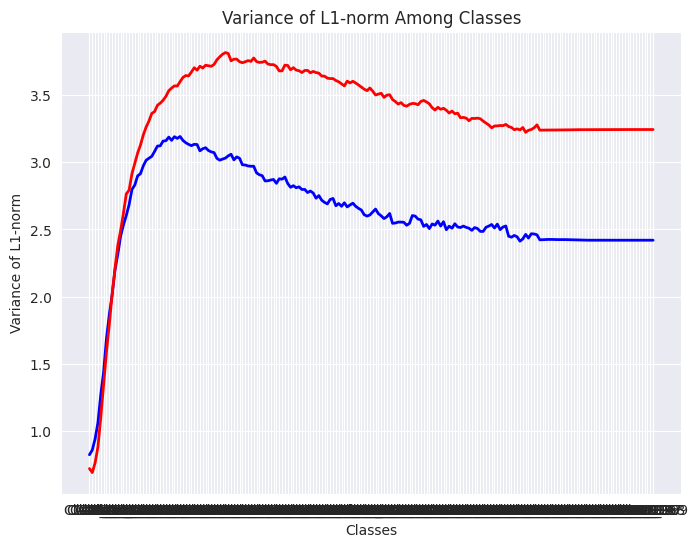

In [43]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list)), variance_list, color='red', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()